# <font color="#5e548e"> Chill Analytics Exercise

##### <font color="#5e548e">Daniel Quesada</font>

<div style="text-align: center">
    <img src="https://i1.wp.com/insurance-edge.net/wp-content/uploads/2020/06/chill-insurance-investment.jpg?fit=597%2C323" 
    style="height: 200px;"/>
</div>

## <font color="#5e548e"> Table of Content <a name="ToC"></a>
0. [Libraries Importation & Funtions Definition](#id0)<br>
1. [Dataset EDA](#id1)<br>
    1.1 [Dataset Importation & Overall view](#id11)<br>
    1.2 [Missing & Duplicates Values Treatment](#id12)<br>
    1.3 [Univariate Analysis: Numerical Variables](#id13)<br>
    1.4 [Univariate Analysis: Categorical Variables](#id14)<br>
    1.5 [Feature Engineering & Exclusion](#id15)<br>
    1.6 [Multivariate Analysis](#id16)<br>
2. [Conversion Model](#id2)<br>
    2.1 [Initial Analysis](#id21)<br>
    2.2 [Dataset partition](#id22)<br>
    2.3 [Model Variable Selection](#id23)<br>
    2.4 [Model Training & Evaluation](#id24)<br>
3. [Drivers of Income](#id3)<br>
4. [A/B Test Evaluation](#id4)<br>

## <font color="#5e548e"> Libraries Importation & Funtions Definition <a name="id0"></a>

[Go to Table of Content](#ToC)

In [1]:
# Load in necessary packages

# EDA
import pandas as pd # to manipulate datasets
import numpy as np # to perform numerical operations
import math # to perform operations
import matplotlib.pyplot as plt # for plotting
import scipy.stats as stats # for hypotesis testing
from scipy.stats import ttest_ind # for hypotesis testing
from matplotlib.gridspec import GridSpec  # for chart and table show at the same level
from pandas.plotting import table # for better formating a value_count table when printing
import seaborn as sns # for plotting
from datetime import datetime # to manipulate dates
import geopandas as gpd # for maps
from itertools import combinations # to do combinations
from sklearn.preprocessing import MinMaxScaler # to scale data


# modeling: data partition
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # for data scaling and encoding categorical variables
from sklearn.model_selection import train_test_split # for spliting between train and test
# for doing the Stratified cv Kfold and calc score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score 
from imblearn.over_sampling import SMOTE  # for handling class imbalance

# modeling: models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # for ensemble models
from sklearn.linear_model import LogisticRegression  # for logistic regression model
from sklearn.linear_model import LinearRegression
import joblib # to save models
import os # to save models
import patsy # for doing splines

# modeling: tuning
from sklearn.model_selection import GridSearchCV  # for cv and hyperparameter tuning
from imblearn.pipeline import Pipeline as ImbPipeline # for creating ML pipelines
from sklearn.pipeline import Pipeline # for creating ML pipelines

# modeling: evaluation
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, auc  # model evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, r2_score

# modeling: XAI
# from sklearn.inspection import permutation_importance # for performing PFI technique
import shap # for performing shap technique
from IPython.display import display, HTML # for performing shap technique
from sklearn.utils import shuffle # for performing PFI technique
import statsmodels.api as sm  # for stepwise regression
from statsmodels.tools import add_constant  # for adding a constant column for intercept in statsmodels

We define the seed we will use in the random functions throughout this notebook:

In [2]:
seed = 123
np.random.seed(seed)

We define the colors to use:

In [3]:
color1 ='#74c69d'
color1_2 ='#9f86c0'
colors2 = ['#be95c4','#CECEEF']
colors2_2 = ['#5e548e','#6B6BCF']
colors3_1 =  ['#be95c4','#CECEEF','#b7e4c7']
colors3_2 = ['#8338ec','#99FF33','#CECEEF']
colors3_3 =  ['#be95c4','#231942','#8338ec']
color_heat = ["#52b788","#b7e4c7","white","#b7e4c7","#52b788"]

Now we are going to define certain function to be able to perform our analysis faster:

**Function to bar charts of 2 levels**

In [4]:
def plot_2bar(data, column, title):
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize': (8, 4)})

    chart = sns.countplot(x=column, data=data, palette=colors2, order=data[column].value_counts().index)

    # Set axis names, x labels and title
    chart.set_xlabel("Conversion")
    chart.set_ylabel(" Nº of quotes")
    chart.set_xticklabels(['No', 'Yes'])
    plt.title(title)
    
    # Set the axis lines to black and adjust the linewidth
    chart.spines['left'].set_color('black')
    chart.spines['left'].set_linewidth(0.8)
    chart.spines['bottom'].set_color('black')
    chart.spines['bottom'].set_linewidth(0.8)

    # Set the % proportion as labels on top of the bars
    total = len(data[column])
    for p in chart.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        chart.annotate(percentage, (x, y), ha='center', va='bottom')

    # Show the plot
    plt.show()

**Function to perform numerical univariate analysis**

In [5]:
def num_analysis(data, exclude=[]):
    numerical_columns = data.select_dtypes(include=['int64', 'float64', 'int32']).columns.difference(exclude)

    for column in numerical_columns:
        # Print the variable name as a bold title
        print("\033[1m" + "\n" + column + "\033[0m")
        
        # Create the summary statistics table
        
        summary_table = data[column].describe(percentiles=[.25, .5, .75]).to_frame().T
        summary_table['count_missing'] = data[column].isna().sum()
        summary_table['cv'] = summary_table['std'] / summary_table['mean']
        summary_table = summary_table[['count', 'count_missing', 'min', '25%', '50%', 'mean', '75%', 'max', 'std', 'cv']]
        summary_table = summary_table.rename(columns={'50%': 'median'})

        # # Format the table to have one decimal place and commas for thousands
        summary_table = summary_table.applymap(lambda x: f"{x:,.1f}")
        summary_table.index = ['']
        
        # Set up the figure and GridSpec layout
        fig = plt.figure(figsize=(10, 5))
        gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], figure=fig)

        # Set up the histogram plot on the top
        ax1 = fig.add_subplot(gs[0])
        sns.set_theme(style='darkgrid')
        chart = sns.histplot(data[column], bins='auto', kde=True, color=color1, ax=ax1)
        ax1.set_title(f'{column} Distribution')
        chart.set_xlabel(column)
        chart.set_ylabel('Frequency')

        # Set the axis lines to black and adjust the linewidth
        chart.spines['left'].set_color('black')
        chart.spines['left'].set_linewidth(0.8)
        chart.spines['bottom'].set_color('black')
        chart.spines['bottom'].set_linewidth(0.8)

        # Set up the summary statistics table below the chart
        ax2 = fig.add_subplot(gs[1])
        ax2.axis('off')  # Hide the axis
        table_ax = table(ax2, summary_table, loc='center', cellLoc='center', colColours=[color1]*summary_table.shape[1])
        table_ax.auto_set_font_size(False)
        table_ax.set_fontsize(10)
        table_ax.scale(1.2, 1.2)  # Adjust table size

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

**Function to perform categorical univariate analysis**

In [6]:
def cat_analysis(data, include=[],exclude=[]):
    columns_to_analyze = data.select_dtypes(include=['object']).columns.union(include).difference(exclude)
    
    for column in columns_to_analyze:
        # Print the variable name as a bold title
        print("\033[1m" + "\n" + column + "\033[0m")

        # Create the summary table including missing values
        summary_table = data[column].value_counts(dropna=False).reset_index()
        summary_table.columns = ['Level', 'Count']
        summary_table['Proportion'] = summary_table['Count'] / len(data[column]) * 100
        summary_table['Proportion'] = summary_table['Proportion'].apply(lambda x: f'{x:.2f}%')

        # Replace NaN with 'Missing' in the summary table for display purposes
        summary_table['Level'] = summary_table['Level'].astype(str).replace('nan', 'Missing')

        # Prepare the data for plotting, replacing NaNs with 'Missing'
        plot_data = data[column].astype(str).replace('nan', 'Missing')

        # Set up the figure and GridSpec layout
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 2], figure=fig)  # Adjust height ratios
        
        # Set up the bar chart on the top
        ax1 = fig.add_subplot(gs[0])
        sns.set_theme(style='darkgrid')
        chart = sns.countplot(ax=ax1, x=plot_data, color=color1, order=plot_data.value_counts().index)
        chart.set_ylabel("Nº of quotes")
        chart.set_xlabel(column)
        ax1.set_title(f"{column} Levels Distribution")
        chart.spines['left'].set_color('black')
        chart.spines['left'].set_linewidth(0.8)
        chart.spines['bottom'].set_color('black')
        chart.spines['bottom'].set_linewidth(0.8)
        
        if data[column].nunique(dropna=False) > 15:
            chart.tick_params(axis='x', rotation=65)
        elif data[column].nunique(dropna=False) > 8:
            chart.tick_params(axis='x', rotation=45)

        total = len(data[column])
        for p in chart.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            chart.annotate(percentage, (x, y), ha='center', va='bottom')
        
        # Set up the summary table below
        ax2 = fig.add_subplot(gs[1])
        ax2.axis('off')  # Hide the axis
        table_ax = table(ax2, summary_table, loc='center', cellLoc='center', colColours=[color1]*summary_table.shape[1])
        table_ax.auto_set_font_size(False)
        table_ax.set_fontsize(10)
        table_ax.scale(1.2, 1.2)  # Adjust table size

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

**Function to perform bivariate analysis**

In [7]:
def bivar_analysis_1(data, target, colors, exclude=[]):
    for column in data.columns:
        if column not in exclude:
            print("\033[1m" + "\n" + column + "\033[0m")
            
            if data[column].dtype in ['int64', 'int32', 'float64'] and data[column].nunique() > 2:
                # Numerical variable analysis
                plt.figure(figsize=(8, 4))
                chart = sns.kdeplot(data=data, x=column, hue=target, fill=True, common_norm=True, palette=colors)
                chart.spines['left'].set_color('black')
                chart.spines['left'].set_linewidth(0.8)
                chart.spines['bottom'].set_color('black')
                chart.spines['bottom'].set_linewidth(0.8)
                chart.set_title(f'{column} Distribution by {target}')
                chart.set_xlabel(column)
                chart.set_ylabel('Frequency')
                plt.show()
            else:
                # Categorical variable analysis with a stacked bar chart
                plt.figure(figsize=(8, 4))
                
                if data[column].nunique() == 2 and data[column].dtype in ['int64', 'int32']:
                    # Convert binary numerical variable to string
                    data[column] = data[column].astype(str)
                
                # Plot stacked bar chart using seaborn
                chart = sns.histplot(data, x=column, hue=target, multiple="stack", palette=colors, shrink=0.8)
                
                chart.set_xlabel(column)
                chart.set_ylabel('Count')
                chart.set_title(f'{column} Distribution by {target}')
                
                # Set tick parameters
                if data[column].nunique() > 8:
                    plt.xticks(rotation=45, ha='right')
                else:
                    plt.xticks(rotation=0)
                
                # Add percentage annotations
                for p in chart.patches:
                    width = p.get_width()
                    height = p.get_height()
                    x = p.get_x()
                    y = p.get_y()
                    column_value = data[column].unique()[int(x + width / 2)]
                    total = len(data[data[column] == column_value])
                    percentage = f'{100 * height / total:.1f}%'
                    plt.text(x + width / 2, y + height / 2, percentage, ha='center', va='center')
                
                # Set the spines' color and linewidth
                ax = plt.gca()
                ax.spines['left'].set_color('black')
                ax.spines['left'].set_linewidth(0.8)
                ax.spines['bottom'].set_color('black')
                ax.spines['bottom'].set_linewidth(0.8)
                
                plt.show()

In [8]:
# just for binary target variable 
def bivar_analysis_2(data, target, colors=colors2, exclude=[]):
    for column in data.columns:
        if column not in exclude:
            print("\033[1m" + "\n" + column + "\033[0m")
            
            if data[column].dtype in ['int64', 'int32', 'float64'] and data[column].nunique() > 2:
                # Numerical variable analysis with custom plot
                tabla = data.groupby(column).agg(
                    total=(column, 'count'),
                    prop_target=(target, lambda x: round(sum(x == 1) / len(x) * 100, 1))
                ).reset_index()

                fig, ax1 = plt.subplots(figsize=(15, 4))

                ax1.bar(tabla[column], tabla['total'], color=colors[1])
                ax1.set_xlabel(column)
                ax1.set_ylabel('Total', color=colors[1])
                ax1.tick_params(axis='y', labelcolor=colors[1])

                ax2 = ax1.twinx()
                ax2.plot(tabla[column], tabla['prop_target'], color=colors[0], marker='o')
                ax2.set_ylabel('Proportion of Target (%)', color=colors[0])
                ax2.tick_params(axis='y', labelcolor=colors[0])

                for i in range(len(tabla)):
                    ax2.text(tabla[column][i], tabla['prop_target'][i], 
                             f"{tabla['prop_target'][i]}%", color=colors[0], ha='center', va='bottom')

                fig.tight_layout()
                plt.title(f'{column} Distribution by {target}')
                plt.show()
            else:
                # Categorical variable analysis with a stacked bar chart
                plt.figure(figsize=(15, 4))
                
                if data[column].nunique() == 2 and data[column].dtype in ['int64', 'int32']:
                    # Convert binary numerical variable to string
                    data[column] = data[column].astype(str)
                
                # Plot stacked bar chart using seaborn
                chart = sns.histplot(data, x=column, hue=target, multiple="stack", palette=colors, shrink=0.8)
                
                chart.set_xlabel(column)
                chart.set_ylabel('Count')
                chart.set_title(f'{column} Distribution by {target}')
                
                # Set tick parameters
                if data[column].nunique() > 8:
                    plt.xticks(rotation=45, ha='right')
                else:
                    plt.xticks(rotation=0)
                
                # Add percentage annotations
                for p in chart.patches:
                    width = p.get_width()
                    height = p.get_height()
                    x = p.get_x()
                    y = p.get_y()
                    column_value = data[column].unique()[int(x + width / 2)]
                    total = len(data[data[column] == column_value])
                    percentage = f'{100 * height / total:.1f}%'
                    plt.text(x + width / 2, y + height / 2, percentage, ha='center', va='center')
                
                # Set the spines' color and linewidth
                ax = plt.gca()
                ax.spines['left'].set_color('black')
                ax.spines['left'].set_linewidth(0.8)
                ax.spines['bottom'].set_color('black')
                ax.spines['bottom'].set_linewidth(0.8)
                
                plt.show()

**Function for plotting the competitiveness against the conversion rate**

In [9]:
def plot_comp(data,competitive,conversion, title, colors):
    # Set theme for the plot
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(15, 3))

    # Create custom bins
    bins_below_1 = np.linspace(data[competitive].min(), 1, 7, endpoint=False)
    bins_above_1 = np.linspace(1, data[competitive].max(), 7)
    bins = np.concatenate([bins_below_1, bins_above_1])

    # Ensure bins are strictly increasing
    bins = np.unique(bins)

    # Create the histogram plot with custom bins
    chart = sns.histplot(data[competitive], bins=bins, kde=False, color=colors[1])

    # Set title and labels
    plt.title(title)
    chart.set_xlabel('Value')
    chart.set_ylabel('Frequency')

    # Calculate bin counts for competitive
    total_count = len(data[competitive])
    bin_counts, _, _ = plt.hist(data[competitive], bins=bins, alpha=0)

    # Calculate conversion rates for each bin
    conversion_rates = []
    for i in range(len(bins) - 1):
        bin_data = data[(data[competitive] >= bins[i]) & (data[competitive] < bins[i+1])]
        if not bin_data.empty:
            conversion_rate = bin_data[conversion].sum() / bin_data[competitive].sum() * 100
        else:
            conversion_rate = 0
        conversion_rates.append(conversion_rate)

    # Plot percentages on the histogram
    for count, edge in zip(bin_counts, bins[:-1]):
        percentage = (count / total_count) * 100
        plt.text(edge + (bins[1] - bins[0]) / 2, count, f'{percentage:.1f}%', ha='center', va='bottom')

    # Add vertical red line at value 1
    plt.axvline(x=1, color='red', linestyle='--')

    # Set custom x-ticks
    plt.xticks(bins, rotation=45)

    # Set the axis lines to black and adjust the linewidth
    chart.spines['left'].set_color('black')
    chart.spines['left'].set_linewidth(0.8)
    chart.spines['bottom'].set_color('black')
    chart.spines['bottom'].set_linewidth(0.8)

    # Create secondary y-axis for conversion rates
    ax2 = chart.twinx()
    ax2.plot(bins[:-1] + (bins[1] - bins[0]) / 2, conversion_rates, color=colors[0], marker='o', linestyle='--')
    ax2.set_ylabel('Conversion Rate (%)')
    ax2.yaxis.label.set_color(colors[0])
    ax2.tick_params(axis='y', colors=colors[0])

    # Add conversion rate percentages to the plot
    for i, (conv_rate, bin_center) in enumerate(zip(conversion_rates, bins[:-1] + (bins[1] - bins[0]) / 2)):
        ax2.text(bin_center, conv_rate, f'{conv_rate:.1f}%', color=colors2[0], ha='center', va='bottom')

    # Show the plot
    plt.show()

In [10]:
def plot_comp_2(data,competitive,conversion, title, colors,width=15,height=3):
    # Set theme for the plot
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(width, height))

    # Create custom bins
    bins_below_1 = np.linspace(data[competitive].min(), 1, 7, endpoint=False)
    bins_above_1 = np.linspace(1, data[competitive].max(), 7)
    bins = np.concatenate([bins_below_1, bins_above_1])

    # Ensure bins are strictly increasing
    bins = np.unique(bins)

    # Create the histogram plot with custom bins
    chart = sns.histplot(data[competitive], bins=bins, kde=False, color=colors[1])

    # Set title and labels
    plt.title(title)
    chart.set_xlabel('Competitiveness')
    chart.set_ylabel('Frequency')

    # Calculate bin counts for competitive
    total_count = len(data[competitive])
    bin_counts, _, _ = plt.hist(data[competitive], bins=bins, alpha=0)

    # Calculate conversion rates for each bin
    conversion_rates = []
    for i in range(len(bins) - 1):
        bin_data = data[(data[competitive] >= bins[i]) & (data[competitive] < bins[i+1])]
        if not bin_data.empty:
            conversion_rate = bin_data[conversion].sum() / bin_data[competitive].sum() * 100
        else:
            conversion_rate = 0
        conversion_rates.append(conversion_rate)

    # Plot percentages on the histogram
    for count, edge in zip(bin_counts, bins[:-1]):
        percentage = (count / total_count) * 100
        plt.text(edge + (bins[1] - bins[0]) / 2, count, f'{percentage:.1f}%', ha='center', va='bottom')

    # Add vertical red line at value 1
    plt.axvline(x=1, color='red', linestyle='--')

    # Set custom x-ticks
    plt.xticks(bins, rotation=45)

    # Set the axis lines to black and adjust the linewidth
    chart.spines['left'].set_color('black')
    chart.spines['left'].set_linewidth(0.8)
    chart.spines['bottom'].set_color('black')
    chart.spines['bottom'].set_linewidth(0.8)

    # Create secondary y-axis for conversion rates
    ax2 = chart.twinx()
    ax2.plot(bins[:-1] + (bins[1] - bins[0]) / 2, conversion_rates, color=colors[0], marker='o', linestyle='--')
    ax2.set_ylabel('Conversion Rate (%)')
    ax2.yaxis.label.set_color(colors[0])
    ax2.tick_params(axis='y', colors=colors[0])

    # Add conversion rate percentages to the plot
    for i, (conv_rate, bin_center) in enumerate(zip(conversion_rates, bins[:-1] + (bins[1] - bins[0]) / 2)):
        ax2.text(bin_center, conv_rate, f'{conv_rate:.1f}%', color=colors2[0], ha='center', va='bottom')

    # Show the plot
    plt.show()

**Function to evaluate models**

In [11]:
def calc_metrics(model, X, y, threshold):
    # Predict probabilities for the data
    y_prob = model.predict_proba(X)[:, 1]

    # Predict labels based on the threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    prevalence = (tp + fn) / (tn + fp + fn + tp)

    # Create confusion matrix dataframe
    df_cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'],
                         columns=['Predicted Negative', 'Predicted Positive'])

    # Calculate precision-recall curve and area under the curve
    precisions, recalls, thresholds = precision_recall_curve(y, y_prob)
    pr_auc = auc(recalls, precisions)

    # Plot the results
    plt.figure(figsize=(15, 6))

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap=sns.color_palette(colors2), cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recalls, precisions, color='#231942', linewidth=2, label=f'PR AUC = {pr_auc:.2f}')
    
    # Plot "no skill" line
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='#74c69d', label='No Skill')

    plt.title(f'Precision-Recall Curve (PR AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prevalence: {prevalence:.4f}")

In [12]:
def calc_metrics_2(model, X, y, threshold,width=15,height=6):
    # Predict probabilities for the data
    y_prob = model.predict_proba(X)[:, 1]

    # Predict labels based on the threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    prevalence = (tp + fn) / (tn + fp + fn + tp)

    # Create confusion matrix dataframe
    df_cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'],
                         columns=['Predicted Negative', 'Predicted Positive'])

    # Calculate precision-recall curve and area under the curve
    precisions, recalls, thresholds = precision_recall_curve(y, y_prob)
    pr_auc = auc(recalls, precisions)

    # Plot the results
    plt.figure(figsize=(width, height))

    # Plot Precision-Recall curve
    plt.plot(recalls, precisions, color='#231942', linewidth=3, label=f'PR AUC = {pr_auc:.2f}')
    
    # Plot "no skill" line
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='#74c69d', label='No Skill',linewidth=3)
    
    # Customize the plot
    plt.title('', fontsize=20, fontweight='bold')
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.legend(title='', fontsize=18)
    plt.grid(True)

    # Increase font size of the axis tick values
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Set the axis lines to black and adjust the linewidth
    chart = plt.gca()
    chart.spines['left'].set_color('black')
    chart.spines['left'].set_linewidth(0.8)
    chart.spines['bottom'].set_color('black')
    chart.spines['bottom'].set_linewidth(0.8)
    chart.spines['top'].set_visible(False)
    chart.spines['right'].set_visible(False)

    # Show the plot
    plt.tight_layout()
    plt.show()

**PFI Function**

In [13]:
def PFI(model, X, y, repetitions=10, threshold=0.5, metric=f1_score):
    # Predict using the original model
    y_pred = (model.predict_proba(X)[:, 1] > threshold).astype(int)

    # Calculate the baseline performance
    base = metric(y, y_pred)
    
    # Initialize a dataframe to store results
    results = pd.DataFrame(index=range(repetitions), columns=X.columns)

    # Perform PFI for each predictor
    for col in X.columns:
        # Repeat the process as many times as defined by repetitions
        for i in range(repetitions):
            X_copy = X.copy()

            # Permute the variable in question
            X_copy[col] = shuffle(X_copy[col].values)

            # Predict with the permuted data
            y_pred_copy = (model.predict_proba(X_copy)[:, 1] > threshold).astype(int)

            # Calculate the new performance
            result_changed = metric(y, y_pred_copy)

            # Calculate the performance deterioration
            if result_changed != 0:
                results.loc[i, col] = max(0, base / result_changed - 1)
            else:
                results.loc[i, col] = 0  # Set to zero if result_changed is 0

    return results

**PFI Plot Function**

In [14]:
def PFI_plot(PFI_model, top_n=15):
    
    # Get the mean results and sort them
    mean_results = PFI_model.mean().sort_values(ascending=False)
    mean_results_top = mean_results[:top_n]

    # Filter the PFI model to include only the top features
    PFI_model_top = PFI_model[mean_results_top.index]

    # Convert from wide to long format
    long_df = pd.melt(PFI_model_top)

    # Get the min and max for each variable
    df_min_max = (long_df
                  .groupby('variable')['value'].agg(['min', 'max', 'mean'])
                  .reset_index()
                  .sort_values(by='mean', ascending=False)
                  .drop('mean', axis=1)
                  )

    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot a line for each variable from min to max
    for index, row in df_min_max.iterrows():
        ax.plot([row['min'], row['max']], [row['variable'], row['variable']], color='#5e548e')

    # Plot the mean points
    sns.scatterplot(x=mean_results_top, y=mean_results_top.index, color='#231942', ax=ax)

    ax.set_title('Permutation Feature Importance (PFI)')
    ax.set_xlabel('Variable Importance (Metric Measure Deterioration)')
    ax.set_ylabel('Most Relevant Variables')

    plt.show()

**Forward Stepwise AIC Function**

In [15]:
def forwardAIC(y, X):
    # Reset indices to ensure alignment
    y = y.reset_index(drop=True)
    X = X.reset_index(drop=True)
    
    # Add intercept column to the DataFrame
    X = sm.add_constant(X, has_constant='add')
    
    # Initialize variables
    aics = []
    variables_consider = ['const']  # 'const' for the intercept term
    model_current = sm.Logit(y, X[variables_consider]).fit(disp=0)  # Initial model with intercept only
    aics.append(('none', model_current.aic))
    
    # List of variables available to choose (excluding 'const')
    var_available = X.columns.difference(variables_consider).tolist()
    stop = False  # Initialize the stop variable

    while not stop:
        aics_level = []  # List of AICs for this round
        for variable in var_available:  # Loop over models with additional variable
            model = sm.Logit(y, X[variables_consider + [variable]]).fit(disp=0)
            aics_level.append((variable, model.aic))

        if min(aics_level, key=lambda x: x[1])[1] < aics[-1][1]:  # If there is a model with AIC reduction
            var_index = aics_level.index(min(aics_level, key=lambda x: x[1]))
            variables_consider.append(var_available[var_index])
            model_current = sm.Logit(y, X[variables_consider]).fit(disp=0)
            var_available.remove(var_available[var_index])
            aics.append((variables_consider[-1], model_current.aic))
        else:  # If there is no model with AIC reduction, stop the loop
            stop = True

    # Remove 'const' before returning
    variables_consider.remove('const')
    
    # Create a DataFrame for the variables and their corresponding AICs
    aic_df = pd.DataFrame(aics, columns=['Variable', 'AIC'])
    
    return variables_consider, model_current, aic_df

**Splines Function**

In [16]:
def apply_splines(data, variable, low_limit=0.25, upper_limit=1.15, degree=3, df=4, slope_factor=1, 
                  bin_start=0, bin_end=2.1, bin_width=0.05, colors=colors3_3):
    # Create bins
    bins = np.arange(bin_start, bin_end, bin_width)

    # Create a column for the binning
    data['variable_bin'] = pd.cut(data[variable], bins, right=False)

    # Calculate the conversion rate for each bin
    conversion_rates = data.groupby('variable_bin').agg(
        total=('MOD_sale', 'count'),
        conversions=('MOD_sale', 'sum')
    ).reset_index()

    # Add conversion rate column
    conversion_rates['conversion_rate'] = conversion_rates['conversions'] / conversion_rates['total'] * 100

    # Select the required columns including the count of observations
    conversion_rates_selected = conversion_rates[['variable_bin', 'total', 'conversion_rate']]

    # Extract the midpoint of each bin for plotting and spline fitting
    conversion_rates_selected['bin_mid'] = conversion_rates_selected['variable_bin'].apply(lambda x: x.mid)

    # Ensure bin_mid is a float
    conversion_rates_selected['bin_mid'] = conversion_rates_selected['bin_mid'].astype(float)

    # Fit a spline to the specified range
    fit_range = conversion_rates_selected[
        (conversion_rates_selected['bin_mid'] >= low_limit) & 
        (conversion_rates_selected['bin_mid'] < upper_limit)
    ]

    # Apply spline transformation to the specified range
    spline_terms = patsy.dmatrix("bs(fit_range['bin_mid'], df=df, degree=degree) - 1", {"fit_range": fit_range},
                                 return_type='dataframe')
    spline_fit_coefficients = np.linalg.lstsq(spline_terms,
                                              fit_range['conversion_rate'],
                                              rcond=None)[0]
    spline_fit = np.dot(spline_terms, spline_fit_coefficients)

    # Initial View
    plt.figure(figsize=(15, 4))
    sns.set_theme(style='darkgrid')
    ax1 = plt.gca()
    
    # Adjusted bar width to ensure no overlapping
    bar_width = bin_width * 0.8
    bars = ax1.bar(conversion_rates_selected['bin_mid'], conversion_rates_selected['total'], 
                   width=bar_width, color=colors[0], alpha=0.8, label='Total Count')  # Adjusted width to ensure visibility
    
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Total Count')
    ax1.tick_params(axis='y', labelcolor=colors[0])

    # Create secondary y-axis for conversion rates
    ax2 = ax1.twinx()
    ax2.plot(fit_range['bin_mid'], spline_fit, color=colors[1], label='Spline Fit')
    ax2.set_ylim(-10, 30)
    ax2.set_ylabel('Conversion Rate (%)')
    ax2.yaxis.label.set_color(colors[1])
    ax2.tick_params(axis='y', colors=colors[1])

    # Smooth transition for bins outside the specified range
    pre_fit = np.poly1d(
        np.polyfit(conversion_rates_selected[conversion_rates_selected['bin_mid'] < low_limit]['bin_mid'],
                   conversion_rates_selected[conversion_rates_selected['bin_mid'] < low_limit]['conversion_rate'], 1))
    post_fit = np.poly1d(
        np.polyfit(conversion_rates_selected[conversion_rates_selected['bin_mid'] >= upper_limit]['bin_mid'],
                   conversion_rates_selected[conversion_rates_selected['bin_mid'] >= upper_limit]['conversion_rate'], 1))

    # Plot the conversion rates as points
    ax2.scatter(conversion_rates_selected['bin_mid'], conversion_rates_selected['conversion_rate'],
                color=colors[2], zorder=5, label='Conversion Rate')

    # Adding labels and legend
    plt.title('Conversion Rate with Spline Fit')
    plt.tight_layout()  # to ensure the right y-label is not slightly clipped
    plt.show()

    # Second View

    # Linear regression between spline_fit and fit_range['bin_mid']
    reg = LinearRegression()
    reg.fit(fit_range['bin_mid'].values.reshape(-1, 1), spline_fit)

    # Extract the original slope (coefficient) and intercept
    original_slope = reg.coef_[0]
    intercept = reg.intercept_
    modified_slope = original_slope * slope_factor

    # Recompute the predictions using the modified slope and intercept
    linear_fit_modified = modified_slope * conversion_rates_selected['bin_mid'] + intercept

    # Create a composite fit array
    linear_fit_composite = linear_fit_modified.copy()
    linear_fit_composite[(conversion_rates_selected['bin_mid'] >= low_limit) & 
                         (conversion_rates_selected['bin_mid'] < upper_limit)] = spline_fit

    # Apply the linear fit for the last point of the fit_range
    last_fit_range_index = fit_range.index[-1]
    linear_fit_composite[last_fit_range_index] = (linear_fit_modified[last_fit_range_index] + spline_fit[-1]) / 2
    
    conversion_rates_selected_array=conversion_rates_selected['bin_mid']

    # Plot the original conversion rates
    plt.figure(figsize=(15, 4))
    sns.set_theme(style='darkgrid')
    ax1 = plt.gca()
    ax1.bar(conversion_rates_selected['bin_mid'], conversion_rates_selected['total'], 
            width=bar_width, color=colors[0], alpha=0.8, label='Total Count')  # Adjusted width to ensure visibility
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Total Count')
    ax1.tick_params(axis='y', labelcolor=colors[0])

    # Create secondary y-axis for conversion rates
    ax2 = ax1.twinx()
    ax2.plot(conversion_rates_selected['bin_mid'], linear_fit_composite,
             color=colors[1], label='Spline and Modified Linear Fit Composite')
    ax2.set_ylim(-10, 30)
    ax2.set_ylabel('Conversion Rate (%)')
    ax2.yaxis.label.set_color(colors[1])
    ax2.tick_params(axis='y', colors=colors[1])

    # Plot the conversion rates as points
    ax2.scatter(conversion_rates_selected['bin_mid'], conversion_rates_selected['conversion_rate'],
                color=colors[2], zorder=5, label='Conversion Rate')

    # Adding labels and legend
    plt.title('Conversion Rate with Spline Fit and Modified Linear Extension')
    plt.tight_layout()  # to ensure the right y-label is not slightly clipped
    plt.show()
    
    return linear_fit_composite, conversion_rates_selected_array

## <font color="#5e548e">1. Dataset EDA <a name="id1"></a>

[Go to Table of Content](#ToC)

### <font color="#5e548e">1.1. Dataset Importation & Overall view</font> <a name="id11"></a>

[Go to Table of Content](#ToC)

First we import the excel dataset

In [17]:
data = pd.read_excel('AnalyticsRecruitmentDataset1 v5.xlsx', sheet_name='Data', index_col=0)
data.iloc[:, 0:38].head(5).T

0.0                  1.0  \
EffectiveDate                   2023-11-30 00:00:00  2023-11-30 00:00:00   
WorkDate                        2023-11-11 00:00:00  2023-11-11 00:00:00   
QuoteQueryId                               56346939             56358210   
QuoteDriverId1                             72262056             72277335   
QuoteDriverId2                                  NaN                  NaN   
PolicyInceptionDate             2023-12-03 00:00:00  2023-11-14 00:00:00   
ProposerYearsAtHomeAddress                        0                    0   
AddressLine4                                 Dublin                 Cork   
NCDClaimedYearsEarned                             2                    4   
NCDDrivingExperienceYears                         0                    0   
VehicleCode                                22525401             95050627   
VehicleValue                                   8000                 5000   
VehicleAnnualMileage                           5000                 7000   
VehicleDateManufactured         2013-01-01 00:00:00  2013-01-01 00:00:00   
VehicleImported                                   0                    0   
VehicleEngineCapacity                          1685                 1248   
VehicleFuelType                                   D                    D   
VehicleSeats                                      5                    5   
VehicleDoors                                    5.0                  5.0   
VehicleOvernightLocation            Parked On Drive      Parked On Drive   
VehicleBodyType                                   4                    5   
CarsInHouseHold                                 NaN                  NaN   
EmploymentStatus                           Employed             Employed   
LicenceType                       Provisional Irish           Full Irish   
LicenceCountry                                   IE                   IE   
ClaimsIndicator                                   0                    0   
VoluntaryExcess                                   0                    0   
Driver1RelationshipToProposer              Proposer             Proposer   
Driver1Age                                       24                   24   
Driver1VehicleDrivingFrequency                 Main                  NaN   
Driver2RelationshipToProposer                   NaN                  NaN   
Driver2Age                                      NaN                  NaN   
Driver2LicenceType                              NaN                  NaN   
Driver2LicenceCountry                           NaN                  NaN   
Driver2LicenceDate                              NaT                  NaT   
Driver2EmploymentStatus                         NaN                  NaN   
Driver2VehicleDrivingFrequency                  NaN                  NaN   
Driver2ClaimsIndicator                          NaN                  NaN   

                                                2.0                  3.0  \
EffectiveDate                   2023-11-30 00:00:00  2023-11-30 00:00:00   
WorkDate                        2023-11-12 00:00:00  2023-11-12 00:00:00   
QuoteQueryId                               56364057             56387878   
QuoteDriverId1                             72285133             72317347   
QuoteDriverId2                                  NaN                  NaN   
PolicyInceptionDate             2023-11-21 00:00:00  2023-11-13 00:00:00   
ProposerYearsAtHomeAddress                        0                    0   
AddressLine4                                   Cork               Dublin   
NCDClaimedYearsEarned                             0                    0   
NCDDrivingExperienceYears                         0                    0   
VehicleCode                                95050219             95051712   
VehicleValue                                   2000                 6000   
VehicleAnnualMileage                           1000                 5000   
VehicleDateManufact

In [18]:
data.iloc[:, 38:].head(5).T

0.0  \
Insurer_1GrossPremCompStepAnnual                    1974.12   
Insurer_1NetPremCompStepAnnual                       1692.1   
Insurer_1FeePremCompStepAnnual                          0.0   
Insurer_1CommissionCompStepAnnual                    188.01   
Insurer_1DiscountCompStep                             21.32   
Insurer_1IncomeIfSold                                209.33   
Insurer_1CustomerPrice                              1995.44   
Insurer_2GrossPremCompStepAnnual                    2245.39   
Insurer_2NetPremCompStepAnnual                      1909.63   
Insurer_2FeePremCompStepAnnual                          0.0   
Insurer_2CommissionCompStepAnnual                    188.87   
Insurer_2DiscountCompStep                             24.25   
Insurer_2IncomeIfSold                                213.12   
Insurer_2CustomerPrice                              2269.64   
Insurer_3GrossPremCompStepAnnual                        NaN   
Insurer_3NetPremCompStepAnnual                          NaN   
Insurer_3FeePremCompStepAnnual                          NaN   
Insurer_3CommissionCompStepAnnual                       NaN   
Insurer_3DiscountCompStep                               NaN   
Insurer_3IncomeIfSold                                   NaN   
Insurer_3CustomerPrice                                  NaN   
Insurer_4GrossPremCompStepAnnual                        NaN   
Insurer_4NetPremCompStepAnnual                          NaN   
Insurer_4FeePremCompStepAnnual                          NaN   
Insurer_4CommissionCompStepAnnual                       NaN   
Insurer_4DiscountCompStep                               NaN   
Insurer_4IncomeIfSold                                   NaN   
Insurer_4CustomerPrice                                  NaN   
SaleFlag                                            No Sale   
IsDirectDebit                                             0   
SaleCoverType                      Third party, fire, theft   
HomeOwner                                                 N   
PricingModel                                            Low   
MarketPricePrediction                                846.13   

                                                        1.0  \
Insurer_1GrossPremCompStepAnnual                      658.9   
Insurer_1NetPremCompStepAnnual                       564.77   
Insurer_1FeePremCompStepAnnual                          0.0   
Insurer_1CommissionCompStepAnnual                     62.75   
Insurer_1DiscountCompStep                            -12.86   
Insurer_1IncomeIfSold                                 49.89   
Insurer_1CustomerPrice                               646.04   
Insurer_2GrossPremCompStepAnnual                     723.53   
Insurer_2NetPremCompStepAnnual                       615.35   
Insurer_2FeePremCompStepAnnual                          0.0   
Insurer_2CommissionCompStepAnnual                     60.86   
Insurer_2DiscountCompStep                            -14.12   
Insurer_2IncomeIfSold                                 46.74   
Insurer_2CustomerPrice                               709.41   
Insurer_3GrossPremCompStepAnnual                     829.31   
Insurer_3NetPremCompStepAnnual                       712.47   
Insurer_3FeePremCompStepAnnual                          0.0   
Insurer_3CommissionCompStepAnnual                     79.16   
Insurer_3DiscountCompStep                            -16.19   
Insurer_3IncomeIfSold                                 62.97   
Insurer_3CustomerPrice                               813.12   
Insurer_4GrossPremCompStepAnnual                        NaN   
Insurer_4NetPremCompStepAnnual                          NaN   
Insurer_4FeePremCompStepAnnual                          NaN   
Insurer_4CommissionCompStepAnnual                       NaN   
Insurer_4DiscountCompStep                               NaN   
Insurer_4IncomeIfSold                                   NaN   
Insurer_4CustomerPrice                                  NaN   
SaleFlag               

We see that it has been rightly imported. Now we check the dimensions of the dataset:

In [19]:
data.shape

(1818, 72)

We check the info of the variables:

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1818 entries, 0.0 to 2100.68333333333
Data columns (total 72 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   EffectiveDate                      1818 non-null   datetime64[ns]
 1   WorkDate                           1818 non-null   datetime64[ns]
 2   QuoteQueryId                       1818 non-null   int64         
 3   QuoteDriverId1                     1818 non-null   int64         
 4   QuoteDriverId2                     810 non-null    float64       
 5   PolicyInceptionDate                1818 non-null   datetime64[ns]
 6   ProposerYearsAtHomeAddress         1818 non-null   int64         
 7   AddressLine4                       1818 non-null   object        
 8   NCDClaimedYearsEarned              1818 non-null   int64         
 9   NCDDrivingExperienceYears          1818 non-null   int64         
 10  VehicleCode         

We check the overall distribution of the variables. We start with the categorical ones:

In [21]:
data.describe(include='object').T

count unique                       top  freq
AddressLine4                    1818     29                    Dublin   472
VehicleFuelType                 1583      3                         D   912
VehicleOvernightLocation        1803      6  Kept On Private Property   864
EmploymentStatus                1818      5                  Employed  1479
LicenceType                     1818      6                Full Irish  1413
LicenceCountry                  1818     14                        IE  1740
Driver1RelationshipToProposer   1818      1                  Proposer  1818
Driver1VehicleDrivingFrequency  1747      5                      Main  1365
Driver2RelationshipToProposer    396      9                  Relative   199
Driver2Age                       810     65                        50    28
Driver2LicenceType               810      6                Full Irish   704
Driver2LicenceCountry            810     12                        IE   771
Driver2EmploymentStatus          810      5                  Employed   596
Driver2VehicleDrivingFrequency   810      1                  Frequent   810
SaleFlag                        1818     13                   No Sale  1708
SaleCoverType                   1818      2  Third party, fire, theft  1717
HomeOwner                       1818      2                         N  1210
PricingModel                    1818      5                  Champion   706

It doesn't make sense that *Driver2Age* is a string variable. Let's check its values:

In [22]:
data.Driver2Age.unique()

array([nan, 49, 66, 42, 50, 55, 56, 43, 41, 61, 78, 44, 35, 48, 32, 29,
       52, 53, 33, 59, 39, 30, 63, 23, 31, 34, 58, 25, 27, 47, 38, 46, 45,
       40, 64, 54, 28, 67, 68, 51, 19, 18, 37, 57, 17, 'A', 36, 83, 21,
       69, 62, 26, 74, 24, 20, 77, 22, 71, 76, 80, 70, 81, 60, 65, 90, 72],
      dtype=object)

We can observe that there is an A, let's check which quoteid it is:

In [23]:
# we save this quote id to change it later
id_change=data[data.Driver2Age=="A"].QuoteQueryId.values[0]

# we print the whole case
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data[data.Driver2Age=="A"].T)

                                                      386.0
EffectiveDate                           2023-11-30 00:00:00
WorkDate                                2023-11-12 00:00:00
QuoteQueryId                                       56370689
QuoteDriverId1                                     72293748
QuoteDriverId2                                   72293749.0
PolicyInceptionDate                     2023-12-06 00:00:00
ProposerYearsAtHomeAddress                                0
AddressLine4                                        Kildare
NCDClaimedYearsEarned                                     0
NCDDrivingExperienceYears                                 6
VehicleCode                                        95040096
VehicleValue                                           3000
VehicleAnnualMileage                                  15000
VehicleDateManufactured                 2008-01-01 00:00:00
VehicleImported                                           0
VehicleEngineCapacity                   

For the rest it looks fine so we will impute another value in that variable. However, at the end of this section we will change this variable to numeric.

We continue with the numerical ones:

In [24]:
data.iloc[:,0:45].describe().T

count          mean           std  \
QuoteQueryId                       1818.0  5.636183e+07  1.534285e+04   
QuoteDriverId1                     1818.0  7.228194e+07  2.089681e+04   
QuoteDriverId2                      810.0  7.228141e+07  2.125701e+04   
ProposerYearsAtHomeAddress         1818.0  0.000000e+00  0.000000e+00   
NCDClaimedYearsEarned              1818.0  3.773377e+00  3.723716e+00   
NCDDrivingExperienceYears          1818.0  4.768977e-01  1.354893e+00   
VehicleCode                        1818.0  6.588770e+07  3.412105e+07   
VehicleValue                       1818.0  1.088148e+04  1.036614e+04   
VehicleAnnualMileage               1818.0  8.473597e+03  4.471596e+03   
VehicleImported                    1818.0  0.000000e+00  0.000000e+00   
VehicleEngineCapacity              1818.0  1.581454e+03  4.199893e+02   
VehicleSeats                       1818.0  5.000000e+00  0.000000e+00   
VehicleDoors                       1597.0  4.517220e+00  7.612055e-01   
VehicleBodyType                    1818.0  5.716172e+00  1.817718e+00   
CarsInHouseHold                       0.0           NaN           NaN   
ClaimsIndicator                    1818.0  2.420242e-02  1.537194e-01   
VoluntaryExcess                    1818.0  0.000000e+00  0.000000e+00   
Driver1Age                         1818.0  3.552530e+01  1.422640e+01   
Driver2ClaimsIndicator              810.0  1.604938e-02  1.257431e-01   
Insurer_1GrossPremCompStepAnnual   1265.0  1.789181e+03  1.648799e+03   
Insurer_1NetPremCompStepAnnual     1264.0  1.532340e+03  1.413123e+03   
Insurer_1FeePremCompStepAnnual     1265.0  1.596443e+01  2.426488e+01   
Insurer_1CommissionCompStepAnnual  1264.0  1.702601e+02  1.570138e+02   
Insurer_1DiscountCompStep          1264.0  5.204640e+01  1.138715e+02   
Insurer_1IncomeIfSold              1264.0  2.382835e+02  2.352189e+02   
Insurer_1CustomerPrice             1265.0  1.857151e+03  1.711944e+03   

                                           min          25%           50%  \
QuoteQueryId                       56335302.00  56348393.25  5.636190e+07   
QuoteDriverId1                     72244966.00  72264055.00  7.228199e+07   
QuoteDriverId2                     72244988.00  72262505.25  7.228250e+07   
ProposerYearsAtHomeAddress                0.00         0.00  0.000000e+00   
NCDClaimedYearsEarned                     0.00         0.00  3.000000e+00   
NCDDrivingExperienceYears                 0.00         0.00  0.000000e+00   
VehicleCode                         1020501.00  35536001.00  9.504012e+07   
VehicleValue                            500.00      4000.00  7.750000e+03   
VehicleAnnualMileage                   1000.00      5000.00  8.000000e+03   
VehicleImported                           0.00         0.00  0.000000e+00   
VehicleEngineCapacity                     0.00      1329.00  1.560000e+03   
VehicleSeats                              5.00         5.00  5.000000e+00   
VehicleDoors                              2.00         4.00  5.000000e+00   
VehicleBodyType                           2.00         5.00  5.000000e+00   
CarsInHouseHold                            NaN          NaN           NaN   
ClaimsIndicator                           0.00         0.00  0.000000e+00   
VoluntaryExcess                           0.00         0.00  0.000000e+00   
Driver1Age                               17.00        24.00  3.300000e+01   
Driver2ClaimsIndicator                    0.00         0.00  0.000000e+00   
Insurer_1GrossPremCompStepAnnual        346.50       622.52  1.142680e+03   
Insurer_1NetPremCompStepAnnual          297.00       533.59  9.779450e+02   
Insurer_1FeePremCompStepAnnual            0.00         0.00  0.000000e+00   
Insurer_1CommissionCompStepAnnual        33.00        59.29  1.086650e+02   
Insurer_1DiscountCompStep              -349.93       -20.71  3.285000e+00   
Insurer_1IncomeIfSold                     1.84        67.26  1.605250e+02   
Insurer_1CustomerPrice                  317.25       637.65  1

In [25]:
data.iloc[:,45:].describe().T

count         mean          std     min  \
Insurer_2GrossPremCompStepAnnual   1245.0  1540.943687  1069.312135  354.59   
Insurer_2NetPremCompStepAnnual     1245.0  1310.523526   909.415904  301.56   
Insurer_2FeePremCompStepAnnual     1245.0    20.489960    25.728160    0.00   
Insurer_2CommissionCompStepAnnual  1245.0   129.612000    89.942137   29.83   
Insurer_2DiscountCompStep          1245.0    40.024964    98.015537 -276.64   
Insurer_2IncomeIfSold              1243.0   190.432840   153.857045  -12.70   
Insurer_2CustomerPrice             1245.0  1601.458610  1113.777838  378.26   
Insurer_3GrossPremCompStepAnnual    679.0   881.632975   527.960267  310.00   
Insurer_3NetPremCompStepAnnual      679.0   757.416716   453.574136  266.32   
Insurer_3FeePremCompStepAnnual      679.0    19.661267    20.551830    0.00   
Insurer_3CommissionCompStepAnnual   679.0    84.157393    50.397195   29.59   
Insurer_3DiscountCompStep           679.0     6.511576    65.565198 -235.08   
Insurer_3IncomeIfSold               679.0   110.330236    92.111091    2.45   
Insurer_3CustomerPrice              679.0   907.805817   552.902987  323.04   
Insurer_4GrossPremCompStepAnnual     16.0     0.000000     0.000000    0.00   
Insurer_4NetPremCompStepAnnual       16.0     0.000000     0.000000    0.00   
Insurer_4FeePremCompStepAnnual       16.0     0.000000     0.000000    0.00   
Insurer_4CommissionCompStepAnnual    16.0     0.000000     0.000000    0.00   
Insurer_4DiscountCompStep            16.0     0.000000     0.000000    0.00   
Insurer_4IncomeIfSold                 0.0          NaN          NaN     NaN   
Insurer_4CustomerPrice                0.0          NaN          NaN     NaN   
IsDirectDebit                      1818.0     0.029153     0.168281    0.00   
MarketPricePrediction              1818.0   913.100462   533.219987  298.33   

                                        25%      50%       75%       max  
Insurer_2GrossPremCompStepAnnual   842.1300  1198.40  1828.050  10615.74  
Insurer_2NetPremCompStepAnnual     716.2100  1019.20  1554.700   9028.34  
Insurer_2FeePremCompStepAnnual       0.0000     0.00    35.000     80.00  
Insurer_2CommissionCompStepAnnual   70.8300   100.80   153.760    892.91  
Insurer_2DiscountCompStep          -29.9500     0.00   100.320    360.01  
Insurer_2IncomeIfSold               87.0600   148.28   257.080    972.91  
Insurer_2CustomerPrice             860.2700  1248.56  1918.340  10695.74  
Insurer_3GrossPremCompStepAnnual   570.7150   731.66   996.940   5657.76  
Insurer_3NetPremCompStepAnnual     490.3050   628.58   856.475   4860.62  
Insurer_3FeePremCompStepAnnual       0.0000    10.00    35.000     80.00  
Insurer_3CommissionCompStepAnnual   54.4800    69.84    95.165    540.07  
Insurer_3DiscountCompStep          -31.9450     0.00    26.295    359.99  
Insurer_3IncomeIfSold               56.0450    87.71   142.680    677.23  
Insurer_3CustomerPrice             585.2750   733.96  1031.280   5716.88  
Insurer_4GrossPremCompStepAnnual     0.0000     0.00     0.000      0.00  
Insurer_4NetPremCompStepAnnual       0.0000     0.00     0.000      0.00  
Insurer_4FeePremCompStepAnnual       0.0000     0.00     0.000      0.00  
Insurer_4CommissionCompStepAnnual    0.0000     0.00     0.000      0.00  
Insurer_4DiscountCompStep            0.0000     0.00     0.000      0.00  
Insurer_4IncomeIfSold                   NaN      NaN       NaN       NaN  
Insurer_4CustomerPrice                  NaN      NaN       NaN       NaN  
IsDirectDebit                        0.0000     0.00     0.000      1.00  
MarketPricePrediction              468.5575   712.03  1246.380   2255.56

Now we check the date variables:

In [26]:
data.select_dtypes(include=['datetime64[ns]']).describe(datetime_is_numeric=True).T

count                          mean        min  \
EffectiveDate            1818 2023-11-30 00:00:00.000000000 2023-11-30   
WorkDate                 1818 2023-11-11 11:39:24.356435712 2023-11-11   
PolicyInceptionDate      1818 2023-11-21 16:00:00.000000000 2023-11-11   
VehicleDateManufactured  1818 2012-10-11 01:12:04.752475136 2000-01-01   
Driver2LicenceDate        810 2009-06-08 22:00:53.333333504 2003-10-12   

                               25%        50%                 75%        max  
EffectiveDate           2023-11-30 2023-11-30 2023-11-30 00:00:00 2023-11-30  
WorkDate                2023-11-11 2023-11-11 2023-11-12 00:00:00 2023-11-12  
PolicyInceptionDate     2023-11-13 2023-11-18 2023-12-01 00:00:00 2023-12-12  
VehicleDateManufactured 2010-01-01 2013-01-01 2016-01-01 00:00:00 2023-01-01  
Driver2LicenceDate      2003-11-11 2003-11-12 2014-11-10 12:00:00 2023-11-12

It would be interesting that before all, check a little bite more on the dates distribution of the inception of the policy:

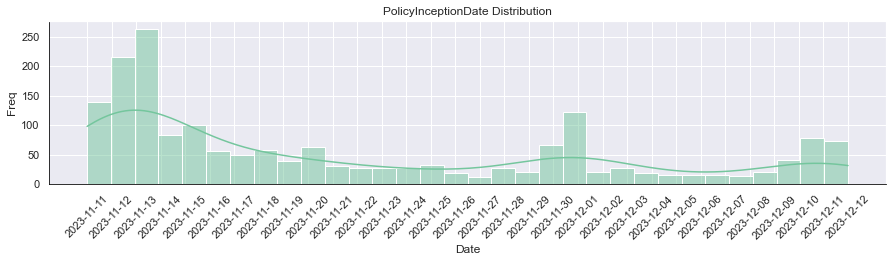

In [27]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15, 3))
chart = sns.histplot(data['PolicyInceptionDate'], bins= data.PolicyInceptionDate.nunique(), kde=True, color=color1)
plt.title('PolicyInceptionDate Distribution')
chart.set_xlabel('Date')
chart.set_ylabel('Freq')
bin_edges = pd.date_range(start=data.PolicyInceptionDate.min(), 
                          end=data.PolicyInceptionDate.max(), periods=data.PolicyInceptionDate.nunique())
plt.xticks(bin_edges,rotation=45)

# Set the axis lines to black and adjust the linewidth
chart.spines['left'].set_color('black')
chart.spines['left'].set_linewidth(0.8)
chart.spines['bottom'].set_color('black')
chart.spines['bottom'].set_linewidth(0.8)

plt.show()

From these overall analysis we can already understand the following:
+ Categorical variables:
    - Exclude Driver1RelationshipToProposer as it is always filled out with proposer as the quotation forces driver 1 to be the proposer.
    - Exclude as Driver2VehicleDrivingFrequency always filled out with a "frequent". Also not in quotation process.
    - We will change Driver2Age to numerical variables because as it showed an "A" when importing the file it assumed it was a string variable and we will assume a value to A
+ Numerical variables:
    - QuoteDriverId2 looks to be just the driving licence ID so we exclude as well as QuoteDriverId1.
    - VehicleBodyType looks to be imported as integer, but they are categories so it should be changed to str
    - VehicleValue and VehicleEngineCapacity look to be imported as integer, but as they are a value we change it to float
    - Exclude ProposerYearsAtHomeAddress as always filled with 0.
    - VehicleCode looks like Vehicle code to join for the vehicle variables so exclude
    - Exclude VehicleImported as always filled with 0.
    - Exclude VehicleSeats as they always takes the value of 5
    - Exclude CarsInHouseHold as it is completely empty
    - Exclude VoluntaryExcess as always filled with 0.
    - Exclude Insurer_4 of the panel variables as they are always 0 for these quotations   
+ Date variables:
    - EffectiveDate should be excluded as it always take the date 2023-11-30.
    - VehicleDateManufactured would be useful to calculate the vehicle age against the inception date and the exclude.
    - WorkDate looks to be the quotation date. They look to be only quotations of 11 and 12 of November 2023 (Saturday and Sunday).
    - The inception dates are in November and December, but looks like about 75% in November. Calculate days to inception variable with WorkDate and the inception date and remove both from database.
    - Exclude Driver2LicenceDate as we don't have it for the main driver. Just use to help impute a value to the age of the case of driver 2 with A
    
When mentioned that any variable is dropped or a new variable could be created this is done in [1.6. Feature Engineering & Exclusion](#id16).

We proceed to change the data type to the variables mentioned before:

In [28]:
# we change the data type of VehicleBodyType and VehicleValue
data.VehicleBodyType = data.VehicleBodyType.astype('str')
data.VehicleValue = data.VehicleValue.astype('float64')
data.VehicleEngineCapacity = data.VehicleEngineCapacity.astype('float64')

# we assume to be 0 to be able to change it
data.loc[data.QuoteQueryId == id_change, 'Driver2Age'] = "0"

# we change the data type
data.Driver2Age = data.Driver2Age.astype('float64')

# we change it was changed
print(data[data.QuoteQueryId==id_change]['Driver2Age'])
data.Driver2Age.info()

386.0    0.0
Name: Driver2Age, dtype: float64
<class 'pandas.core.series.Series'>
Float64Index: 1818 entries, 0.0 to 2100.68333333333
Series name: Driver2Age
Non-Null Count  Dtype  
--------------  -----  
810 non-null    float64
dtypes: float64(1)
memory usage: 28.4 KB


### <font color="#5e548e">1.2. Missing & Duplicates Values Treatment</font> <a name="id12"></a>

[Go to Table of Content](#ToC)

We observe if there are any duplicate quotes:

In [29]:
 # first we check on the index
print(data.index.duplicated().sum())

 # we check on the quote ids
print(data.QuoteQueryId.duplicated().sum())

0
7


As we can see there are 7 duplicates in the quotes id. Let's check them:

In [30]:
id_dups = data[data.QuoteQueryId.duplicated()]['QuoteQueryId']
data[data.QuoteQueryId.isin(id_dups)]

EffectiveDate   WorkDate  QuoteQueryId  QuoteDriverId1  \
18.000000      2023-11-30 2023-11-11      56353023        72270507   
19.000000      2023-11-30 2023-11-12      56379369        72305789   
21.000000      2023-11-30 2023-11-12      56385999        72314695   
22.000000      2023-11-30 2023-11-11      56357494        72276426   
23.000000      2023-11-30 2023-11-11      56353652        72271301   
24.000000      2023-11-30 2023-11-11      56335762        72245678   
25.000000      2023-11-30 2023-11-11      56342927        72256062   
2093.504762    2023-11-30 2023-11-11      56353023        72270507   
2094.701190    2023-11-30 2023-11-12      56379369        72305789   
2095.897619    2023-11-30 2023-11-12      56385999        72314695   
2097.094048    2023-11-30 2023-11-11      56357494        72276426   
2098.290476    2023-11-30 2023-11-11      56353652        72271301   
2099.486905    2023-11-30 2023-11-11      56335762        72245678   
2100.683333    2023-11-30 2023-11-11      56342927        72256062   

             QuoteDriverId2 PolicyInceptionDate  ProposerYearsAtHomeAddress  \
18.000000               NaN          2023-11-26                           0   
19.000000               NaN          2023-11-13                           0   
21.000000               NaN          2023-12-01                           0   
22.000000               NaN          2023-11-26                           0   
23.000000               NaN          2023-12-09                           0   
24.000000        72245679.0          2023-11-21                           0   
25.000000               NaN          2023-11-11                           0   
2093.504762             NaN          2023-11-26                           0   
2094.701190             NaN          2023-11-13                           0   
2095.897619             NaN          2023-12-01                           0   
2097.094048             NaN          2023-11-26                           0   
2098.290476             NaN          2023-12-09                           0   
2099.486905      72245679.0          2023-11-21                           0   
2100.683333             NaN          2023-11-11                           0   

            AddressLine4  NCDClaimedYearsEarned  NCDDrivingExperienceYears  \
18.000000        Wexford                      0                          0   
19.000000        Kildare                      4                          0   
21.000000          Louth                      0                          1   
22.000000          Kerry                      6                          0   
23.000000         Dublin                      9                          0   
24.000000         Dublin                      9                          0   
25.000000           Cork                      0                          2   
2093.504762      Wexford                      0                          0   
2094.701190      Kildare                      4                          0   
2095.897619        Louth                      0                          1   
2097.094048        Kerry                      6                          0   
2098.290476       Dublin                      9                          0   
2099.486905       Dublin                      9                          0   
2100.683333         Cork                      0                          2   

             ...  Insurer_4CommissionCompStepAnnual  \
18.000000    ...                                NaN   
19.000000    ...                                NaN   
21.000000    ...                                NaN   
22.000000    ...                                NaN   
23.000000    ...                                NaN   
24.000000    ...                                NaN   
25.000000    ...                                NaN   
2093.504762  ...                                NaN   
2094.701190  ...                                NaN   
2095.897619  ...                                NaN   

They look to be exactly the same, let's ensure if they are completely duplicated or if there are some differences in some of the features:

In [31]:
# we create an empty dataframe
comparison_results = pd.DataFrame()

for ids in id_dups:
    orig_row = data[data.QuoteQueryId == ids].iloc[0]
    duplicate_row = data[data.QuoteQueryId == ids].iloc[1:]
    
    for i, dup_row in duplicate_row.iterrows():
        comp = pd.Series(index=orig_row.index, dtype=float)
        for col in orig_row.index:
            if col == 'QuoteQueryId':
                comp[col] = 0  # we Skip for the id
            elif pd.isna(orig_row[col]) and pd.isna(dup_row[col]):
                comp[col] = 0  # both NaNs is the same
            else:
                comp[col] = 0 if orig_row[col] == dup_row[col] else 1
        comp = comp.to_frame().T
        comp['QuoteQueryId'] = ids
        
        # we include the new quote id comparison
        comparison_results = pd.concat([comparison_results, comp], ignore_index=True)

# we set the quote id as the index
comparison_results.set_index('QuoteQueryId', inplace=True)

# we sum values by the index
comparison_results.sum(axis=1)

QuoteQueryId
56353023    0.0
56379369    0.0
56385999    0.0
56357494    0.0
56353652    0.0
56335762    0.0
56342927    0.0
dtype: float64

We remove them from the dataset:

In [32]:
# we remove the latter ones
data_clean = data.drop_duplicates(subset='QuoteQueryId', keep='first')

# we set the quote id as the index
data_clean.set_index('QuoteQueryId', inplace=True)

#we check we have it removed
data.shape[0]-data_clean.shape[0]

7

We look if there are any quotes without any panel prices as we are not interested in these ones:

In [33]:
# we take the customer prices in the panel and get the minimum
customer_prices=["Insurer_1CustomerPrice","Insurer_2CustomerPrice","Insurer_3CustomerPrice","Insurer_4CustomerPrice"]
min_price=data_clean[customer_prices].min(axis=1)

# we get the ones with no price
data_clean.loc[(min_price==0) | (min_price.isna()), customer_prices]

Insurer_1CustomerPrice  Insurer_2CustomerPrice  \
QuoteQueryId                                                   
56386560                         NaN                     NaN   
56385999                         NaN                     NaN   
56373763                         NaN                     NaN   
56345514                         NaN                     NaN   
56363011                         NaN                     NaN   
...                              ...                     ...   
56349629                         NaN                     NaN   
56373062                         NaN                     NaN   
56341936                         NaN                     NaN   
56360595                         NaN                     NaN   
56383473                         NaN                     NaN   

              Insurer_3CustomerPrice  Insurer_4CustomerPrice  
QuoteQueryId                                                  
56386560                         NaN                     NaN  
56385999                         NaN                     NaN  
56373763                         NaN                     NaN  
56345514                         NaN                     NaN  
56363011                         NaN                     NaN  
...                              ...                     ...  
56349629                         NaN                     NaN  
56373062                         NaN                     NaN  
56341936                         NaN                     NaN  
56360595                         NaN                     NaN  
56383473                         NaN                     NaN  

[200 rows x 4 columns]

We remove these ones as they are not relevant for our analysis:

In [34]:
# index to remove
drop_rows = min_price[(min_price == 0) | (min_price.isna())].index

# we drop them
data_clean=data_clean.drop(index=drop_rows)

# we check that they don't exist anymore
print(data_clean.shape)
data_clean.loc[(min_price==0) | (min_price.isna()), customer_prices]

(1611, 71)


Empty DataFrame
Columns: [Insurer_1CustomerPrice, Insurer_2CustomerPrice, Insurer_3CustomerPrice, Insurer_4CustomerPrice]
Index: []

In [35]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 56346939 to 56341053
Data columns (total 71 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   EffectiveDate                      1611 non-null   datetime64[ns]
 1   WorkDate                           1611 non-null   datetime64[ns]
 2   QuoteDriverId1                     1611 non-null   int64         
 3   QuoteDriverId2                     744 non-null    float64       
 4   PolicyInceptionDate                1611 non-null   datetime64[ns]
 5   ProposerYearsAtHomeAddress         1611 non-null   int64         
 6   AddressLine4                       1611 non-null   object        
 7   NCDClaimedYearsEarned              1611 non-null   int64         
 8   NCDDrivingExperienceYears          1611 non-null   int64         
 9   VehicleCode                        1611 non-null   int64         
 10  VehicleValue             

It looks like it is just one observation and look ok in the rest variables. As such, to not lose this quote let's impute a logical value on this variable. We will:

1. calculate the age that the other drivers 2 usually have when they got the driving licence, 
2. calculate the average age and the standard deviation,
3. calculate the Coefficient of variation (CV) and if it is not too high impute this average as this driver 2 age

In [36]:
# we calculate the age drivers 2 had when they got the driving licence
data_clean["age_at_licence"]= data_clean.Driver2LicenceDate.dt.year - data_clean.apply(
    lambda row: row['PolicyInceptionDate'].year - row['Driver2Age'], 
    axis=1)

# statistics calculation
mean_age_at_licence=data_clean.drop(id_change).age_at_licence.mean()
sd_at_licence=data_clean.drop(id_change).age_at_licence.std()
CV=sd_at_licence/mean_age_at_licence

# we print the results
print(f"the mean is {np.round(mean_age_at_licence,2)}")
print(f"the standard deviation is {np.round(sd_at_licence,2)}")
print(f"the coefficient of variation is {np.round(CV,2)}")

the mean is 30.32
the standard deviation is 9.48
the coefficient of variation is 0.31


As we can observe it is not too bad so we proceed to impute it:

In [37]:
# we calculate the years from the driving licence date to today
years_case_today=data_clean.loc[id_change, 'PolicyInceptionDate'].year - data_clean.loc[id_change, 'Driver2LicenceDate'].year

# based on the assumption driver 2 was that age, we add the years to today
data_clean.loc[id_change, 'Driver2Age'] =  math.floor(mean_age_at_licence) + years_case_today

# we drop this aux variable as not needed
data_clean.drop(columns=['age_at_licence'], inplace=True)

# we check it has been imputed
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data_clean.loc[id_change].T)

EffectiveDate                             2023-11-30 00:00:00
WorkDate                                  2023-11-12 00:00:00
QuoteDriverId1                                       72293748
QuoteDriverId2                                     72293749.0
PolicyInceptionDate                       2023-12-06 00:00:00
ProposerYearsAtHomeAddress                                  0
AddressLine4                                          Kildare
NCDClaimedYearsEarned                                       0
NCDDrivingExperienceYears                                   6
VehicleCode                                          95040096
VehicleValue                                           3000.0
VehicleAnnualMileage                                    15000
VehicleDateManufactured                   2008-01-01 00:00:00
VehicleImported                                             0
VehicleEngineCapacity                                  1388.0
VehicleFuelType                                             P
VehicleS

### <font color="#5e548e">1.3. Univariate Analysis: Numerical Variables</font> <a name="id13"></a>

[Go to Table of Content](#ToC)

We check each of the numerical variables:


Driver1Age


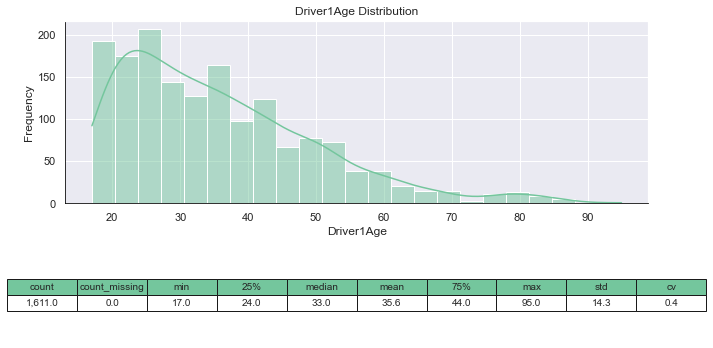


Driver2Age


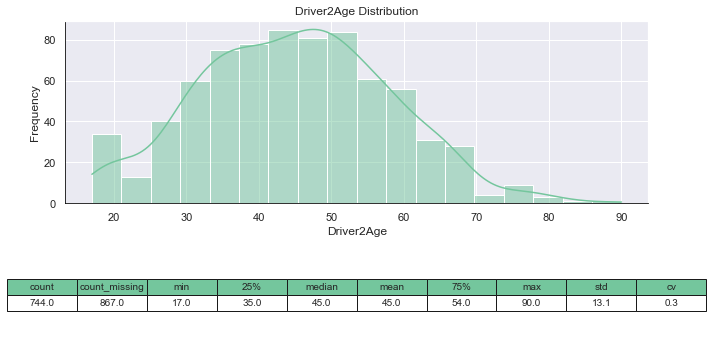


Insurer_1CommissionCompStepAnnual


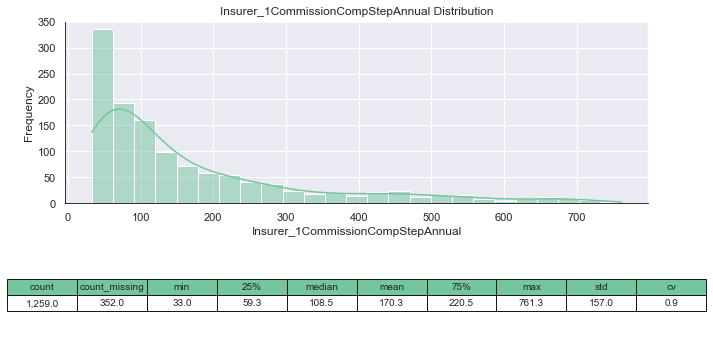


Insurer_1CustomerPrice


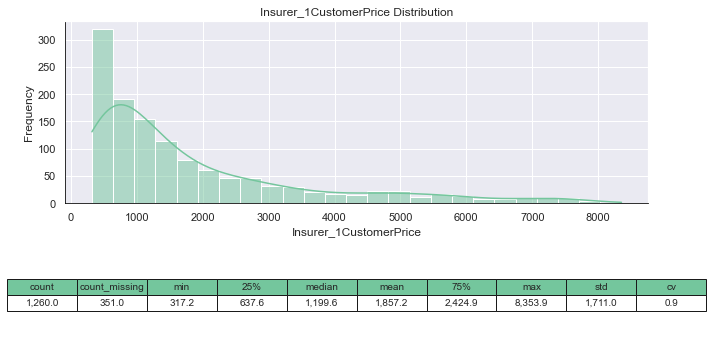


Insurer_1DiscountCompStep


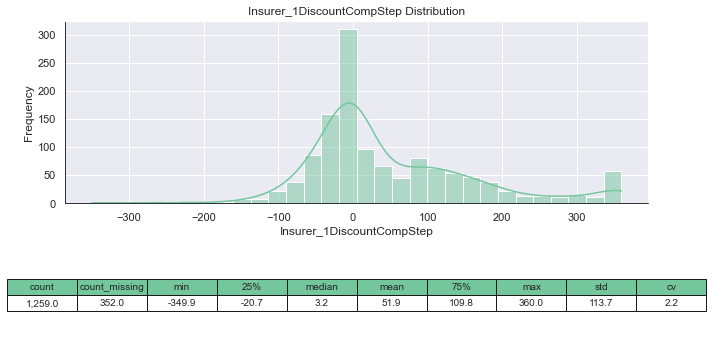


Insurer_1FeePremCompStepAnnual


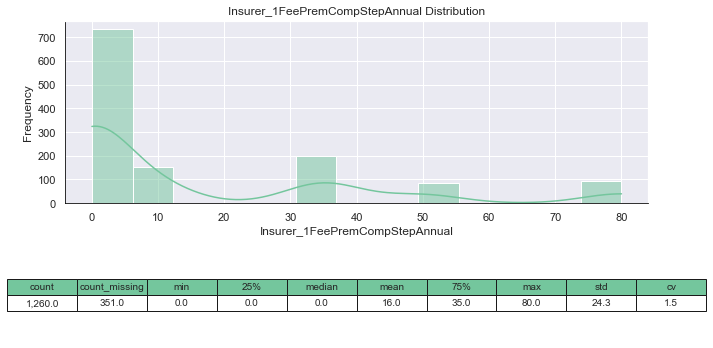


Insurer_1GrossPremCompStepAnnual


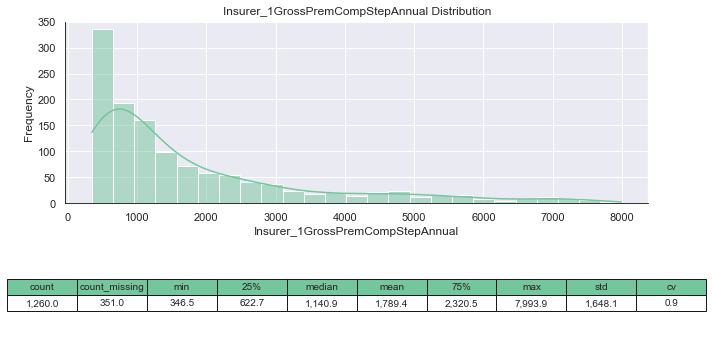


Insurer_1IncomeIfSold


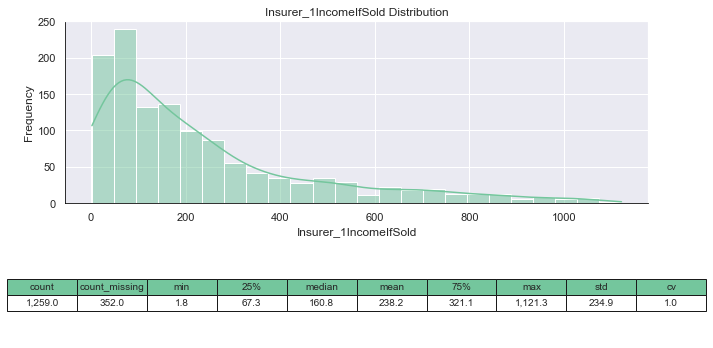


Insurer_1NetPremCompStepAnnual


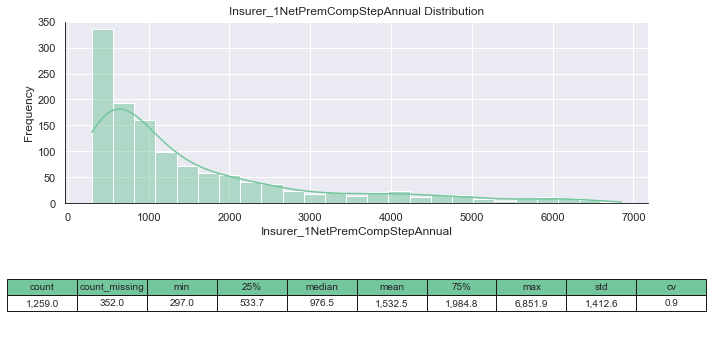


Insurer_2CommissionCompStepAnnual


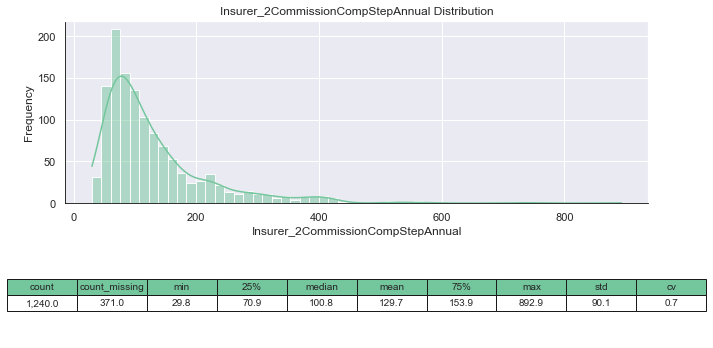


Insurer_2CustomerPrice


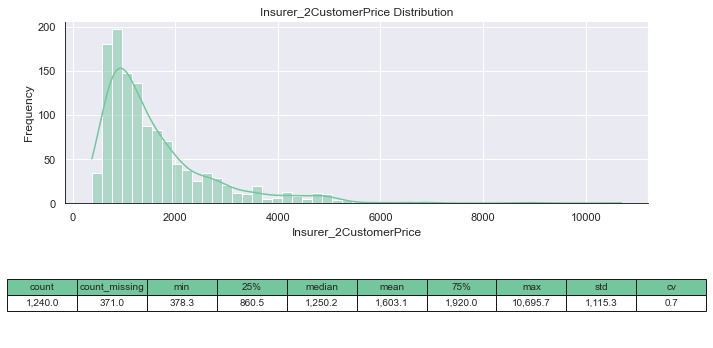


Insurer_2DiscountCompStep


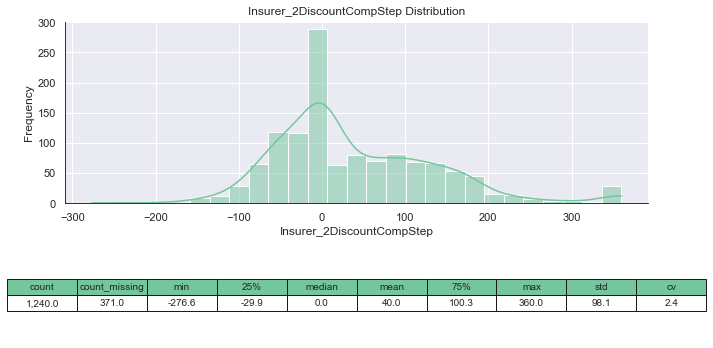


Insurer_2FeePremCompStepAnnual


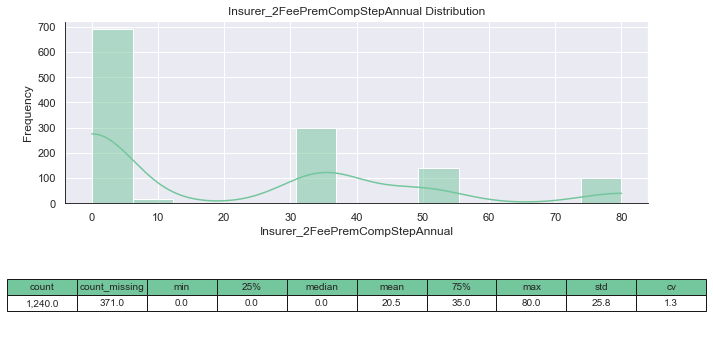


Insurer_2GrossPremCompStepAnnual


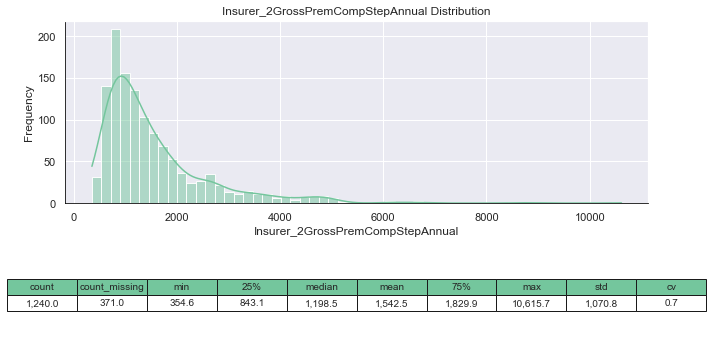


Insurer_2IncomeIfSold


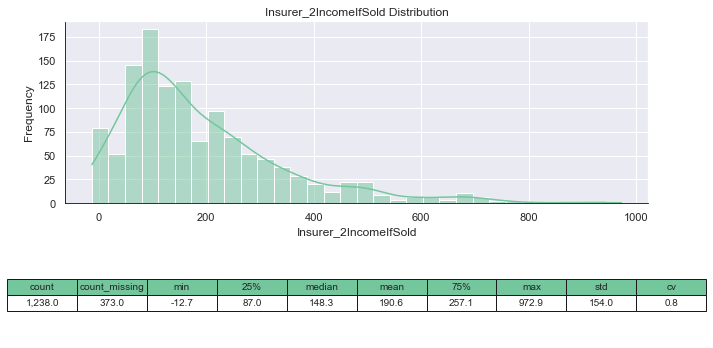


Insurer_2NetPremCompStepAnnual


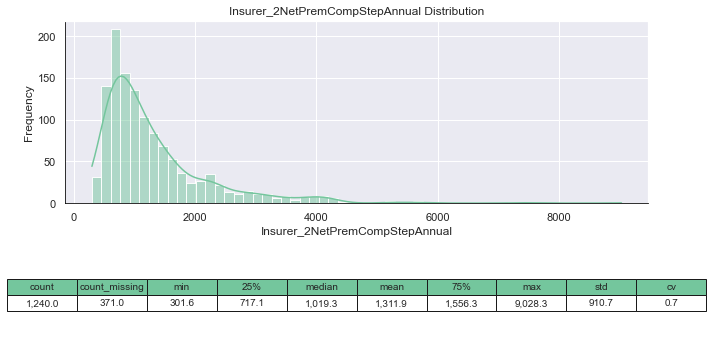


Insurer_3CommissionCompStepAnnual


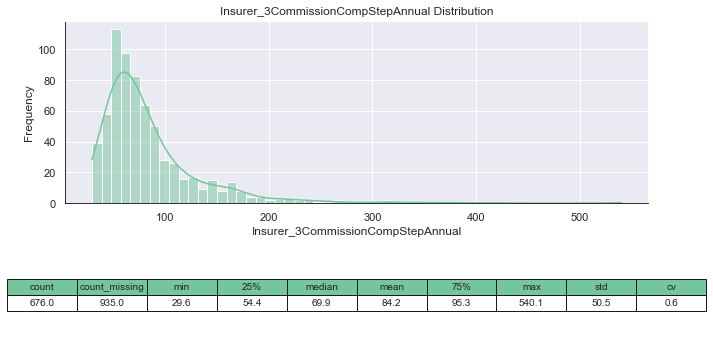


Insurer_3CustomerPrice


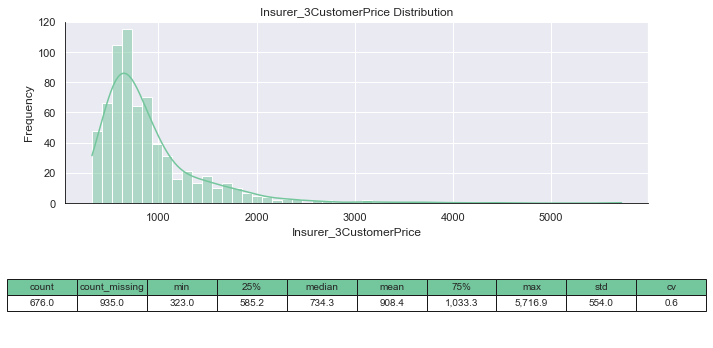


Insurer_3DiscountCompStep


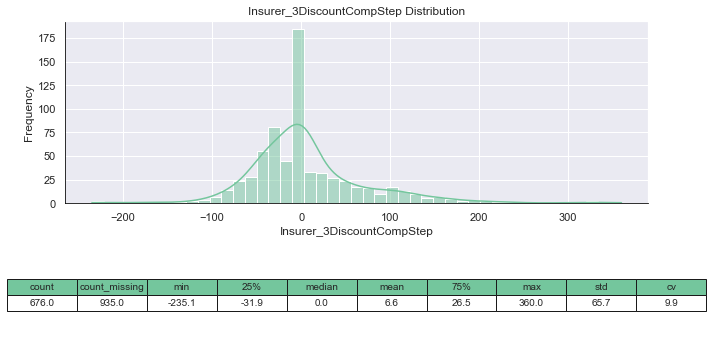


Insurer_3FeePremCompStepAnnual


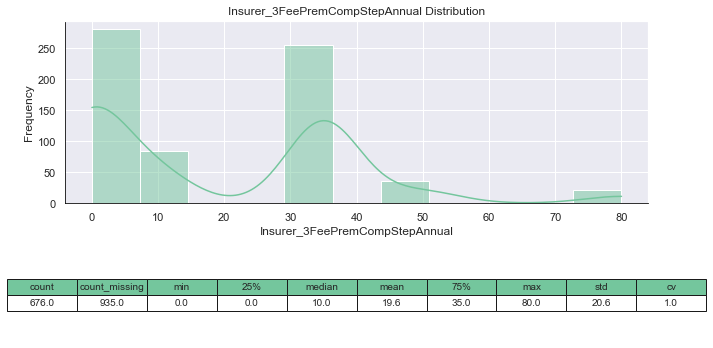


Insurer_3GrossPremCompStepAnnual


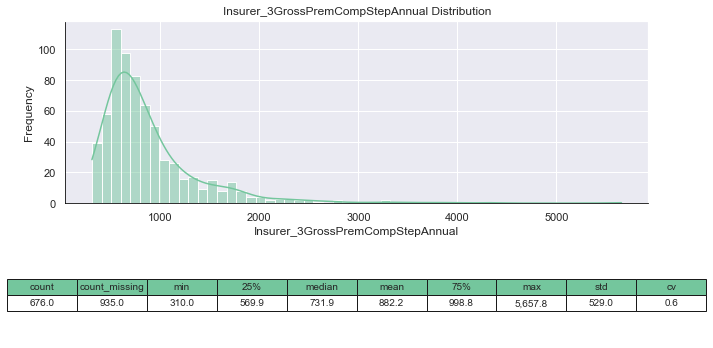


Insurer_3IncomeIfSold


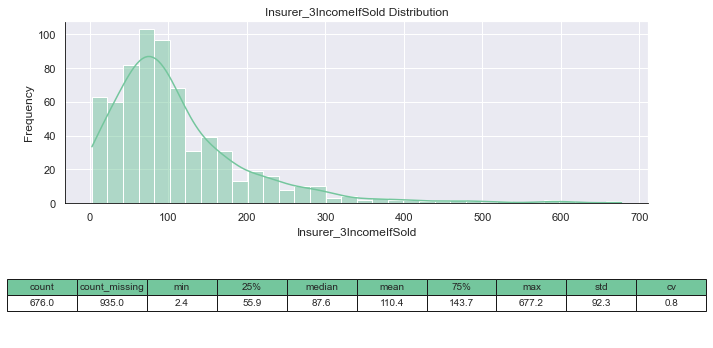


Insurer_3NetPremCompStepAnnual


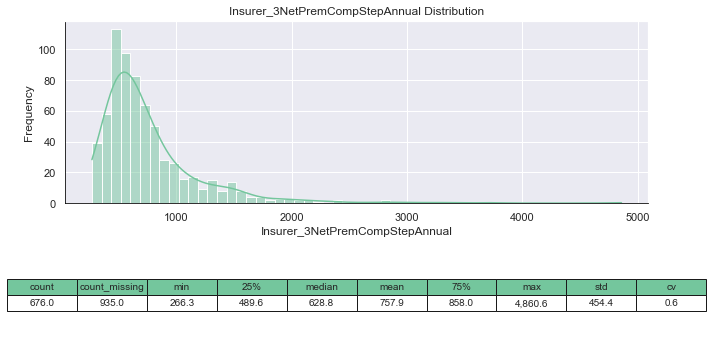


MarketPricePrediction


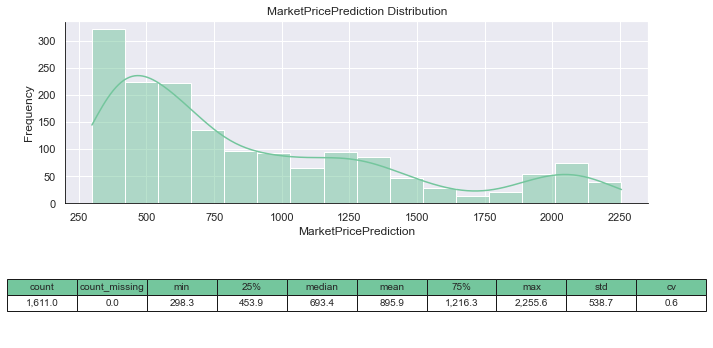


NCDClaimedYearsEarned


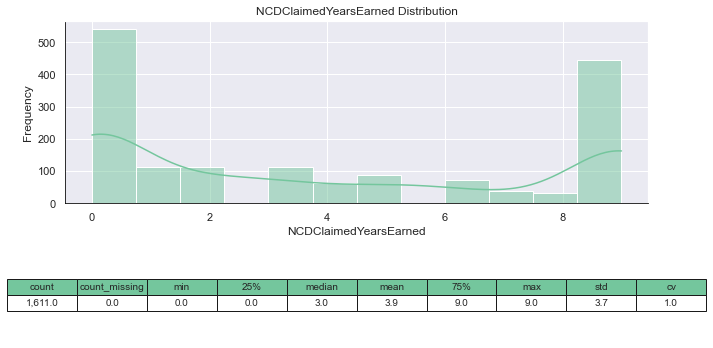


NCDDrivingExperienceYears


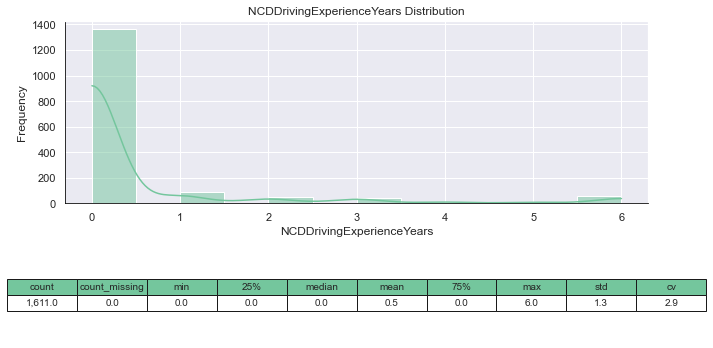


VehicleAnnualMileage


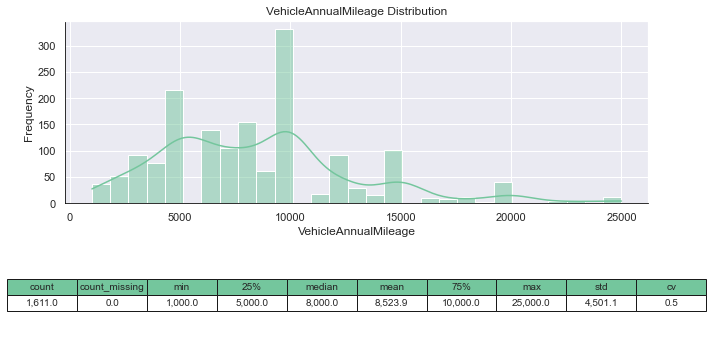


VehicleDoors


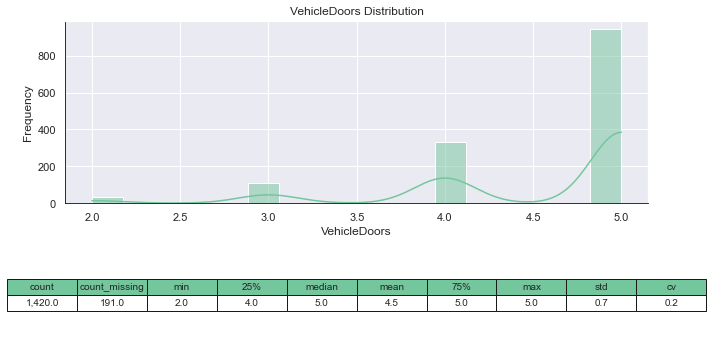


VehicleEngineCapacity


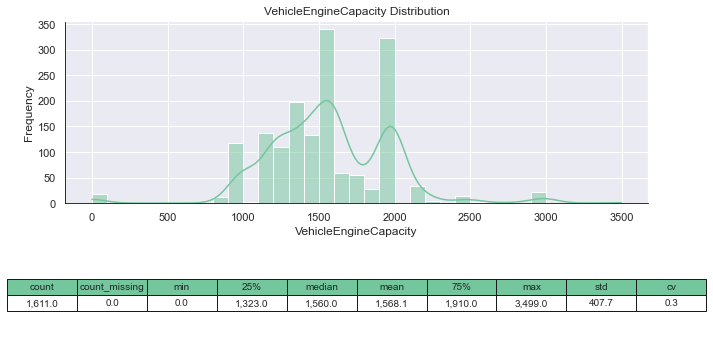


VehicleValue


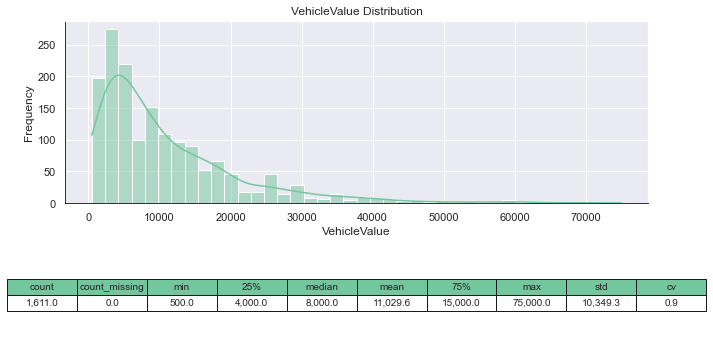

In [38]:
to_exclude=['QuoteDriverId2', 
            'QuoteDriverId1', 
            'ProposerYearsAtHomeAddress', 
            'VehicleCode', 
            'VehicleImported', 
            'VehicleSeats', 
            'CarsInHouseHold', 
            'ClaimsIndicator', 
            'VoluntaryExcess', 
            'Driver2ClaimsIndicator', 
            'Insurer_4GrossPremCompStepAnnual', 
            'Insurer_4NetPremCompStepAnnual', 
            'Insurer_4FeePremCompStepAnnual',
            'Insurer_4CommissionCompStepAnnual', 
            'Insurer_4DiscountCompStep', 
            'Insurer_4IncomeIfSold', 
            'Insurer_4CustomerPrice', 
            'IsDirectDebit']

num_analysis(data_clean, exclude=to_exclude)

Besides we are going to perform a **correlation matrix** to check the linear relation that might exist between the data:

<AxesSubplot:>

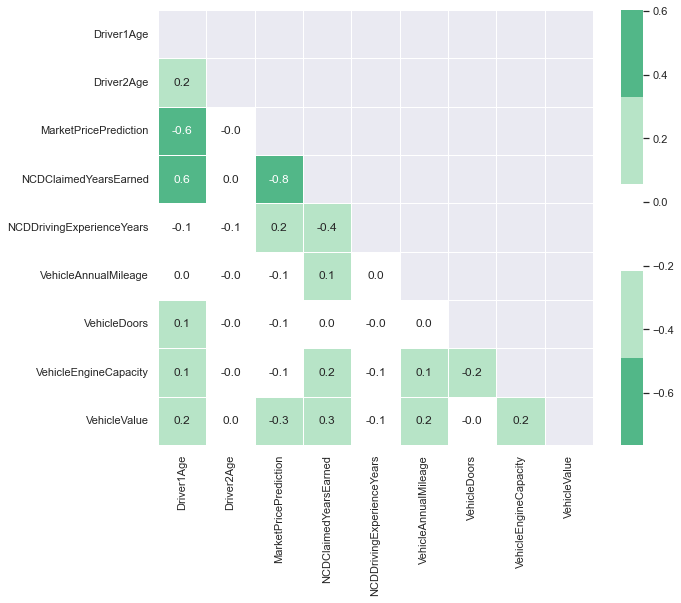

In [39]:
# we exclude variables we don't think are needed to see in the correlation table
to_exclude=['QuoteDriverId2', 
            'QuoteDriverId1', 
            'QuoteQueryId',
            'ProposerYearsAtHomeAddress', 
            'VehicleCode', 
            'VehicleImported', 
            'VehicleSeats', 
            'CarsInHouseHold', 
            'ClaimsIndicator', 
            'VoluntaryExcess', 
            'Driver2ClaimsIndicator', 
            'Insurer_1GrossPremCompStepAnnual', 
            'Insurer_1NetPremCompStepAnnual', 
            'Insurer_1FeePremCompStepAnnual',
            'Insurer_1CommissionCompStepAnnual', 
            'Insurer_1DiscountCompStep', 
            'Insurer_1IncomeIfSold', 
            'Insurer_1CustomerPrice', 
            'Insurer_2GrossPremCompStepAnnual', 
            'Insurer_2NetPremCompStepAnnual', 
            'Insurer_2FeePremCompStepAnnual',
            'Insurer_2CommissionCompStepAnnual', 
            'Insurer_2DiscountCompStep', 
            'Insurer_2IncomeIfSold', 
            'Insurer_2CustomerPrice', 
            'Insurer_3GrossPremCompStepAnnual', 
            'Insurer_3NetPremCompStepAnnual', 
            'Insurer_3FeePremCompStepAnnual',
            'Insurer_3CommissionCompStepAnnual', 
            'Insurer_3DiscountCompStep', 
            'Insurer_3IncomeIfSold', 
            'Insurer_3CustomerPrice', 
            'Insurer_4GrossPremCompStepAnnual', 
            'Insurer_4NetPremCompStepAnnual', 
            'Insurer_4FeePremCompStepAnnual',
            'Insurer_4CommissionCompStepAnnual', 
            'Insurer_4DiscountCompStep', 
            'Insurer_4IncomeIfSold', 
            'Insurer_4CustomerPrice', 
            'IsDirectDebit']

varis=data_clean.select_dtypes(include=['int64', 'float64', 'int32']).columns.difference(to_exclude)

# mask to hide the upper triangle
mask = np.triu(np.ones_like(data_clean[varis].corr(), dtype=bool))

# we plot the correlation table
plt.figure(figsize=(10,8))

sns.heatmap(
    data_clean[varis].corr(), # correlation table
     mask=mask, # to hide the upper triangle
    annot=True,# to add the correlation values
    fmt=".1f",# to format values to 1 decimal
    cmap=color_heat, #color palette
    square=True, # To keep the cells square
    linewidths=.5 # To add space between cells
) 

From these analysis we can conclude the following:
+ For Driver1Age, we can observe that the driver age is low  as on average is 35 and the distribution is skewed to the left. Indeed, we can see that the average market price for this quotes is about 900 which makes sense as these are very young profiles
+ For Driver2Age, opposed to Driver1Age is more symmetrical and centered in 46 years so the second driver usually is older. As there are many missing because there is not second driver we will create the variable minimum age of both drivers. 
+ For the CustomerPrice variables, we observe a pretty high CV which is a good thing because it means that the insurer tariffs are quite segmented and try to adjust to the risk of the customer
+ Discount takes either positive or negative values but as it is quite skewed to the right so in generar the are not discount but surcharges
+ Commissions are relative to the GWP which makes sense while fees are fixed as it also makes sense
+ We can observe also that in general the Income Chill makes is more skewed to the right than the GWP
+ Regarding NCDClaimedYearsEarned and NCDDrivingExperienceYears there is a strange behaviour when looking at NCDClaimedYearsEarned because there are many quotes with 9 years, after we would check if there is a relationship with the driver age
+ It looks like 80% of the quotes register in the quotation process between 5k and 15k as annual mileage. In general, they submit rounded figures: 5k, 10k or 15k which makes sense.
+ From the correlation matrix the only 2 interesting insights are:
    -  There is a strong linear negative correlation between the nº of years without a claim and the market price which makes sense
    -  There is a medium linear negative correlation between the main driver age and the market price
    
When mentioned that any variable is dropped or a new variable could be created this is done in [1.6. Feature Engineering & Exclusion](#id16).

For the new variables created in the [1.6. Feature Engineering & Exclusion](#id16) we will do now the univariate analysis:

Before finishing the numerical univariate analysis, let's take a look to the NCDClaimedYearsEarned variable

In [40]:
# Create the summary table including missing values
summary_table = data_clean['NCDClaimedYearsEarned'].value_counts(dropna=False).reset_index()
summary_table.columns = ['Level', 'Count']
summary_table['Proportion'] = summary_table['Count'] / len(data_clean['NCDClaimedYearsEarned']) * 100
summary_table['Proportion'] = summary_table['Proportion'].apply(lambda x: f'{x:.2f}%')

# Replace NaN with 'Missing' in the summary table for display purposes
summary_table['Level'] = summary_table['Level'].astype(str).replace('nan', 'Missing')

# Calculate the average for each level
averages = data_clean.groupby('NCDClaimedYearsEarned').agg(
    AvgDriver1Age=('Driver1Age', 'mean')
).reset_index().round(1)

# Replace NaN with 'Missing' in the averages for display purposes
averages['NCDClaimedYearsEarned'] = averages['NCDClaimedYearsEarned'].astype(str).replace('nan', 'Missing')

# Merge the tables
summary_table = summary_table.merge(averages, how='left', left_on='Level', right_on='NCDClaimedYearsEarned').drop(
    columns=['NCDClaimedYearsEarned'])

# Convert 'Level' to numeric where possible and sort
summary_table['Level_numeric'] = pd.to_numeric(summary_table['Level'], errors='coerce')
summary_table = summary_table.sort_values(by=['Level_numeric', 'Level']).drop(columns=['Level_numeric'])

summary_table

Level  Count Proportion  AvgDriver1Age
0     0    540     33.52%           27.9
2     1    113      7.01%           30.2
3     2    112      6.95%           29.0
4     3    111      6.89%           30.6
7     4     63      3.91%           29.0
5     5     87      5.40%           37.2
6     6     72      4.47%           37.1
8     7     37      2.30%           37.2
9     8     31      1.92%           43.3
1     9    445     27.62%           49.0

We can see the oldest drivers are the ones with the 9 NCD years earned which makes sense.

### <font color="#5e548e">1.4. Univariate Analysis: Categorical Variables</font> <a name="id14"></a>

[Go to Table of Content](#ToC)

We check each of the categorical variables:


AddressLine4


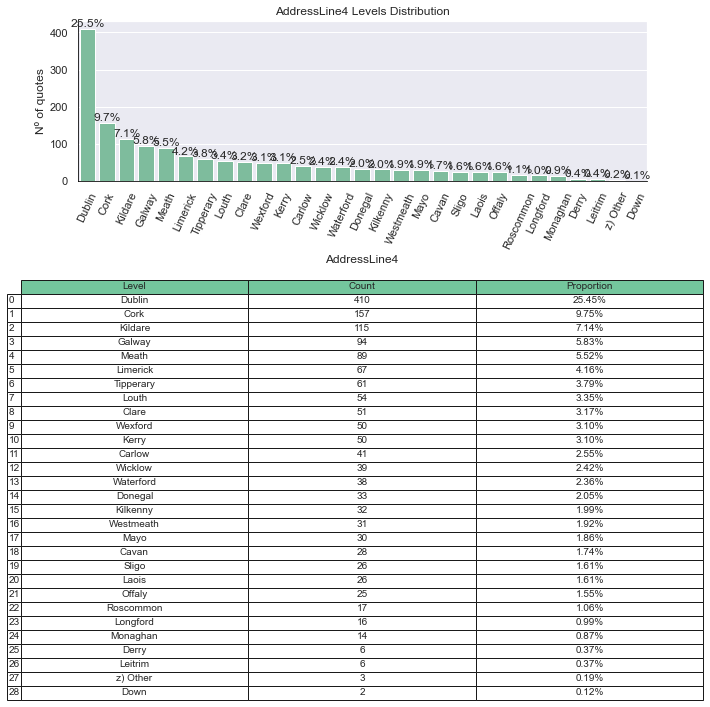


ClaimsIndicator


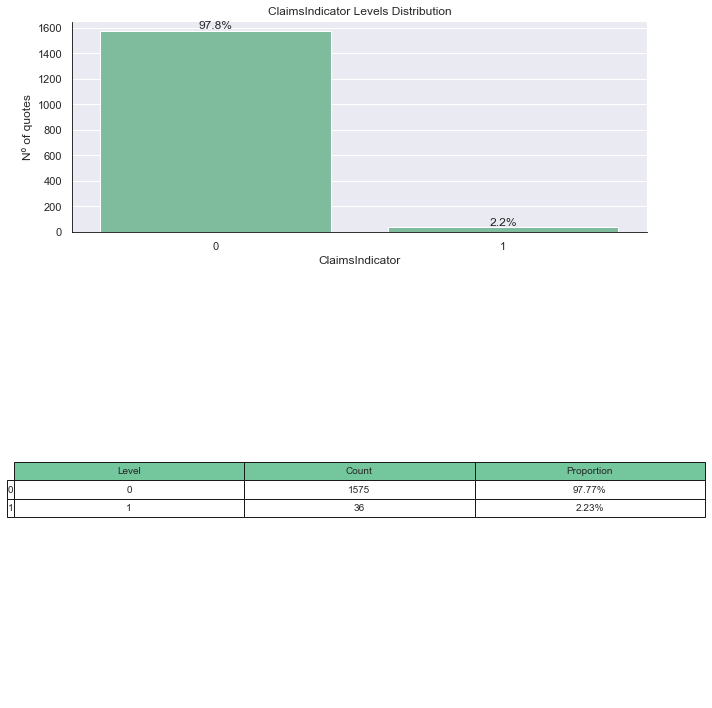


Driver1VehicleDrivingFrequency


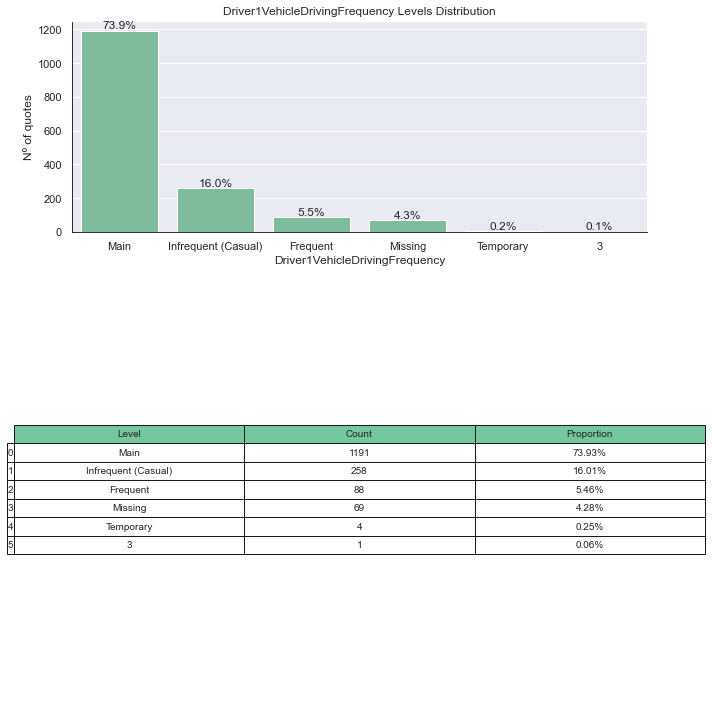


Driver2ClaimsIndicator


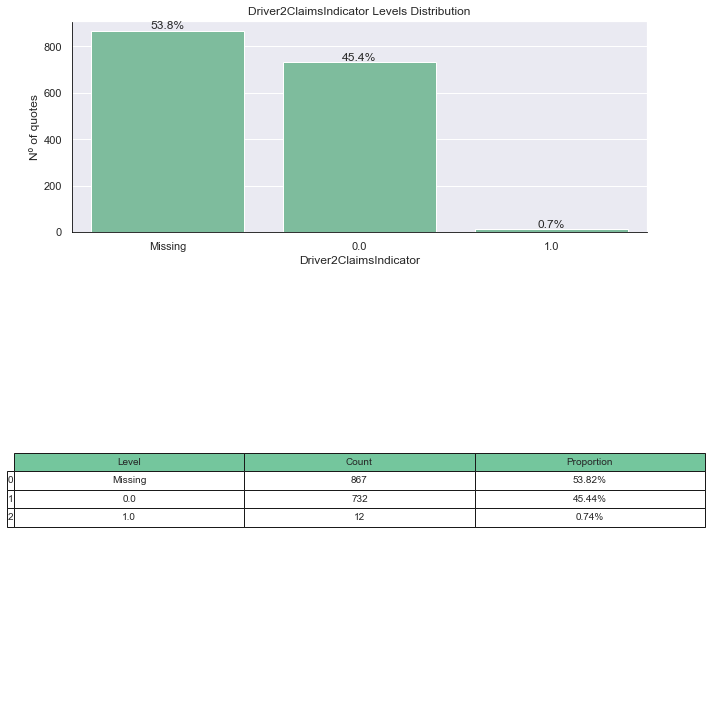


Driver2EmploymentStatus


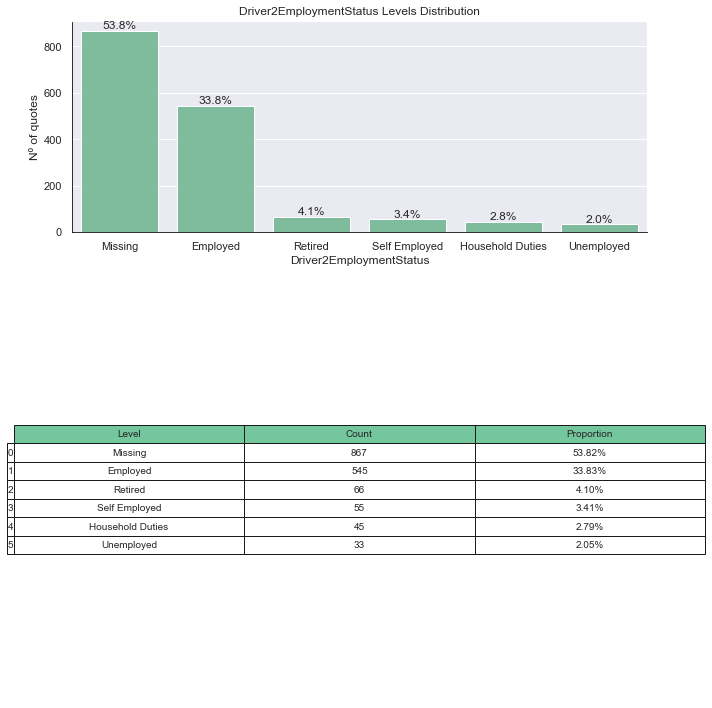


Driver2LicenceCountry


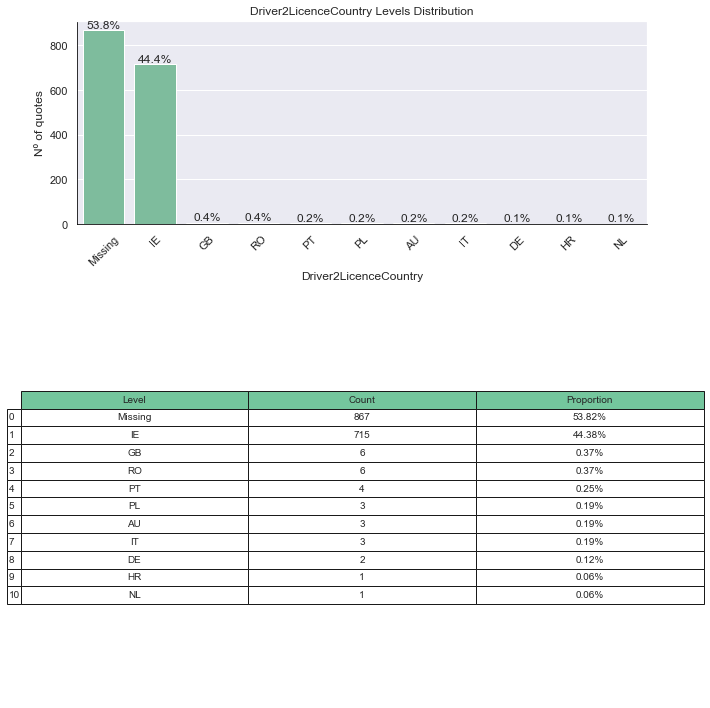


Driver2LicenceType


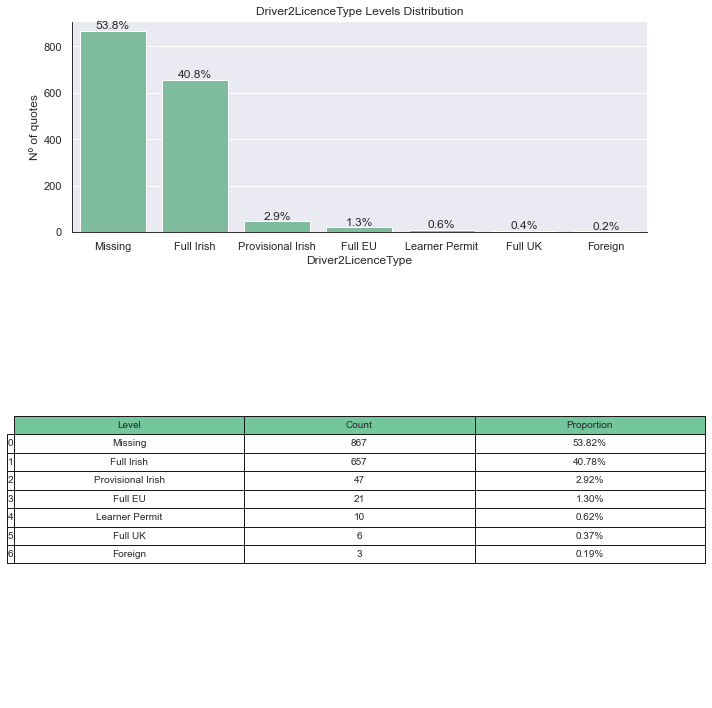


Driver2RelationshipToProposer


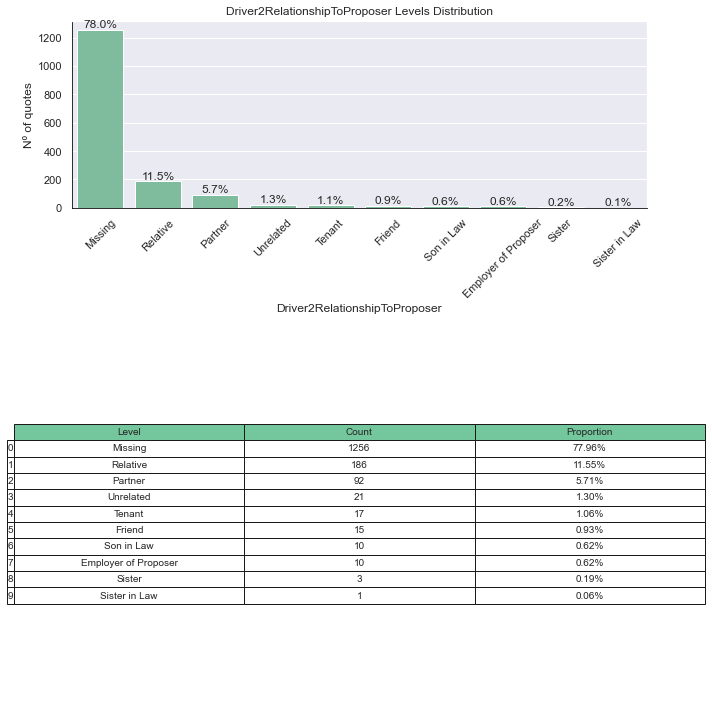


EmploymentStatus


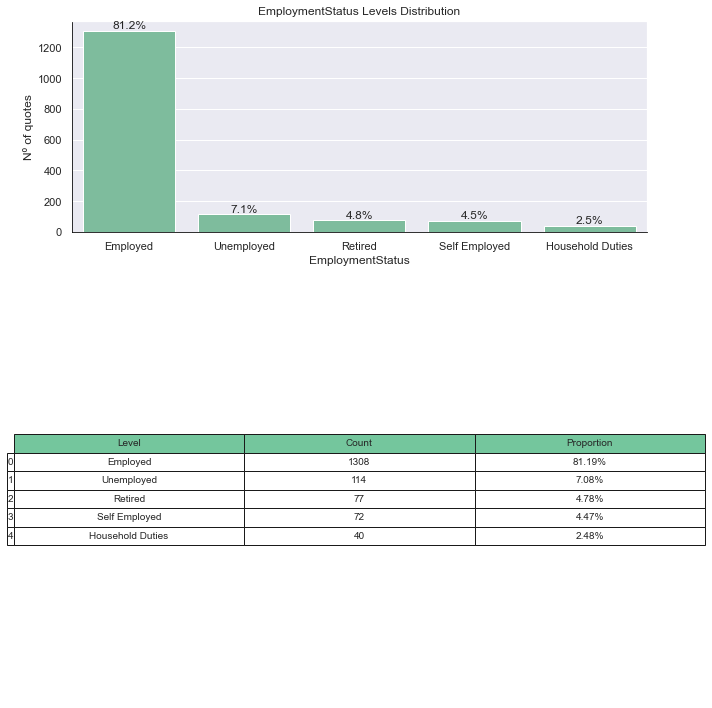


HomeOwner


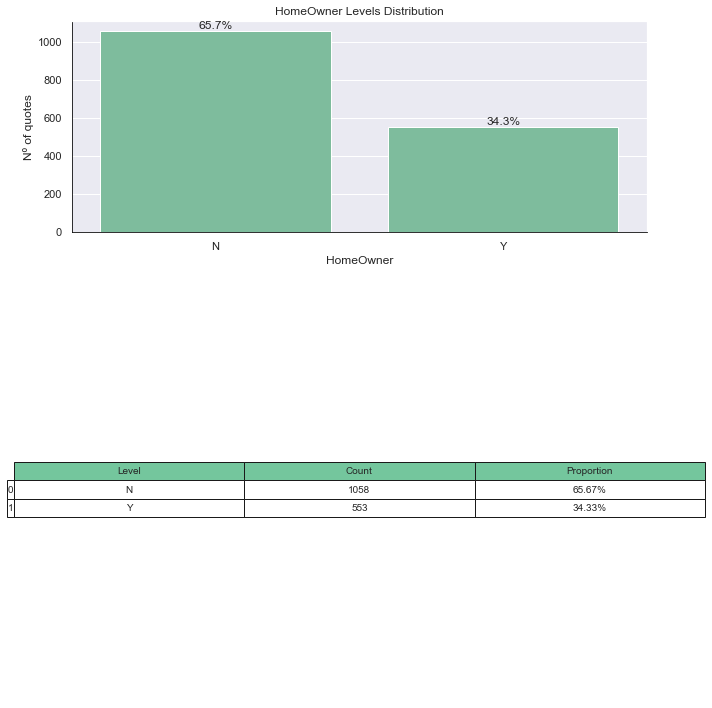


IsDirectDebit


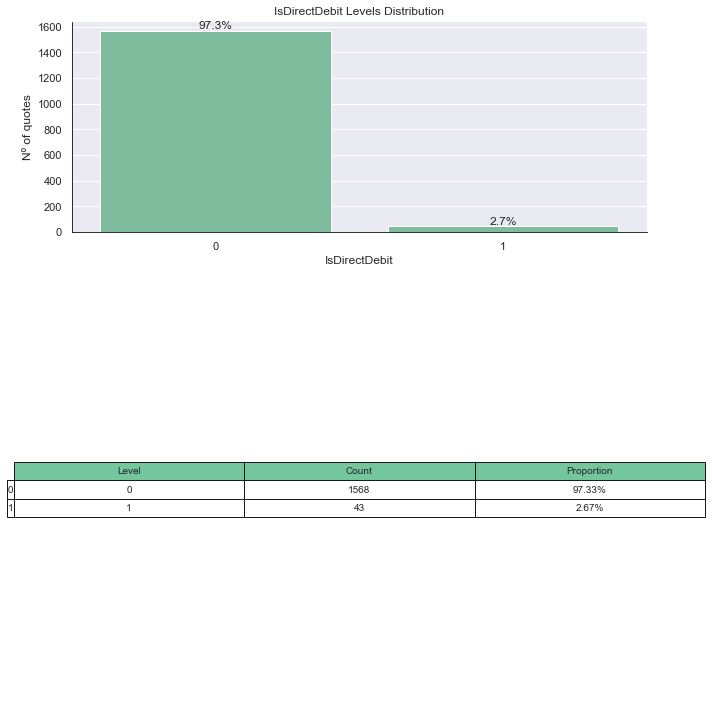


LicenceCountry


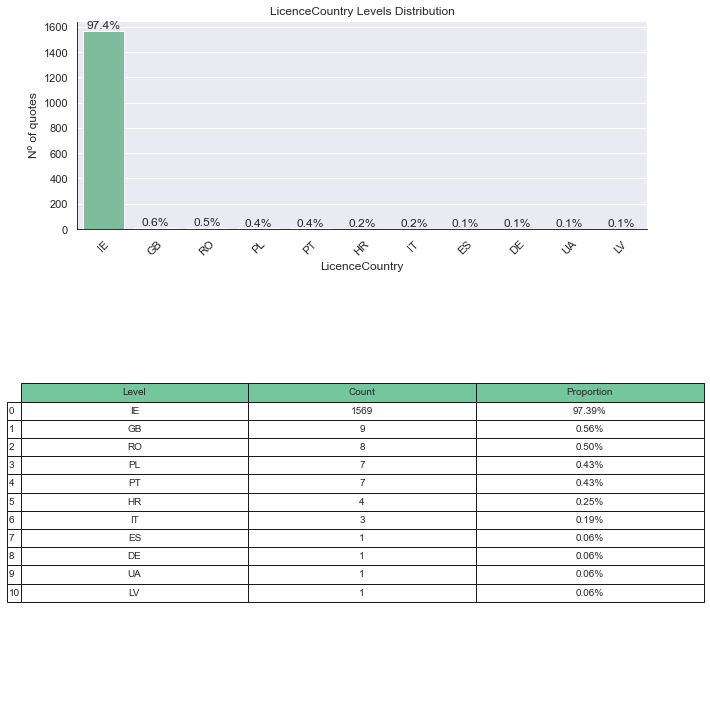


LicenceType


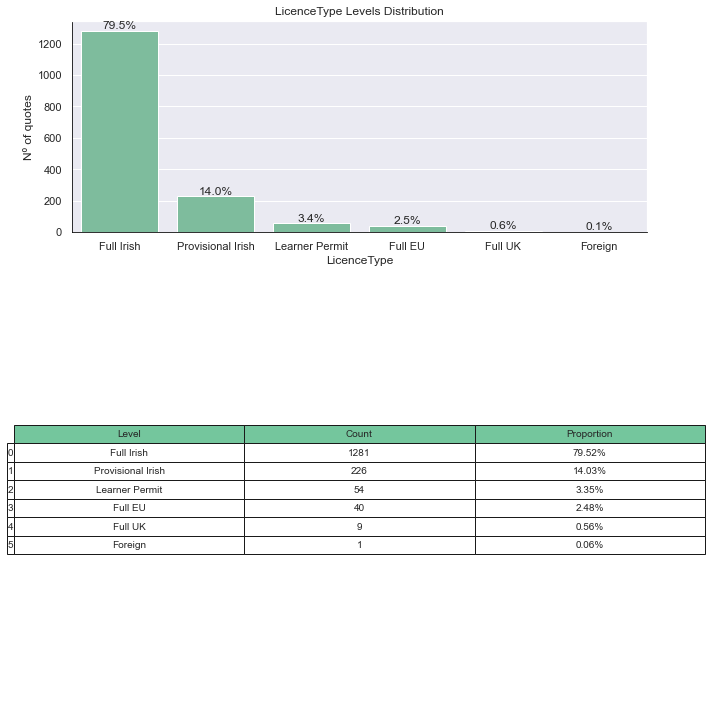


PricingModel


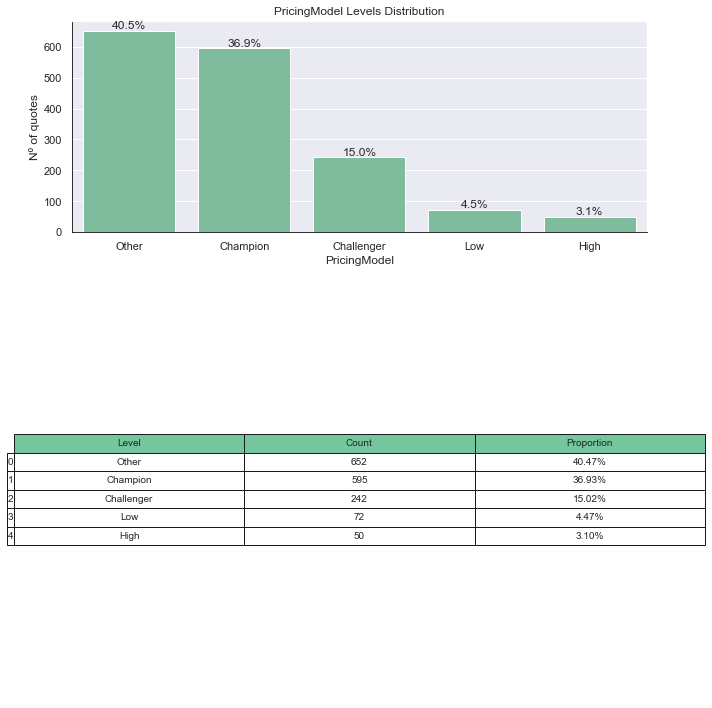


SaleCoverType


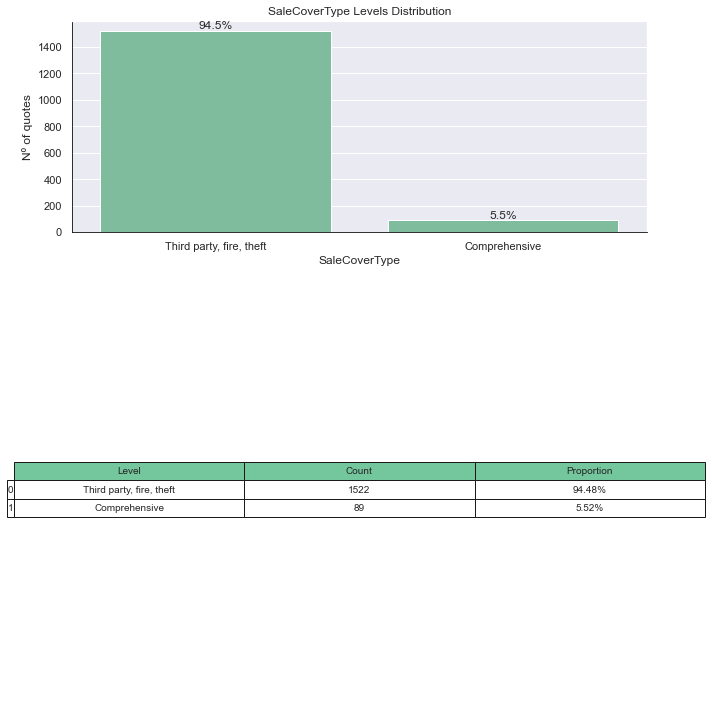


SaleFlag


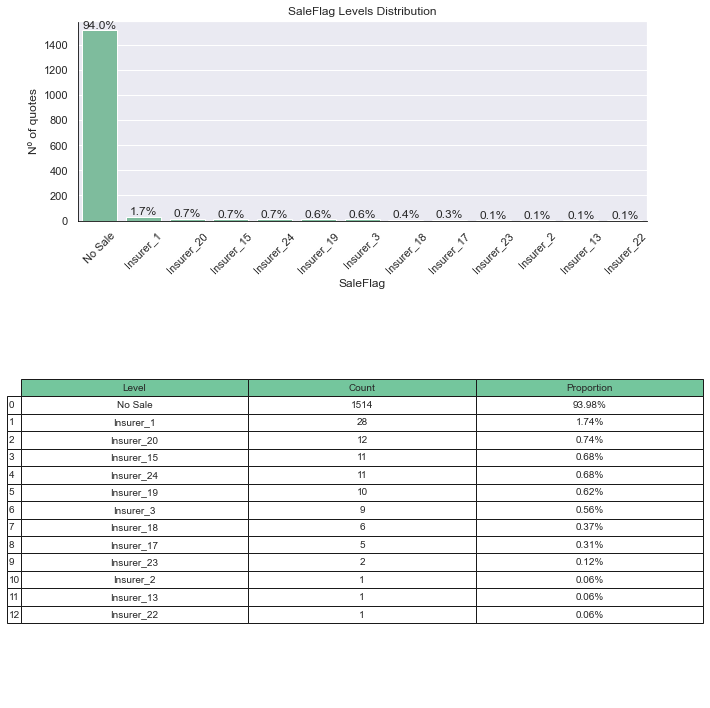


VehicleBodyType


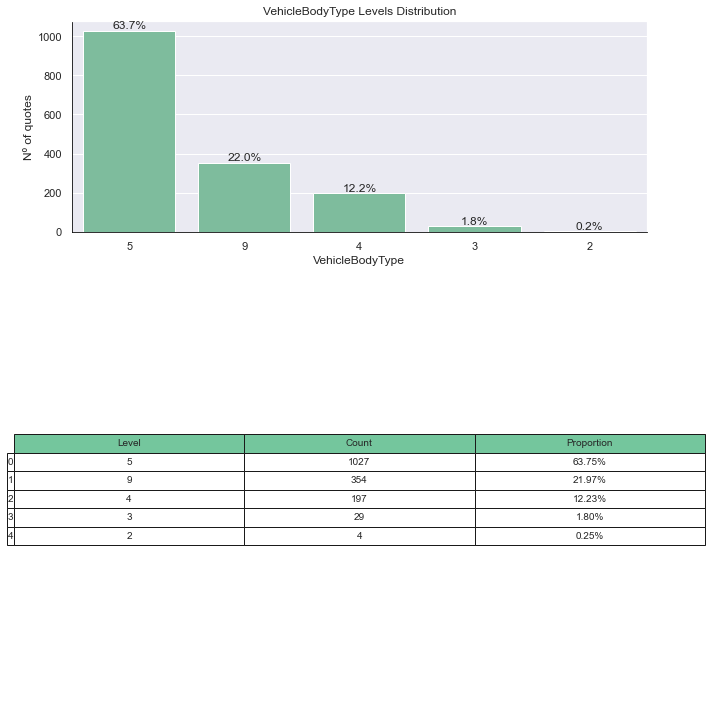


VehicleFuelType


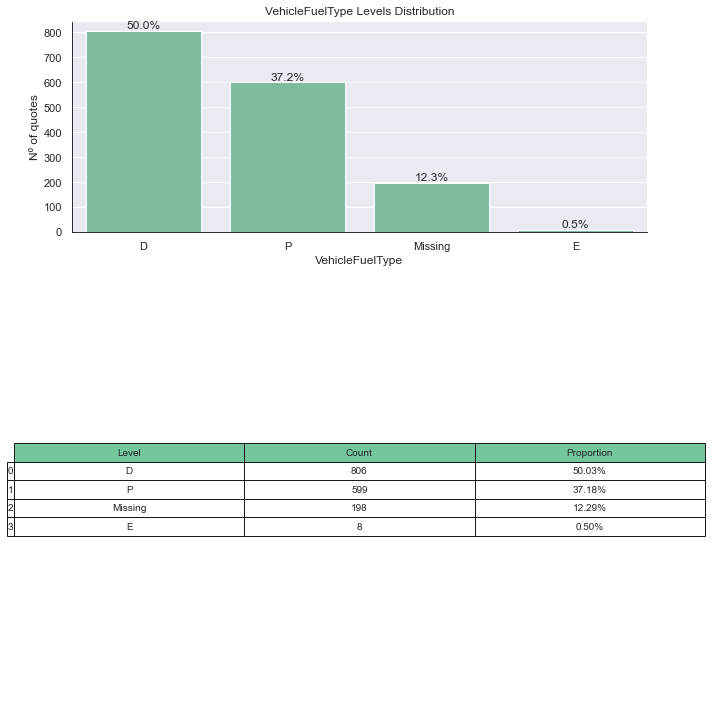


VehicleOvernightLocation


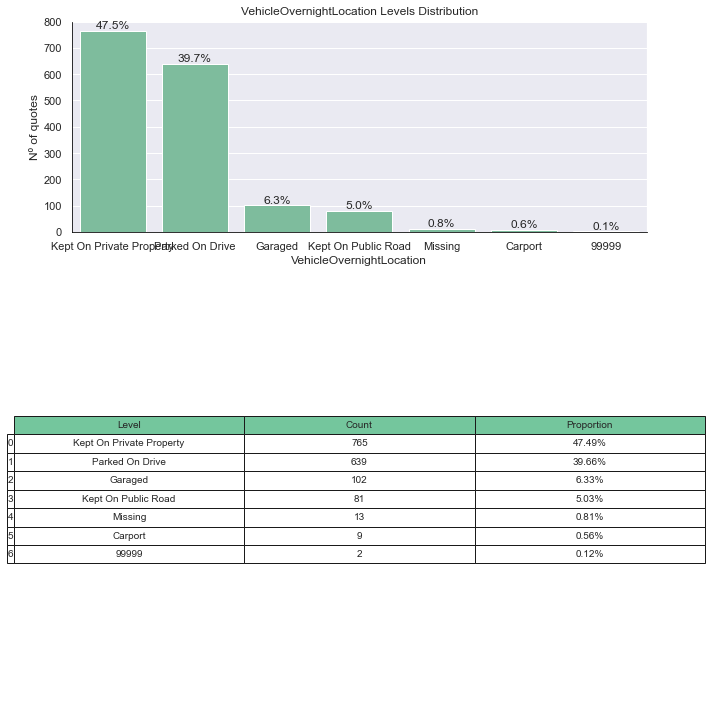

In [41]:
to_include=['IsDirectDebit',
            'ClaimsIndicator',
            'Driver2ClaimsIndicator'
            ]

to_exclude=['Driver1RelationshipToProposer',
            'Driver2VehicleDrivingFrequency'
            ]

cat_analysis(data_clean, include=to_include,exclude=to_exclude)

From these analysis we can conclude the following:
+ For AddressLine4, variable as they are the counties even if some levels have very low nº of quotes, each represent a county so I wouldn't make sense to group at this point
+ For VehicleFuelType, as missing values are not a lot, they could be assigned to Diesel level as it's the majority class. Also as Electric class, is so insignificant we will assign it to the majority class renaming it as *D+E*
+ For VehicleOvernightLocation, as missing values (99999 level too) are not a lot, they could be assigned to the majority class. Also due to they low proportion and their similar nature *Carport* will be assigned to *Garaged* level
+ For VehicleBodyType, it is not clear if we should group any level. Let's check in more detailed below
+ For EmploymentStatus, it looks fine
+ For LicenceType, the levels *Full EU*, *Full UK* and *Foreign* as they are so residual but different from the other 3 as they are international permits we will cluster them in a single category as *International* 
+ For LicenceCountry, the countries that are not Ireland will be grouped and other as they are quite inmaterial
+ Driver1RelationshipToProposer as mentioned in the initial analysis should be excluded as there is no variability
+ For Driver1VehicleDrivingFrequency, it is not clear as it looks to be a very similar variable as milage.  Let's check in more detailed below
+ For Driver2RelationshipToProposer, half of the values when there is driver2 in relationship to proposer are missing. As such, we will exclude it
+ For Driver2LicenceType, Driver2LicenceCountry, Driver2EmploymentStatus and Driver2VehicleDrivingFrequency, we exclude them as they have many missing and they have a similar distribution to Driver 1 one
+ For SaleFlag, it's the target variable we will create a new boolen variable with just sale or no sale levels. We note that only 6% of the quotes are converted
+ For SaleCoverType, we will keep it as it is. We note that almost 95% is non-comprenhensive
+ For HomeOwner, we will keep it as it is. 34% are homeowners
+ For PricingModel, it looks to be the models used to calculate the predicted market price variable to do A/B test

When mentioned that any variable grouping, this is done in [1.6. Feature Engineering & Exclusion](#id16). 

Regarding the variable *VehicleBodyType*, we are going to see how different this vehicles type are in relation to the other vehicle variables.

In [42]:
# we calculate the VehicleAge variable
data_clean['VehicleAge'] = data_clean['PolicyInceptionDate'].dt.year - data_clean['VehicleDateManufactured'].dt.year

# we create the summary table including missing values
summary_table = data_clean['VehicleBodyType'].value_counts(dropna=False).reset_index()
summary_table.columns = ['Level', 'Count']
summary_table['Proportion'] = summary_table['Count'] / len(data_clean['VehicleBodyType']) * 100
summary_table['Proportion'] = summary_table['Proportion'].apply(lambda x: f'{x:.2f}%')

# we replace NaN with 'Missing' in the summary table for display purposes
summary_table['Level'] = summary_table['Level'].astype(str).replace('nan', 'Missing')

# we calculate the average for each level
averages = data_clean.groupby('VehicleBodyType').agg(
    AvgVeh_Value=('VehicleValue', 'mean'),
    AvgVeh_EngineCapacity=('VehicleEngineCapacity', 'mean'),
    AvgVeh_Age=('VehicleAge', 'mean')
).reset_index().round(1)

# Replace NaN with 'Missing' in the averages for display purposes
averages['VehicleBodyType'] = averages['VehicleBodyType'].astype(str).replace('nan', 'Missing')

#we merge the tables
summary_table = summary_table.merge(averages, how='left', left_on='Level', right_on='VehicleBodyType').drop(
                columns=['VehicleBodyType'])

# we drop the calculated variable
data_clean.drop(columns=['VehicleAge'], inplace=True)

summary_table

Level  Count Proportion  AvgVeh_Value  AvgVeh_EngineCapacity  AvgVeh_Age
0     5   1027     63.75%        9729.0                 1436.5        10.2
1     9    354     21.97%       11586.2                 1804.8        10.3
2     4    197     12.23%       16891.0                 1748.1         8.3
3     3     29      1.80%       10050.0                 2038.9        13.1
4     2      4      0.25%       14125.0                 2139.0        14.8

As we can observe, level 2 and 3 are so residual that we will assign to the majority class. However, level 4 and 9 should be kept separated as they look different from the rest at least in terms of vehicle value.

We are going to do a more detailed analysis on the county variable to check its distribution in the map and compare with the real distribution.

To do this we are going to do the following steps:
+ First, we import an Ireland counties json file found on the internet ([Ireland Counties JSON](https://gist.github.com/vool/969e3be0cfac519560755cce0b91e097#file-ireland-geojson))
+ Afterwards, we create a table with the quotes by counties in proportion
+ Then, we create manually a dataset with the Irish counties and the population in each of them from this website ([Counties by pop](http://homepage.tinet.ie/~cronews/geog/census/copop.html))

In [43]:
# we import the json with the map of Ireland counties
geojson_path = 'ireland.geojson'
gdf = gpd.read_file(geojson_path)

In [44]:
# we create the dataframe of the current proportions in the quotes
county_counts = data_clean['AddressLine4'].value_counts(normalize=True).reset_index()
county_counts.columns = ['County', 'Count']

county_counts['Count']=(county_counts.Count*100).round(1)

counties_to_remove = ['z) Other', 'Down']
county_counts = county_counts[~county_counts['County'].isin(counties_to_remove)]

# we create a table with the Irish counties real population proportions
data = [
    ('Dublin', 28.7),
    ('Antrim', 0),
    ('Cork', 11.4),
    ('Down', 0),
    ('Derry', 0),
    ('Galway', 5.3),
    ('Limerick', 4.5),
    ('Kildare', 4.2),
    ('Tyrone', 0),
    ('Tipperary', 3.6),
    ('Donegal', 3.5),
    ('Meath', 3.4),
    ('Kerry', 3.4),
    ('Armagh', 0),
    ('Mayo', 3),
    ('Wexford', 3),
    ('Wicklow', 2.9),
    ('Clare', 2.6),
    ('Louth', 2.6),
    ('Waterford', 2.6),
    ('Kilkenny', 2.1),
    ('Westmeath', 1.8),
    ('Offaly', 1.6),
    ('Laois', 1.5),
    ('Sligo', 1.5),
    ('Cavan', 1.4),
    ('Fermanagh', 0),
    ('Roscommon', 1.4),
    ('Monaghan', 1.3),
    ('Carlow', 1.2),
    ('Longford', 0.8),
    ('Leitrim', 0.7)

]

county_pop_prop = pd.DataFrame(data, columns=['County', 'Count'])

Now we plot them and check the differences:

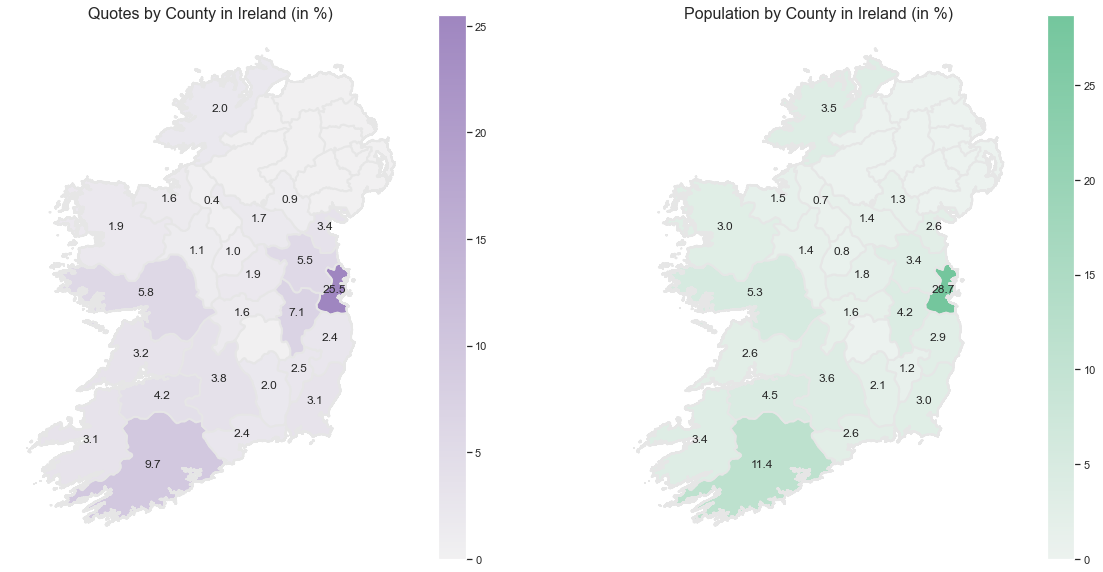

In [45]:
# Merge the county counts with the GeoDataFrame
merged_gdf = gdf.merge(county_counts, left_on='NAME_1', right_on='County', how='left')
merged_gdf['Count'] = merged_gdf['Count'].fillna(0)

# Merge the county counts with the GeoDataFrame for population
merged_gdf_pop = gdf.merge(county_pop_prop, left_on='NAME_1', right_on='County', how='left')
merged_gdf_pop['Count'] = merged_gdf_pop['Count'].fillna(0)

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Define the color palette
cmap1 = sns.light_palette(color1, as_cmap=True)
cmap2 = sns.light_palette(color1_2, as_cmap=True)

# Plot the quotes by county
merged_gdf.plot(column='Count', cmap=cmap2, linewidth=2, ax=axes[0], edgecolor='0.9', legend=True)
axes[0].set_title('Quotes by County in Ireland (in %)', fontsize=16)
axes[0].axis('off')
for idx, row in merged_gdf.iterrows():
    if row['Count'] != 0:
        axes[0].annotate(text=row['Count'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=12)

# Plot the population by county
merged_gdf_pop.plot(column='Count', cmap=cmap1, linewidth=2, ax=axes[1], edgecolor='0.9', legend=True)
axes[1].set_title('Population by County in Ireland (in %)', fontsize=16)
axes[1].axis('off')
for idx, row in merged_gdf_pop.iterrows():
    if row['Count'] != 0:
        axes[1].annotate(text=row['Count'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=12)

plt.show()

We can observe that they distribute pretty similarly and that this quotes are not following a different geographical distribution than the natural one from the population density. 

Looking in more detailed the unemployment status, it looks to be a declarative variable when quoting online and some categories such as the *unemployed* one maybe overstated as there are regulatory discounts from being declared *unemployed* and this would make us say this variable as less reliable.

In [46]:
data_clean.EmploymentStatus.value_counts(normalize=True).round(4)*100

Employed            81.19
Unemployed           7.08
Retired              4.78
Self Employed        4.47
Household Duties     2.48
Name: EmploymentStatus, dtype: float64

Currently Ireland unemployment rate is 4.4% ([this source](https://www.irishtimes.com/business/2024/05/01/unemployment-rate-jumps-most-in-two-years/#:~:text=The%200.3%25%20rise%20is%20the%20biggest%20monthly%20increase%20since%20March%202022&text=The%20unemployment%20rate%20rose%20last,Office%20said%20in%20a%20statement.)). We are going to do a hypotesis testing at the 95% confidence level to check if it makes sense or not:
+ Null Hypothesis ($H_0$): The sample proportion is equal to the population proportion ($4.4%$).
+ Alternative Hypothesis ($H_1$): The sample proportion is not equal to the population proportion ($4.4%$).

In [47]:
# we get the value of the sample and state the population proportion
sample_prop=data_clean.EmploymentStatus.value_counts(normalize=True)['Unemployed']
pop_prop = 0.044

# Standard error calculation
standard_error = np.sqrt(pop_prop * (1 - pop_prop) / len(data_clean))

# Z-score calculation
z_score = (sample_prop - pop_prop) / standard_error

# P-value calculation (two-tailed test)
p_value = 2 * stats.norm.cdf(-abs(z_score))

# Hypothesis test result
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("We reject the null hypothesis: The proportions are significantly different.")
else:
    print("We fail to reject the null hypothesis: The proportions are not significantly different.")

P-Value: 1.626454249684821e-07
We reject the null hypothesis: The proportions are significantly different.


We can observe that the null hypotesis is rejected and as such, we cannot be very confident about the distribution of this variable. Probably this is a declarative variable. Still we will keep it.

Moreover, regarding the variable *Driver1VehicleDrivingFrequency*, it looks to be pretty similar in concept to the milage one seen before to explain the usage of the car. Besides this variable is not asked in the online quotation process. To see if it make sense with the milage lets do a milage density plot by the frequency usage levels after grouping it:

In [48]:
# we check again the levels
data_clean.Driver1VehicleDrivingFrequency.value_counts(normalize=True).round(4)*100

Main                   77.24
Infrequent (Casual)    16.73
Frequent                5.71
Temporary               0.26
3                       0.06
Name: Driver1VehicleDrivingFrequency, dtype: float64

In [49]:
# first we assign to the majority class the missing and residual classes
data_clean['Driver1VehicleDrivingFrequency'] = data_clean['Driver1VehicleDrivingFrequency'].astype(str).replace('nan', np.nan)
data_clean['Driver1VehicleDrivingFrequency'] = (data_clean['Driver1VehicleDrivingFrequency']
                                                .replace({'Temporary': 'Main', 
                                                          '3': 'Main'}).fillna('Main')
                                               )
# we check the change
data_clean.Driver1VehicleDrivingFrequency.value_counts(normalize=True).round(4)*100

Main                   78.52
Infrequent (Casual)    16.01
Frequent                5.46
Name: Driver1VehicleDrivingFrequency, dtype: float64

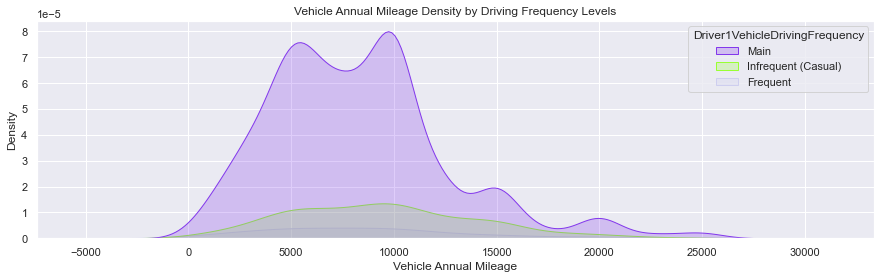

In [50]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15, 4))

# density plot
sns.kdeplot(data=data_clean, x='VehicleAnnualMileage', hue='Driver1VehicleDrivingFrequency', 
            fill=True, common_norm=True,palette=colors3_2)

# we set the title and labels
plt.title('Vehicle Annual Mileage Density by Driving Frequency Levels')
plt.xlabel('Vehicle Annual Mileage')
plt.ylabel('Density')

plt.show()

As we can observe the frequency variable doesn't make much sense and as it doesn't come from the online quotation process and is so desligated from the milage we will remove it.

### <font color="#5e548e">1.5. Feature Engineering & Exclusion</font> <a name="id15"></a>

[Go to Table of Content](#ToC)

We will create the following variables to enrich the dataset for the future analysis and model creation:

In [51]:
# we create the days to inception variable
data_clean['POL_days_to_incep'] = data_clean.PolicyInceptionDate-data_clean.WorkDate
data_clean['POL_days_to_incep'] = data_clean['POL_days_to_incep'].dt.days

# we create the sum of the NCD variables
data_clean['DRI_1_NCD_total_years'] = data_clean.NCDClaimedYearsEarned + data_clean.NCDDrivingExperienceYears

# we calculate the vehicle age at inception date
data_clean['VEH_age'] = data_clean.PolicyInceptionDate.dt.year - data_clean.VehicleDateManufactured.dt.year

# we create the composite variable of claims of driver 1 and driver 2
data_clean['DRI_sum_claim'] = data_clean.apply(lambda row: 
                                               row['ClaimsIndicator'] if pd.isna(row['Driver2ClaimsIndicator']) 
                                               else (1 if (row['Driver2ClaimsIndicator'] + row['ClaimsIndicator']) > 0 else 0),
                                            axis=1)

# we create the minimum age of driver 1 and driver 2 (it is usually the highest risk)
data_clean['DRI_min_age'] = np.minimum(data_clean.Driver1Age,data_clean.Driver2Age.fillna(data_clean['Driver1Age'])).astype(int)

# we calculate a boolen variable of if there is driver 2 or not
data_clean['DRI_2_flag'] = data_clean['Driver2Age'].notna().astype(int)

# lowest panel price
data_clean['MOD_lowest_price']=data_clean[['Insurer_1CustomerPrice','Insurer_2CustomerPrice',
                                          'Insurer_3CustomerPrice','Insurer_4CustomerPrice']].min(axis=1)

# we calculate the sale binary variable
data_clean['MOD_sale'] = np.where(data_clean.SaleFlag == "No Sale", 0, 1)

# we calculate the competitive variable 
# The higher the more competitive it's the lower price of the panel compared to the market price
data_clean['MOD_competitive'] = data_clean.MarketPricePrediction / data_clean.MOD_lowest_price

Besides, as we showed in the categorical univariate analysis, we are going to do the following groupings:

In [52]:
# we group and assign the missing to the mayoriy class for the vehicle fuel
data_clean['VehicleFuelType'] = data_clean['VehicleFuelType'].replace({'D': 'D+E', 
                                                                       'E': 'D+E'}).fillna('D+E')

# we assign the missing to the mayoriy class for the vehicle doors and change to string variable
data_clean['VehicleDoors']=data_clean['VehicleDoors'].fillna(5).astype(str)

# we group and assign the missing to the mayoriy class for the VehicleOvernightLocation
data_clean['VehicleOvernightLocation'] = data_clean['VehicleOvernightLocation'].astype(str).replace('nan', np.nan)
data_clean['VehicleOvernightLocation'] = data_clean['VehicleOvernightLocation'].replace({'99999': 'Kept On Private Property', 
                                                                                         'Carport': 'Garaged'}
                                                                                       ).fillna('Kept On Private Property')

# we assign to the mayoriy class the residual classes for the VehicleBodyType
data_clean['VehicleBodyType'] = data_clean['VehicleBodyType'].replace({'2': '5', 
                                                                       '3': '5'})
# we group residual classes to a new one category  for the LicenceType
data_clean['LicenceType'] = data_clean['LicenceType'].replace({'Full EU': 'International', 
                                                                       'Full UK': 'International',
                                                                      'Foreign': 'International'})

# we assign everything that is not IE to other for the VehicleBodyType
data_clean['LicenceCountry'] = data_clean['LicenceCountry'].apply(lambda x: x if x == 'IE' else 'others')

In [53]:
# we check if the groupings have been done correctly
print(data_clean['VehicleFuelType'].value_counts())
print(data_clean['VehicleDoors'].value_counts())
print(data_clean['VehicleOvernightLocation'].value_counts())

D+E    1012
P       599
Name: VehicleFuelType, dtype: int64
5.0    1134
4.0     334
3.0     110
2.0      33
Name: VehicleDoors, dtype: int64
Kept On Private Property    780
Parked On Drive             639
Garaged                     111
Kept On Public Road          81
Name: VehicleOvernightLocation, dtype: int64


After having done all the previous steps of the EDA we can determine which variables we should exclude due being empty, being not very reliable or having a very small variance:

In [54]:
#variables to exclude:
var_exclude =[
    "EffectiveDate", # always the same data
    "WorkDate", # only used for calculating POL_days_to_incep
    "QuoteDriverId1", # just driver licence ID
    "QuoteDriverId2", # just driver licence ID
    "PolicyInceptionDate", # only used for calculating POL_days_to_incep
    "ProposerYearsAtHomeAddress", # only filled with 0
    "VehicleCode", # only vehicle code so no usefulness
    "VehicleDateManufactured", # only used for calculating VEH_age
    "VehicleImported", # always filled with 0
    "VehicleSeats", # always filled with 5
    "CarsInHouseHold", # always empty
    "VoluntaryExcess", # always filled with 0
    "Driver1RelationshipToProposer", # lways filled out with "proposer"
    "Driver1VehicleDrivingFrequency", # not asked in quotation process and looks to be unrelated with milage
    "Driver2RelationshipToProposer", # Half of the values when there is driver2 in relationship to proposer are missing
    "Driver2Age", # We exclude as we are using the min age of both already to incorporate this info
    "Driver2LicenceType", # We exclude as many missing and Similar distribution to Driver 1
    "Driver2LicenceCountry", # We exclude as many missing and Similar distribution to Driver 1
    "Driver2LicenceDate", # used for vehicle age
    "Driver2EmploymentStatus",  # We exclude as many missing and Similar distribution to Driver 1
    "Driver2VehicleDrivingFrequency", # Always filled out with a "frequent"
    "Driver2ClaimsIndicator", # Already incorporate in the variable for both driver 1 and driver 2
    "Insurer_4GrossPremCompStepAnnual", # always filled with 0
    "Insurer_4NetPremCompStepAnnual", # always filled with 0
    "Insurer_4FeePremCompStepAnnual", # always filled with 0
    "Insurer_4CommissionCompStepAnnual", # always filled with 0
    "Insurer_4DiscountCompStep", # always filled with 0
    "Insurer_4IncomeIfSold", # always filled with 0
    "Insurer_4CustomerPrice" # always filled with 0   
]

# we exclude the variables
data_final = data_clean.drop(columns=var_exclude)

In [55]:
# we check we have all of the variables we want
for col in data_final.columns:
    print(col)

AddressLine4
NCDClaimedYearsEarned
NCDDrivingExperienceYears
VehicleValue
VehicleAnnualMileage
VehicleEngineCapacity
VehicleFuelType
VehicleDoors
VehicleOvernightLocation
VehicleBodyType
EmploymentStatus
LicenceType
LicenceCountry
ClaimsIndicator
Driver1Age
Insurer_1GrossPremCompStepAnnual
Insurer_1NetPremCompStepAnnual
Insurer_1FeePremCompStepAnnual
Insurer_1CommissionCompStepAnnual
Insurer_1DiscountCompStep
Insurer_1IncomeIfSold
Insurer_1CustomerPrice
Insurer_2GrossPremCompStepAnnual
Insurer_2NetPremCompStepAnnual
Insurer_2FeePremCompStepAnnual
Insurer_2CommissionCompStepAnnual
Insurer_2DiscountCompStep
Insurer_2IncomeIfSold
Insurer_2CustomerPrice
Insurer_3GrossPremCompStepAnnual
Insurer_3NetPremCompStepAnnual
Insurer_3FeePremCompStepAnnual
Insurer_3CommissionCompStepAnnual
Insurer_3DiscountCompStep
Insurer_3IncomeIfSold
Insurer_3CustomerPrice
SaleFlag
IsDirectDebit
SaleCoverType
HomeOwner
PricingModel
MarketPricePrediction
POL_days_to_incep
DRI_1_NCD_total_years
VEH_age
DRI_sum_clai

Now we will rename the variables we have to make the more readable and manageble:

In [56]:
# we rename the variables
data_final.rename(columns={
'QuoteQueryId' :  'QuoteID',
'AddressLine4' :  'GEO_county',
'NCDClaimedYearsEarned' :  'DRI_1_NCD_years_main',
'NCDDrivingExperienceYears' :  'DRI_1_NCD_years_sec',
'VehicleValue' :  'VEH_value',
'VehicleAnnualMileage' :  'POL_mileage',
'VehicleEngineCapacity' :  'VEH_eng_size',
'VehicleFuelType' :  'VEH_fuel',
'VehicleDoors' :  'VEH_doors',
'VehicleOvernightLocation' :  'POL_park',
'VehicleBodyType' :  'VEH_type',
'EmploymentStatus' :  'DRI_1_empl_status',
'LicenceType' :  'DRI_1_lic_type',
'LicenceCountry' :  'DRI_1_lic_count',
'ClaimsIndicator' :  'DRI_1_claim',
'Driver1Age' :  'DRI_1_age',
'Driver2RelationshipToProposer' :  'DRI_2_relation',
'Driver2Age' :  'DRI_2_age',
'Driver2LicenceType' :  'DRI_2_lic_type',
'Driver2LicenceCountry' :  'DRI_2_lic_count',
'Driver2EmploymentStatus' :  'DRI_2_empl_status',
'Driver2ClaimsIndicator' :  'DRI_2_claim',
'Insurer_1GrossPremCompStepAnnual' :  'QUO_1_GWP',
'Insurer_1NetPremCompStepAnnual' :  'QUO_1_NWP',
'Insurer_1FeePremCompStepAnnual' :  'QUO_1_fee',
'Insurer_1CommissionCompStepAnnual' :  'QUO_1_comm',
'Insurer_1DiscountCompStep' :  'QUO_1_disc',
'Insurer_1IncomeIfSold' :  'QUO_1_income',
'Insurer_1CustomerPrice' :  'QUO_1_price',
'Insurer_2GrossPremCompStepAnnual' :  'QUO_2_GWP',
'Insurer_2NetPremCompStepAnnual' :  'QUO_2_NWP',
'Insurer_2FeePremCompStepAnnual' :  'QUO_2_fee',
'Insurer_2CommissionCompStepAnnual' :  'QUO_2_comm',
'Insurer_2DiscountCompStep' :  'QUO_2_disc',
'Insurer_2IncomeIfSold' :  'QUO_2_income',
'Insurer_2CustomerPrice' :  'QUO_2_price',
'Insurer_3GrossPremCompStepAnnual' :  'QUO_3_GWP',
'Insurer_3NetPremCompStepAnnual' :  'QUO_3_NWP',
'Insurer_3FeePremCompStepAnnual' :  'QUO_3_fee',
'Insurer_3CommissionCompStepAnnual' :  'QUO_3_comm',
'Insurer_3DiscountCompStep' :  'QUO_3_disc',
'Insurer_3IncomeIfSold' :  'QUO_3_income',
'Insurer_3CustomerPrice' :  'QUO_3_price',
'SaleFlag' :  'MOD_sale_comp',
'IsDirectDebit' :  'POL_paym_monthly',
'SaleCoverType' :  'POL_cover',
'HomeOwner' :  'POL_homeowner',
'PricingModel' :  'MOD_model',
'MarketPricePrediction' :  'MOD_mk_price_pred'
}, inplace=True)

We reorder the variables:

In [57]:
for col in data_final.columns:
    print(col)

GEO_county
DRI_1_NCD_years_main
DRI_1_NCD_years_sec
VEH_value
POL_mileage
VEH_eng_size
VEH_fuel
VEH_doors
POL_park
VEH_type
DRI_1_empl_status
DRI_1_lic_type
DRI_1_lic_count
DRI_1_claim
DRI_1_age
QUO_1_GWP
QUO_1_NWP
QUO_1_fee
QUO_1_comm
QUO_1_disc
QUO_1_income
QUO_1_price
QUO_2_GWP
QUO_2_NWP
QUO_2_fee
QUO_2_comm
QUO_2_disc
QUO_2_income
QUO_2_price
QUO_3_GWP
QUO_3_NWP
QUO_3_fee
QUO_3_comm
QUO_3_disc
QUO_3_income
QUO_3_price
MOD_sale_comp
POL_paym_monthly
POL_cover
POL_homeowner
MOD_model
MOD_mk_price_pred
POL_days_to_incep
DRI_1_NCD_total_years
VEH_age
DRI_sum_claim
DRI_min_age
DRI_2_flag
MOD_lowest_price
MOD_sale
MOD_competitive


In [58]:
new_order=[
'DRI_1_age',
'DRI_1_lic_type',
'DRI_1_lic_count',
'DRI_1_claim',
'DRI_1_NCD_years_main',
'DRI_1_NCD_years_sec',
'DRI_1_NCD_total_years',
'DRI_1_empl_status',
'DRI_2_flag',
'DRI_min_age',
'DRI_sum_claim',
'VEH_age',
'VEH_value',
'VEH_eng_size',
'VEH_fuel',
'VEH_type',
'VEH_doors',
'POL_cover',
'POL_days_to_incep',
'POL_mileage',
'POL_paym_monthly',
'POL_park',
'POL_homeowner',
'GEO_county',
'QUO_1_GWP',
'QUO_1_NWP',
'QUO_1_fee',
'QUO_1_comm',
'QUO_1_disc',
'QUO_1_income',
'QUO_1_price',
'QUO_2_GWP',
'QUO_2_NWP',
'QUO_2_fee',
'QUO_2_comm',
'QUO_2_disc',
'QUO_2_income',
'QUO_2_price',
'QUO_3_GWP',
'QUO_3_NWP',
'QUO_3_fee',
'QUO_3_comm',
'QUO_3_disc',
'QUO_3_income',
'QUO_3_price',
'MOD_lowest_price',
'MOD_mk_price_pred',
'MOD_model',
'MOD_competitive',
'MOD_sale',
'MOD_sale_comp'

]

data_final = data_final[new_order]

In [59]:
# we check the variables created
for col in data_final.columns:
    print(col)

DRI_1_age
DRI_1_lic_type
DRI_1_lic_count
DRI_1_claim
DRI_1_NCD_years_main
DRI_1_NCD_years_sec
DRI_1_NCD_total_years
DRI_1_empl_status
DRI_2_flag
DRI_min_age
DRI_sum_claim
VEH_age
VEH_value
VEH_eng_size
VEH_fuel
VEH_type
VEH_doors
POL_cover
POL_days_to_incep
POL_mileage
POL_paym_monthly
POL_park
POL_homeowner
GEO_county
QUO_1_GWP
QUO_1_NWP
QUO_1_fee
QUO_1_comm
QUO_1_disc
QUO_1_income
QUO_1_price
QUO_2_GWP
QUO_2_NWP
QUO_2_fee
QUO_2_comm
QUO_2_disc
QUO_2_income
QUO_2_price
QUO_3_GWP
QUO_3_NWP
QUO_3_fee
QUO_3_comm
QUO_3_disc
QUO_3_income
QUO_3_price
MOD_lowest_price
MOD_mk_price_pred
MOD_model
MOD_competitive
MOD_sale
MOD_sale_comp


In [60]:
# we review the variables a last time
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 56346939 to 56341053
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DRI_1_age              1611 non-null   int64  
 1   DRI_1_lic_type         1611 non-null   object 
 2   DRI_1_lic_count        1611 non-null   object 
 3   DRI_1_claim            1611 non-null   int64  
 4   DRI_1_NCD_years_main   1611 non-null   int64  
 5   DRI_1_NCD_years_sec    1611 non-null   int64  
 6   DRI_1_NCD_total_years  1611 non-null   int64  
 7   DRI_1_empl_status      1611 non-null   object 
 8   DRI_2_flag             1611 non-null   int32  
 9   DRI_min_age            1611 non-null   int32  
 10  DRI_sum_claim          1611 non-null   int64  
 11  VEH_age                1611 non-null   int64  
 12  VEH_value              1611 non-null   float64
 13  VEH_eng_size           1611 non-null   float64
 14  VEH_fuel               1611 non-null   object

### <font color="#5e548e">1.6. Multivariate Analysis</font> <a name="id16"></a>

[Go to Table of Content](#ToC)

We analyze how the different variables distribute by sale variable

In [61]:
to_exclude=[
    'QUO_1_GWP',
    'QUO_1_NWP',
    'QUO_1_fee',
    'QUO_1_comm',
    'QUO_1_disc',
    'QUO_1_income',
    'QUO_1_price',
    'QUO_2_GWP',
    'QUO_2_NWP',
    'QUO_2_fee',
    'QUO_2_comm',
    'QUO_2_disc',
    'QUO_2_income',
    'QUO_2_price',
    'QUO_3_GWP',
    'QUO_3_NWP',
    'QUO_3_fee',
    'QUO_3_comm',
    'QUO_3_disc',
    'QUO_3_income',
    'QUO_3_price',
    'MOD_sale',
    'MOD_sale_comp'
]


DRI_1_age


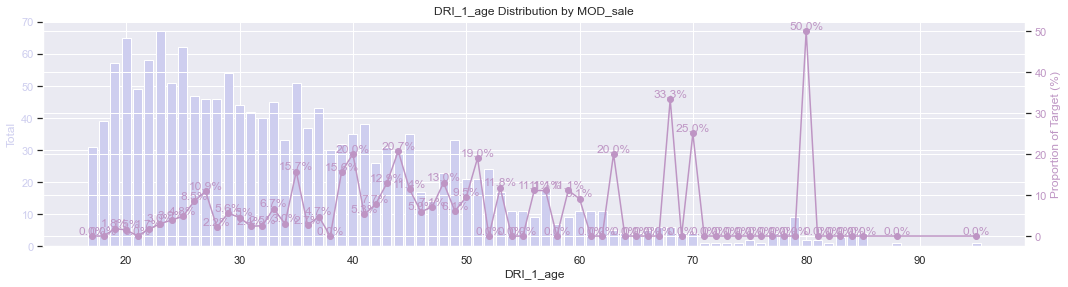


DRI_1_lic_type


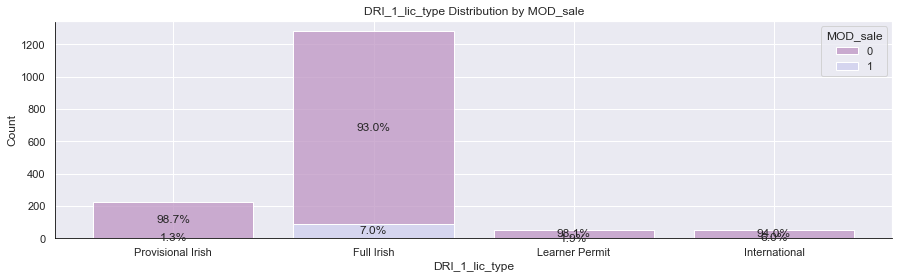


DRI_1_lic_count


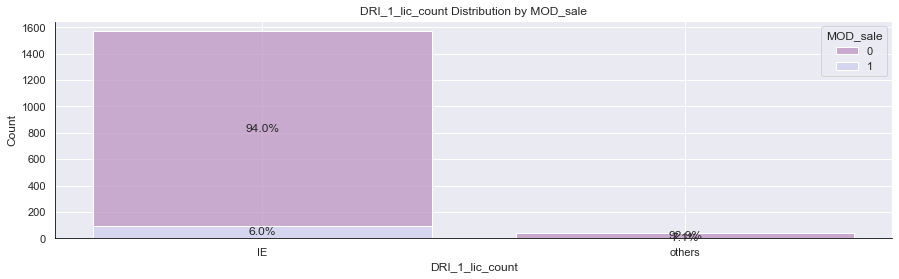


DRI_1_claim


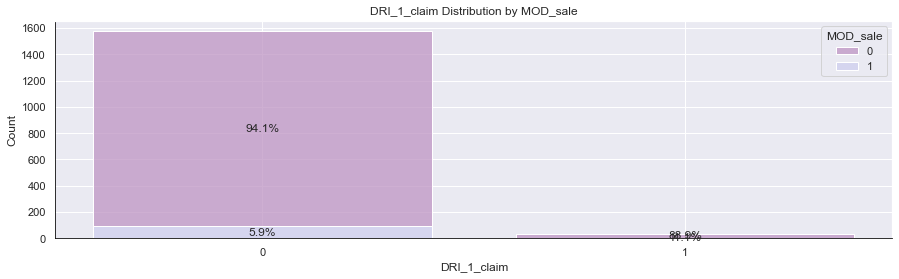


DRI_1_NCD_years_main


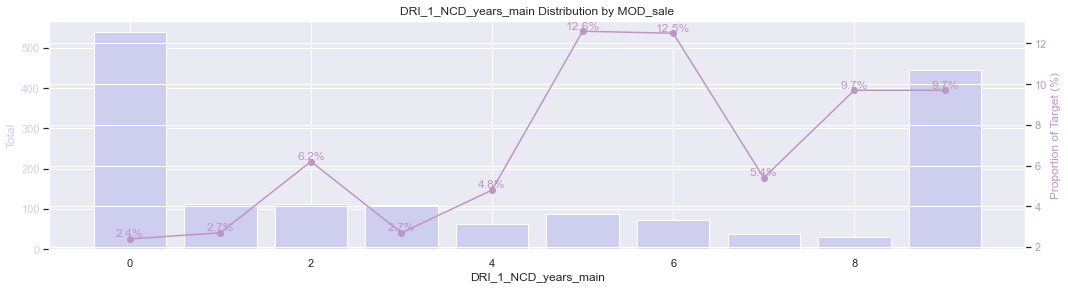


DRI_1_NCD_years_sec


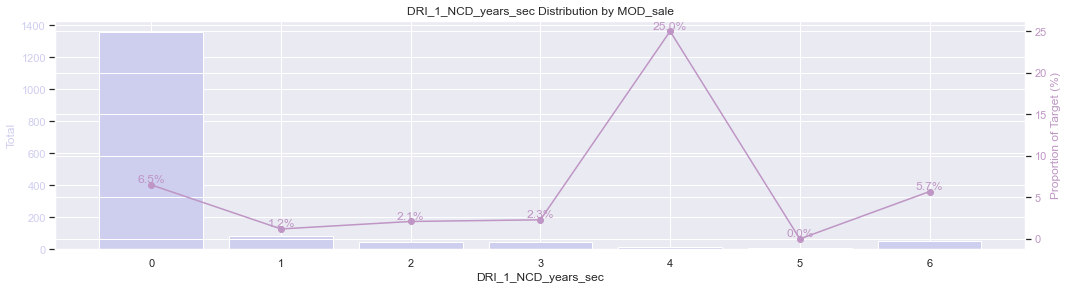


DRI_1_NCD_total_years


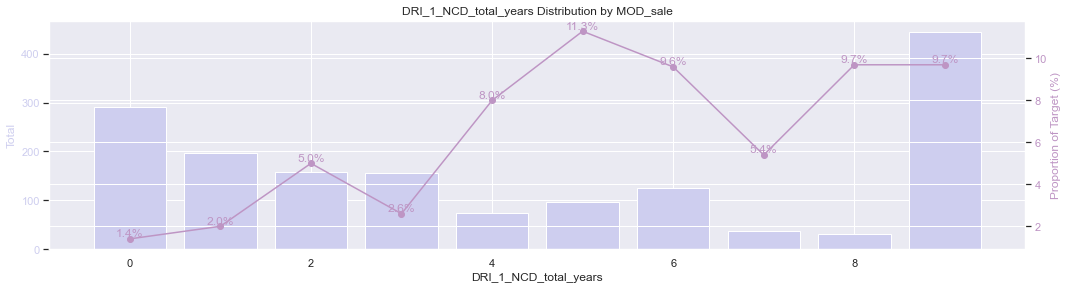


DRI_1_empl_status


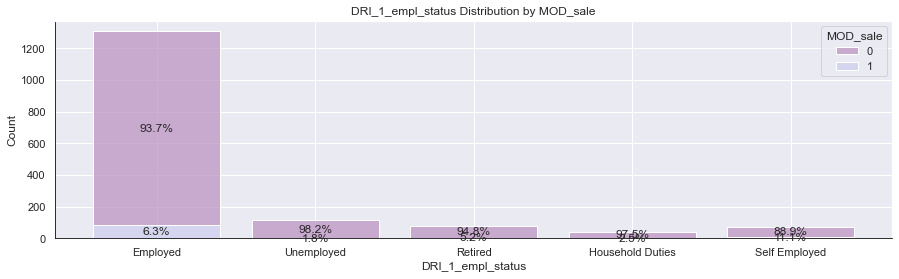


DRI_2_flag


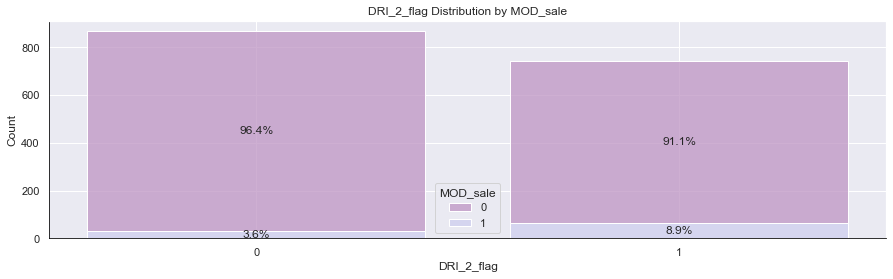


DRI_min_age


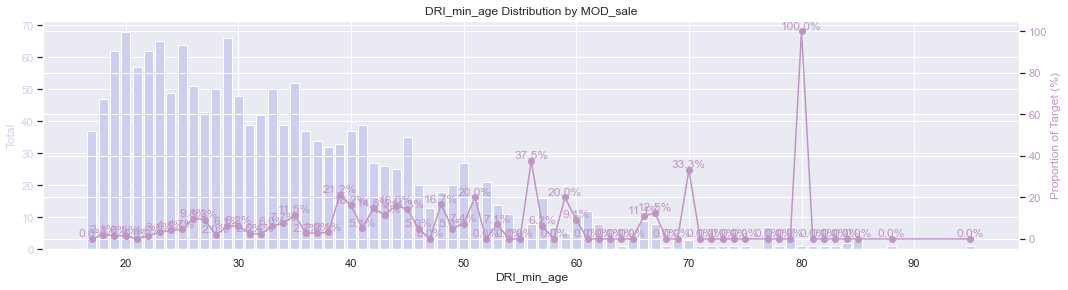


DRI_sum_claim


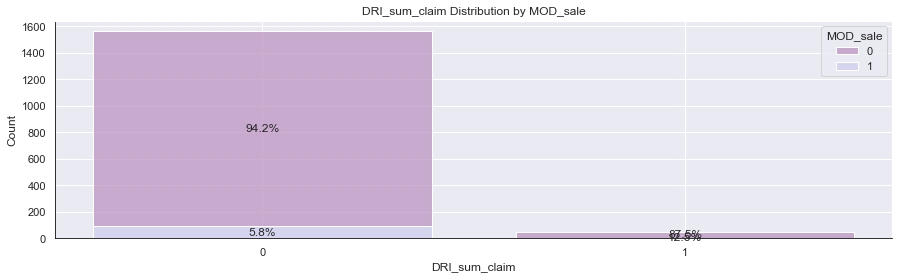


VEH_age


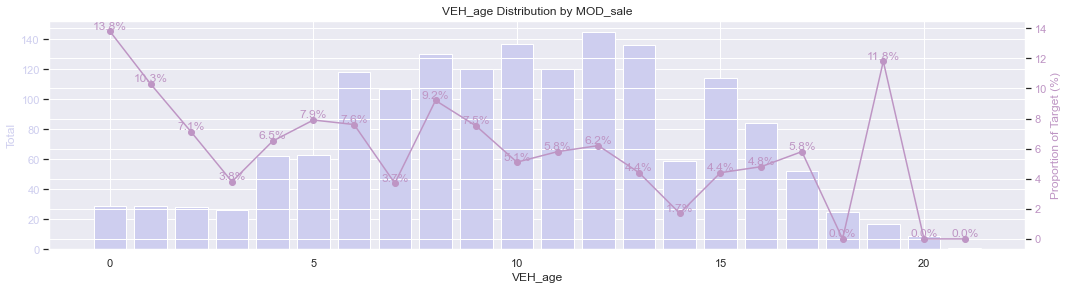


VEH_value


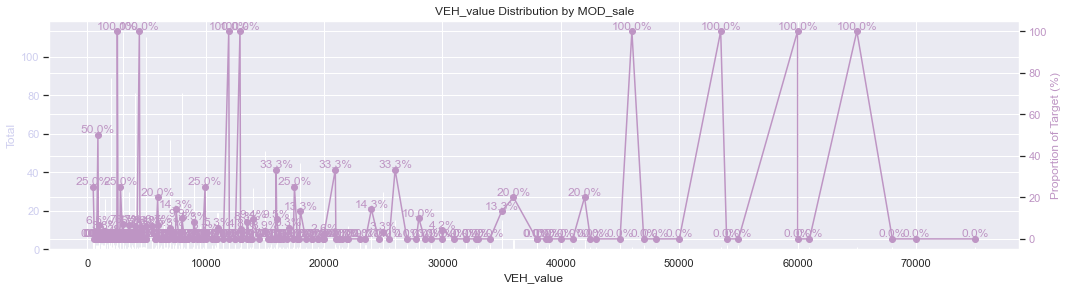


VEH_eng_size


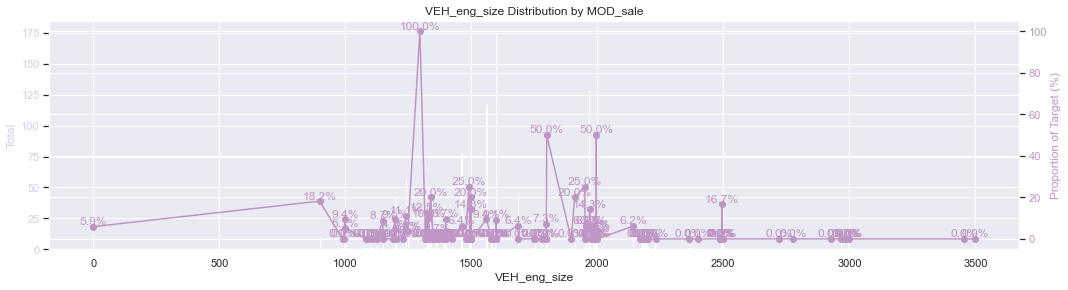


VEH_fuel


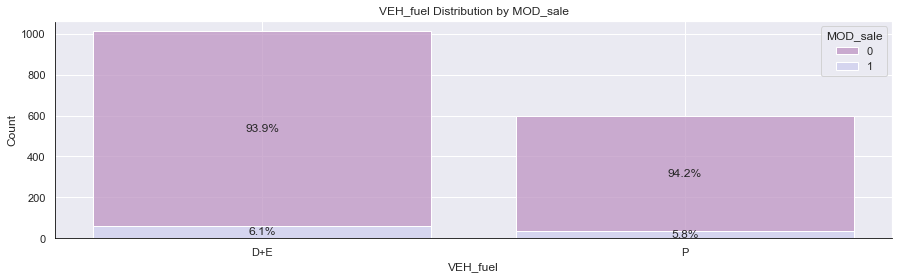


VEH_type


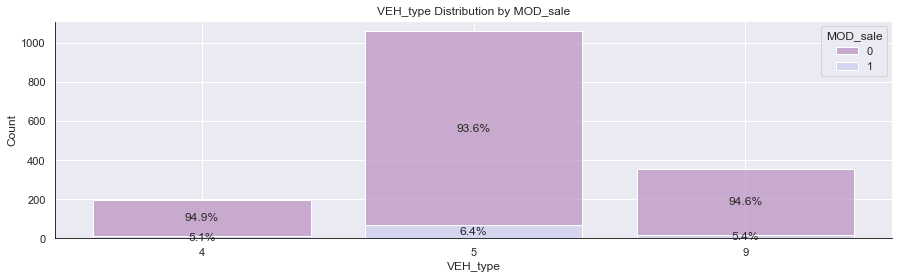


VEH_doors


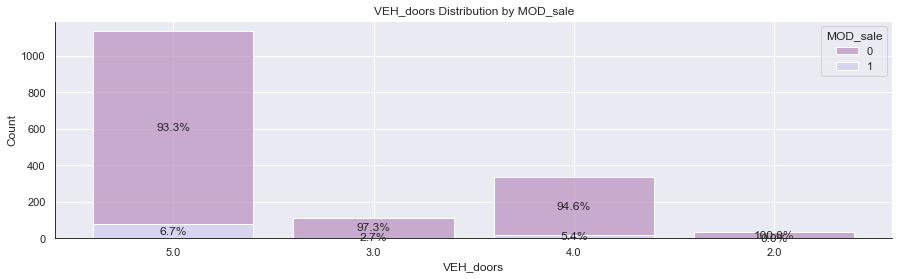


POL_cover


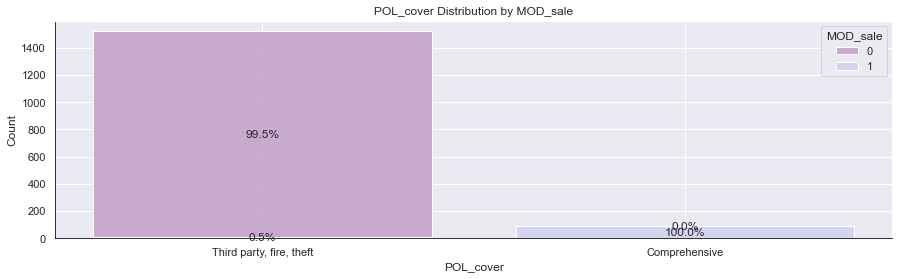


POL_days_to_incep


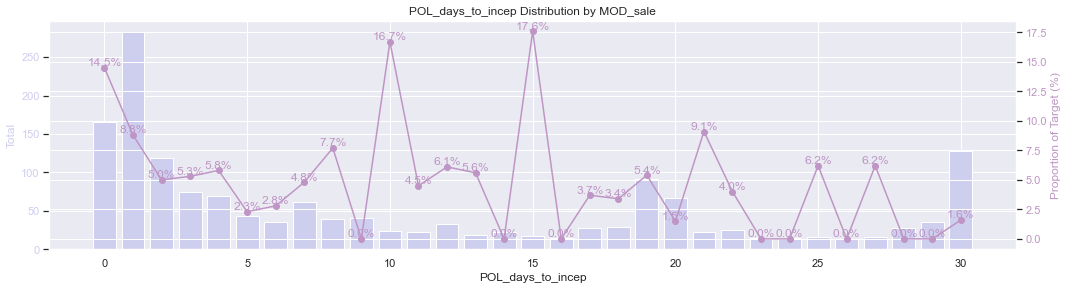


POL_mileage


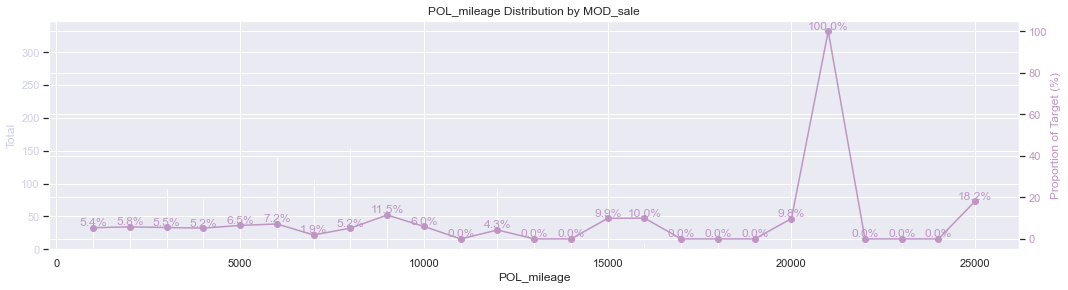


POL_paym_monthly


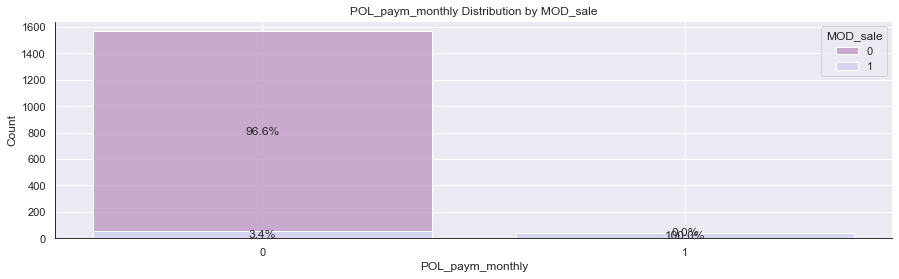


POL_park


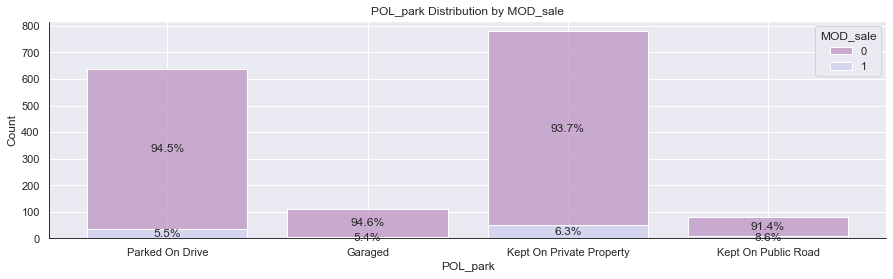


POL_homeowner


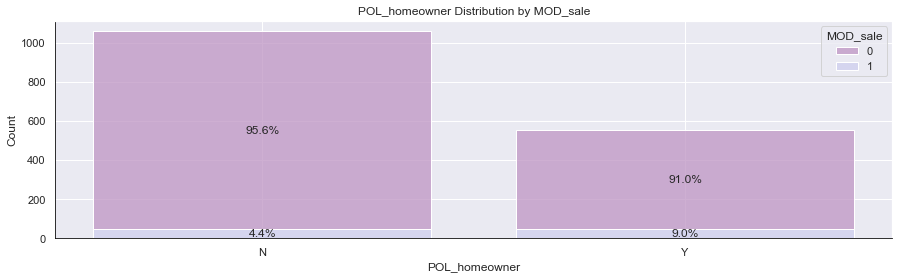


GEO_county


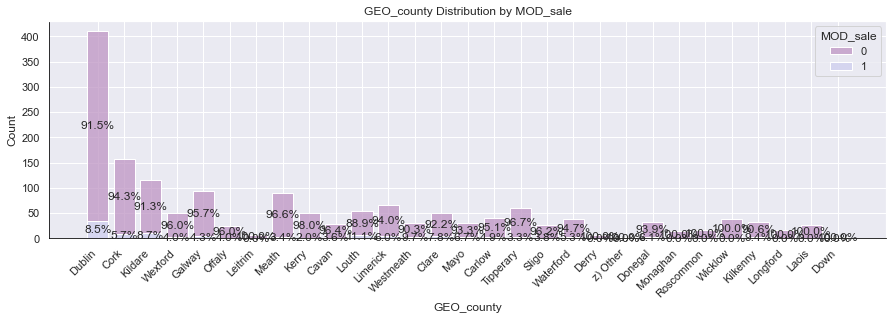


MOD_lowest_price


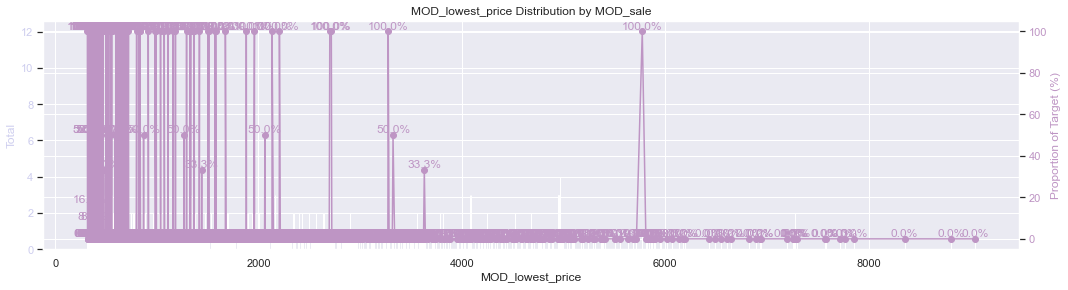


MOD_mk_price_pred


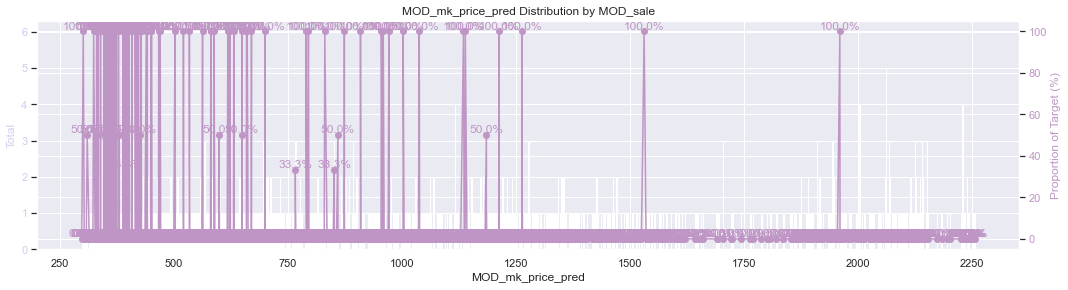


MOD_model


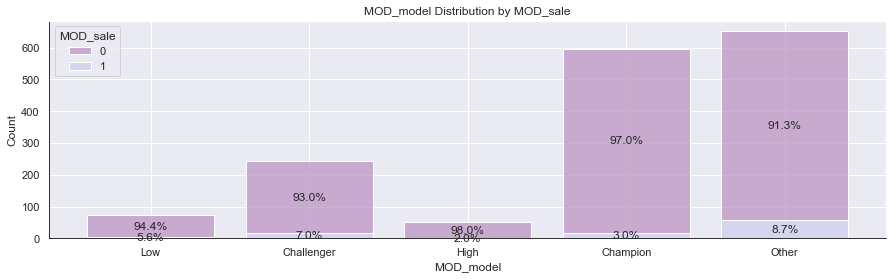


MOD_competitive


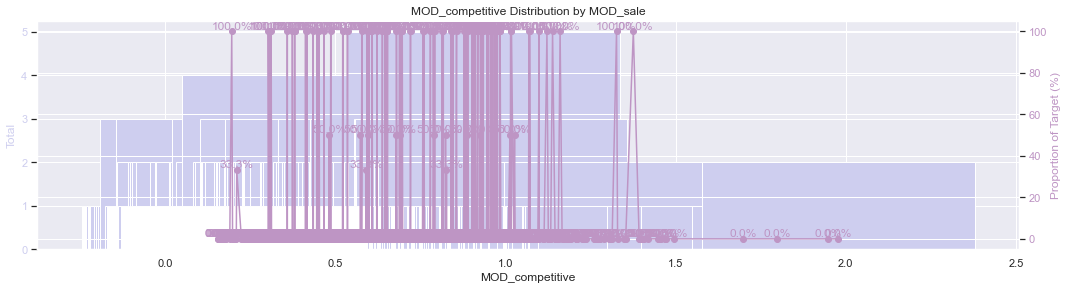

In [62]:
bivar_analysis_2(data_final, "MOD_sale", exclude=to_exclude)

From these analysis we can conclude the following:
+ For DRI_1_age, it looks to be an increasing linear tendecy until 50 years and it falls almost completely but it's true there not too much density in these levels (we see similar results in DRI_min_age)
+ For DRI_1_lic_type, it could be said that only Full Irish have a conversion of 7% around the average of the quotation dataset, for the rest is almost 0
+ For DRI_1_lic_count, almost the same thing as the previous one. Only some conversion for IE (Irish)
+ For DRI_1_NCD_years_main, the higher the number of NCD years, the higher conversition rate. For DRI_1_NCD_total_years it is even more clearer
+ For DRI_1_empl_status, it could be said that only Employed and Retired have a conversion of 6% around the average of the quotation dataset, for the rest is almost 0
+ For DRI_2_flag, when there is a driver 2 there is a much better conversion rate
+ For VEH_age, it looks to be an decreasing linear tendecy for vehicle age
+ **For POL_cover, it looks that all comprehensive quotes of these dataset converts and the same happens to POL_paym_monthly where all the monthly payments converts - we need to be careful with this becuase the density is very low in these levels**
+ For VEH_age, it looks to be an decreasing linear tendecy for POL_days_to_incep
+ For POL_homeowner, when the are homeowner their conversion rate is almost double

On the other hand, let's deep dive a little bite more in the calculated variable MOD_competitive to see how correlated the conversion rate is with this competitiveness variable against the different models used to calculate the market price. It competitiveness is quite positively correlated to the conversion it should show an increasing tendency.

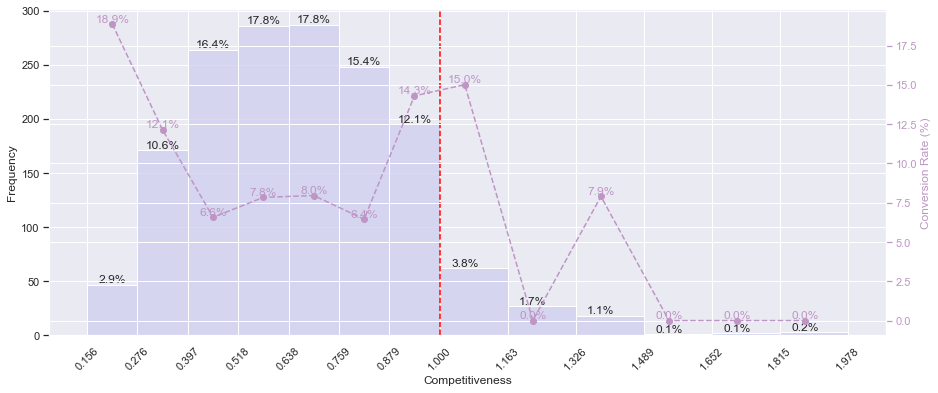

In [63]:
# Plot for the total data
plot_comp_2(data_final,'MOD_competitive','MOD_sale', '', colors2,15,6)

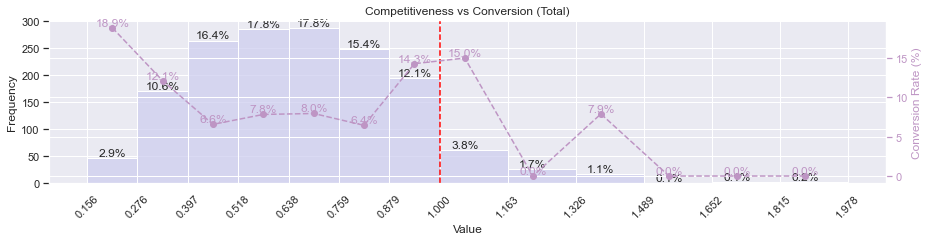

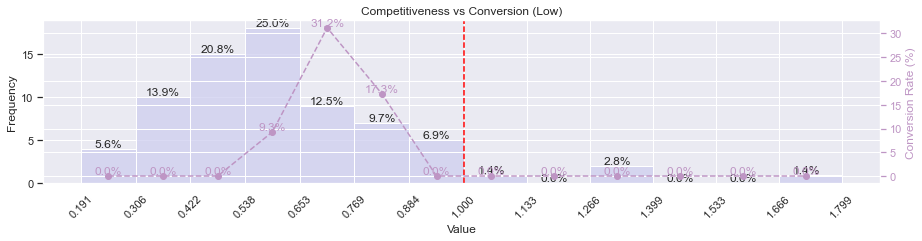

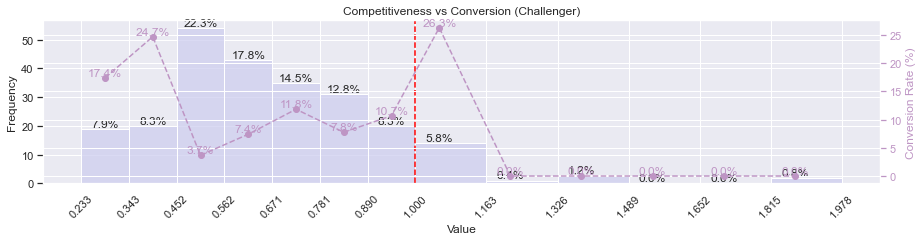

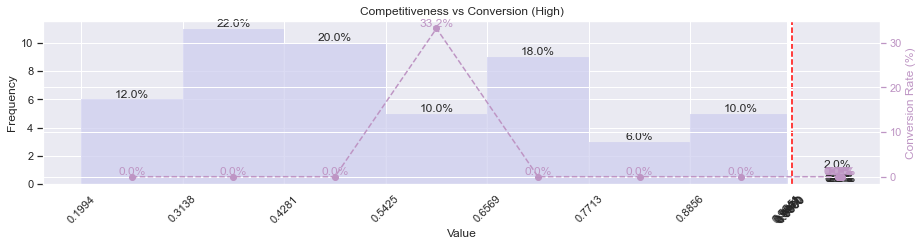

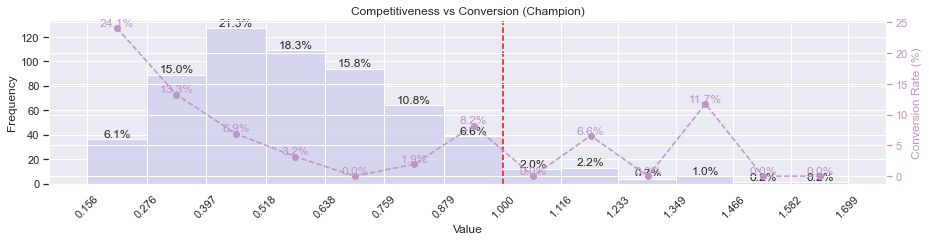

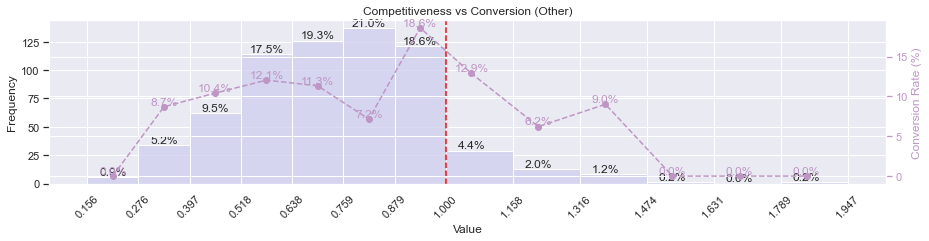

In [64]:
# Plot for the total data
plot_comp(data_final,'MOD_competitive','MOD_sale', 'Competitiveness vs Conversion (Total)', colors2)

# Plot for each level of MOD_model
unique_models = data_final['MOD_model'].unique()
for model in unique_models:
    model_data = data_final[data_final['MOD_model'] == model]
    plot_comp(model_data, 'MOD_competitive','MOD_sale',f'Competitiveness vs Conversion ({model})', colors2)

Only for the Other and Challenger models looks to have a logical relatively increasing tendency.

## <font color="#5e548e">2. Conversion Model <a name="id2"></a>

[Go to Table of Content](#ToC)

### <font color="#5e548e">2.1. Initial Analysis</font> <a name="id21"></a>

[Go to Table of Content](#ToC)

First, let's check again the response variable distribution:

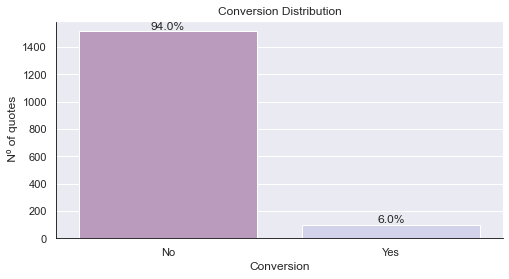

In [65]:
plot_2bar(data_final, 'MOD_sale', "Conversion Distribution")

As we can observe, it is a case of a very extreme imbalanced problem, so as we are more interested in the positive class (perform the sale) we will do the following items:
+ Use cross-validation as they are not so many observation to do a simple hold out. 
    - Also to not burden the process too much with the LOO and as we have almost 2000 observations (so it is not too much but not too little) we will perform cv k-folds
    - in cv k-folds we will add several replications to reduce the variability of randomly sampling the folds
    - Also we will do the k-folds stratified so we ensure that the class distribution is the same as the original (so we don't end up by chance with a fold without any positive class) 
+ Use SMOTE to create a balanced training dataset (to avoid data leakage) as this involves generating synthetic examples for the minority class
+ Evaluate the models using F1 score (harmonic mean of recall and precision) to focus in the prediction of the positive class maximaxing the recall, but also the precision (if not we could predict all observations to be positive class and the recall would be perfect, but useless as in the false class all would be false positives)

Before advancing, let's get a simple profile summary of the quotations:

In [66]:
def calculate_summary(data):
    summary = {
    'DRI_1_age': [data['DRI_1_age'].mean(), data['DRI_1_age'][data['MOD_sale'] == 1].mean()],
    'VEH_age': [data['VEH_age'].mean(), data['VEH_age'][data['MOD_sale'] == 1].mean()],
    'DRI_1_NCD_years_main': [data['DRI_1_NCD_years_main'].mean(), data['DRI_1_NCD_years_main'][data['MOD_sale'] == 1]
                             .mean()],
    'POL_cover': [data['POL_cover'].mode()[0], data['POL_cover'][data['MOD_sale'] == 1].mode()[0]],
    'POL_days_to_incep': [data['POL_days_to_incep'].mean(), data['POL_days_to_incep'][data['MOD_sale'] == 1].mean()],
    'MOD_lowest_price': [data['MOD_lowest_price'].mean(), data['MOD_lowest_price'][data['MOD_sale'] == 1].mean()]
    }
    summary_df = pd.DataFrame(summary, index=['profile', 'converted profile'])
    return summary_df

# Calculating the summary
summary_df = calculate_summary(data_final)

In [67]:
summary_df

DRI_1_age    VEH_age  DRI_1_NCD_years_main  \
profile            35.620732  10.080074              3.911235   
converted profile  39.896907   9.123711              5.896907   

                                  POL_cover  POL_days_to_incep  \
profile            Third party, fire, theft          10.585351   
converted profile             Comprehensive           5.979381   

                   MOD_lowest_price  
profile                 1649.474811  
converted profile        934.086701

In [68]:
14.3/2

7.15

Let's create already the evaluation metric:

In [69]:
# Create a custom F1 scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

Let's define the  k-folds stratified cv object with 5 folds - it should be enough the almost 1.5k training set sample size and 5 replications to reduce the uncertainty created from randomly splitting the folds.

In [70]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)

Besides we should consider to remove the variables:
+ MOD_model: as the model of how MOD_mk_price_pred variable (market price value) has been calculated it is relevant for studying the A/B test on which model produces the most accurate market price but not for directly calculating the conversion rate
+ MOD_sale_comp: we remove this one because it's a categorical variable that includes to which insurance company the customer goes when converted
+ QUO variables as we alreayd have the relevant variables of MOD_lowest_price and MOD_competitive for doing the model

In [71]:
vars_to_drop_for_comp=[
    'MOD_model',
    'MOD_sale_comp',
    'QUO_1_GWP',
    'QUO_1_NWP',
    'QUO_1_fee',
    'QUO_1_comm',
    'QUO_1_disc',
    'QUO_1_income',
    'QUO_1_price',
    'QUO_2_GWP',
    'QUO_2_NWP',
    'QUO_2_fee',
    'QUO_2_comm',
    'QUO_2_disc',
    'QUO_2_income',
    'QUO_2_price',
    'QUO_3_GWP',
    'QUO_3_NWP',
    'QUO_3_fee',
    'QUO_3_comm',
    'QUO_3_disc',
    'QUO_3_income',
    'QUO_3_price'
]
data_final_conv=data_final.drop(columns=vars_to_drop_for_comp,  errors='ignore')

On the other hand, the modelling proccess will be the following:
1. Do the dataset partition
2. Variable selection: 
    + Do a random forest and a GBM model tuning their hyperparameters, selecting the most optimal model
    + Understand the the most predictive variable from XAI techniques such as PFI and SHAP
3. Perform a logistic regression and evaluate the model 

### <font color="#5e548e">2.2. Dataset partition</font> <a name="id22"></a>

[Go to Table of Content](#ToC)

First, we will do the data partition. For that we will do the following:
1. Separate the target variable from the predictors
2. Convert into dummy variables the categorical ones for being able to standarize and being able to apply a logistic regression
3. Split data between train and test: we will have 75%-25% proportions.
4. Standarization of the variables:
    + Although it's not needed for decision trees based models to standarize the predictors, it doesn't do any harm and still it could help us for the logistic regression part
    + We will perform it to the training set and the apply the same to the test to avoid the information leakage and incur in overfitting

In [72]:
X = data_final_conv.drop('MOD_sale', axis=1)
y = data_final_conv['MOD_sale']

# we transform to dummy variables the categorical ones
cat_cols = X.select_dtypes(include=['object']).columns

# we convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# we split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler on the numerical features of the training data and transform the training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# we check the sum of variable means
train_mean_sum = X_train_scaled.mean().abs().sum().round(2)
test_mean_sum = X_test_scaled.mean().abs().sum().round(2)

print(f"Sum of absolute means for X_train_scaled: {train_mean_sum}")
print(f"Sum of absolute means for X_test_scaled: {test_mean_sum}")

Sum of absolute means for X_train_scaled: 0.0
Sum of absolute means for X_test_scaled: 3.73


As expected, the mean of the test set shouldn't be 0 as we applied the mean and variance of the train set to avoid information leakage.

### <font color="#5e548e">2.3. Model Variable Selection</font> <a name="id23"></a>

[Go to Table of Content](#ToC)

Let's start with the random forest model:

The main hyperparameters are two:
+ One is the size of the forest (number of classification tree models for which we do bagging) which usually is not tuned, but it is taken the largest amount possible, we will assume $1000$. 
+ The other is the number of randomly selected input variables considered at each split of the tree. This one is usually assumed $m=\sqrt{V}$, but we will try more values around it.

In [73]:
# number of randomly selected input variables range
m = int(np.floor(np.sqrt(X.shape[1])))
m_range=list(range(m - 3, m + 10))

# Define the parameter grids
rf_param_grid  = {
    'rf__max_features': m_range
}

# Define the pipelines
rf_pipeline = ImbPipeline(steps=[
    ('scaler', scaler),
    ('smote', SMOTE(random_state=seed)),
    ('rf', RandomForestClassifier(n_estimators=1000, random_state=seed))
])

# Hyperparameter tuning
rf_search1 = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring=f1_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=1
)

In [74]:
# Specify the path to save/load the model
model_path = 'models_saved/rf_search1.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the GridSearchCV object
    rf_search1 = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Fit the model and perform hyperparameter tuning
    rf_search1.fit(X_train_scaled, y_train)
    # Save the model
    joblib.dump(rf_search1, model_path)
    print("Model fitted and saved successfully.")

Model loaded successfully.


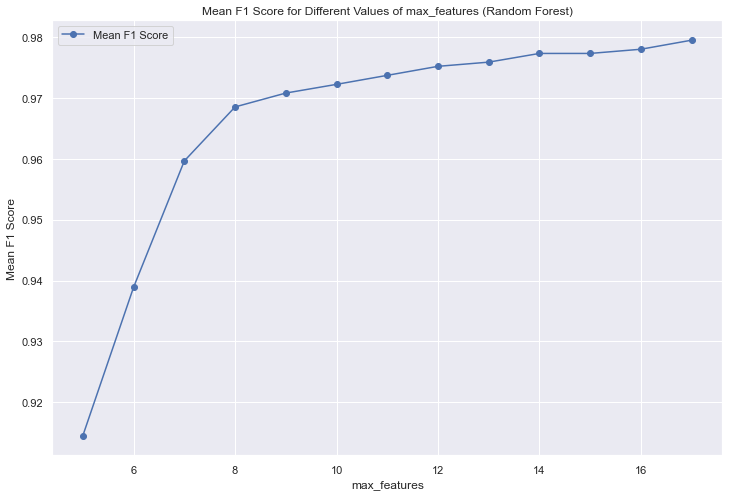

In [75]:
# Extract the results into a DataFrame
rf_results = pd.DataFrame(rf_search1.cv_results_)

# Extract the relevant data
max_features_values = rf_results['param_rf__max_features'].unique()

# Sort the results by max_features for a continuous line plot
results_sorted = rf_results.sort_values(by='param_rf__max_features')

plt.figure(figsize=(12, 8))

# Plot the line for max_features vs mean_test_score
plt.plot(
    results_sorted['param_rf__max_features'], 
    results_sorted['mean_test_score'], 
    marker='o', 
    linestyle='-', 
    color='b', 
    label='Mean F1 Score'
)

plt.title('Mean F1 Score for Different Values of max_features (Random Forest)')
plt.xlabel('max_features')
plt.ylabel('Mean F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# we filter by the model with the highest F1 score
best_params_rf=rf_results.loc[rf_results['mean_test_score'].idxmax()]["params"]
print("Best Hyperparameters for RF:", best_params_rf)

Best Hyperparameters for RF: {'rf__max_features': 17}


We can observe that still increasing the number of predictors to randomly choose produces a better model. However, F1 score gain has become very small. as such, continue with this hyperparameters.

Let's do now the GBM model:

In [77]:
# number of randomly selected input variables range
m = int(np.floor(np.sqrt(X.shape[1])))
m_range=list(range(m - 3, m + 10))

gbm_param_grid = {
    'gbm__max_features': m_range,
    'gbm__learning_rate': [0.01, 0.1],
    'gbm__max_depth': [3, 5]
}

# Define the pipelines
gbm_pipeline = ImbPipeline(steps=[
    ('scaler', scaler),
    ('smote', SMOTE(random_state=seed)),
    ('gbm', GradientBoostingClassifier(n_estimators=1000, random_state=seed))
])

# Hyperparameter tuning
gbm_search1 = GridSearchCV(
    estimator=gbm_pipeline,
    param_grid=gbm_param_grid,
    scoring=f1_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=1
)     

In [78]:
# Specify the path to save/load the model
model_path = 'models_saved/gbm_search1.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the GridSearchCV object
    gbm_search1 = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Fit the model and perform hyperparameter tuning
    gbm_search1.fit(X_train_scaled, y_train)
    # Save the model
    joblib.dump(gbm_search1, model_path)
    print("Model fitted and saved successfully.")

Model loaded successfully.


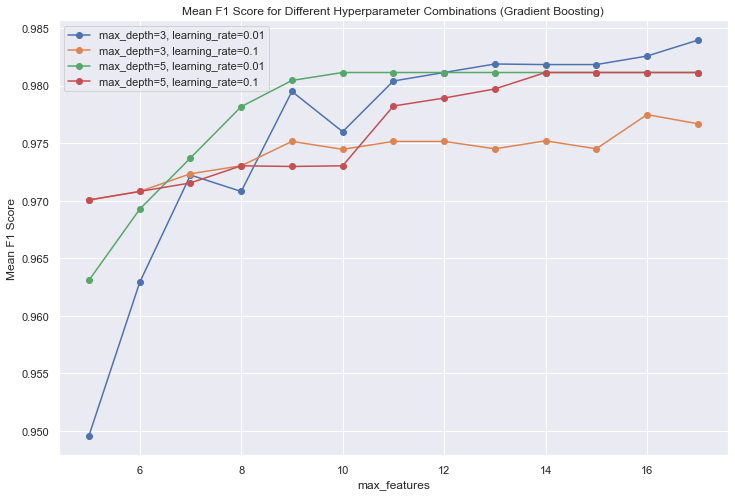

In [79]:
# Extract the results into a DataFrame
gbm_results = pd.DataFrame(gbm_search1.cv_results_)

# Extract unique values for max_depth and learning_rate
max_depth_values = [3, 5]
learning_rate_values = [0.01, 0.1]

plt.figure(figsize=(12, 8))

# Plot lines for each combination of max_depth and learning_rate
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        subset = gbm_results[
            (gbm_results['param_gbm__max_depth'] == max_depth) & 
            (gbm_results['param_gbm__learning_rate'] == learning_rate)
        ]
        if subset.empty:
            continue
        
        subset_sorted = subset.sort_values(by='param_gbm__max_features')
        plt.plot(
            subset_sorted['param_gbm__max_features'], 
            subset_sorted['mean_test_score'], 
            marker='o', 
            label=f'max_depth={max_depth}, learning_rate={learning_rate}'
        )

plt.title('Mean F1 Score for Different Hyperparameter Combinations (Gradient Boosting)')
plt.xlabel('max_features')
plt.ylabel('Mean F1 Score')
plt.legend()
plt.grid(True)
plt.show()

For the GBM, the best model hyperparameters are:

In [80]:
# we filter by the model with the highest F1 score
best_params_gbm=gbm_results.loc[gbm_results['mean_test_score'].idxmax()]["params"]
print("Best Hyperparameters for GBM:", best_params_gbm)

Best Hyperparameters for GBM: {'gbm__learning_rate': 0.01, 'gbm__max_depth': 3, 'gbm__max_features': 17}


In [81]:
# Filter the results DataFrame for GBM and Random Forest
best_gbm_results = gbm_results[gbm_results.params==best_params_gbm]
best_rf_results = rf_results[rf_results.params==best_params_rf]

# Extract the F1 scores for all validation runs with the best hyperparameters for GBM and Random Forest
f1_scores_gbm = best_gbm_results.loc[:, [col for col in gbm_results.columns if 'split' in col and 'test_score' in col]]
f1_scores_rf = best_rf_results.loc[:, [col for col in rf_results.columns if 'split' in col and 'test_score' in col]]

# Flatten the F1 scores and add a model column
f1_scores_gbm = f1_scores_gbm.values.flatten()
f1_scores_rf = f1_scores_rf.values.flatten()

# Create a DataFrame for plotting
f1_scores_df = pd.DataFrame({
    'F1 Score': list(f1_scores_gbm) + list(f1_scores_rf),
    'Model': ['GBM'] * len(f1_scores_gbm) + ['Random Forest'] * len(f1_scores_rf)
})

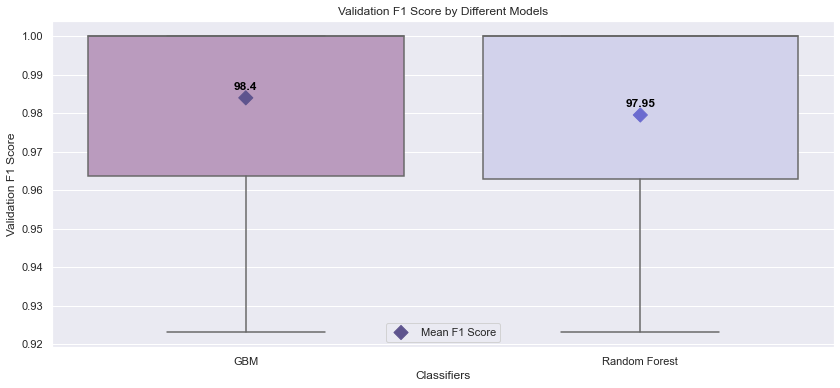

In [82]:
# Create the boxplot
plt.figure(figsize=(14, 6))
ax = sns.boxplot(x='Model', y='F1 Score', data=f1_scores_df, palette=colors2)

# Set alpha for the boxplot elements
for patch in ax.artists:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))  # Set the alpha to 0.6

plt.title('Validation F1 Score by Different Models')
plt.xlabel('Classifiers')
plt.ylabel('Validation F1 Score')

# Calculate and plot the means
means = f1_scores_df.groupby('Model').mean().reset_index()
plt.scatter(means['Model'], means['F1 Score'], color=colors2_2, marker='D', s=100, label='Mean F1 Score')

# Annotate the means on the plot
for i in range(means.shape[0]):
    plt.text(i, means['F1 Score'][i] + 0.002, round(means['F1 Score'][i]*100, 2), 
             horizontalalignment='center', size='medium', color='black', weight='semibold')

# Show the plot
plt.legend()
plt.show()

As we can observe the GBM model a little bite better as such we will take it, retrain the model with this optimal hyperparameters but now with all of the training dataset.

In [83]:
# Retrain the model using the best hyperparameters on the entire training dataset
best_gbm1 = GradientBoostingClassifier(
    n_estimators=1000,
    max_features=best_params_gbm['gbm__max_features'],
    learning_rate=best_params_gbm['gbm__learning_rate'],
    max_depth=best_params_gbm['gbm__max_depth'],
    random_state=seed
)

In [84]:
# Specify the path to save/load the model
model_path = 'models_saved/best_gbm1.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the GridSearchCV object
    best_gbm1 = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Fit the model and perform hyperparameter tuning
    best_gbm1.fit(X_train_scaled, y_train)
    # Save the model
    joblib.dump(best_gbm1, model_path)
    print("Model fitted and saved successfully.")

Model loaded successfully.


Now let's select the optimal threshold based on the F1 score:

Optimal Threshold: 0.9690
Optimal F1 Score: 1.0000


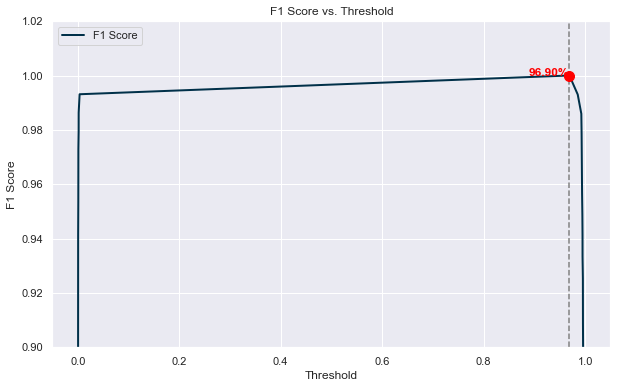

In [85]:
# Predict probabilities for the training data
y_train_prob = best_gbm1.predict_proba(X_train_scaled)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Optimal F1 Score: {optimal_f1_score:.4f}")

# Create the plot with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=f1_scores[:-1], color='#003049', linewidth=2, label='F1 Score')
plt.axvline(x=optimal_threshold, color='gray', linestyle='--')
plt.scatter(optimal_threshold, optimal_f1_score, color='red', s=100, zorder=5)
plt.text(optimal_threshold, optimal_f1_score, f'{optimal_threshold:.2%}', 
         horizontalalignment='right', size='medium', color='red', weight='semibold')

# Add titles and labels
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.ylim(0.9, 1.02)  # Set y-axis to start from 0.9
plt.grid(True)
plt.legend()
plt.show()

Now we can proceed to evaluate the training set and the test set for seeing the generalization error:

Training Set Evaluation


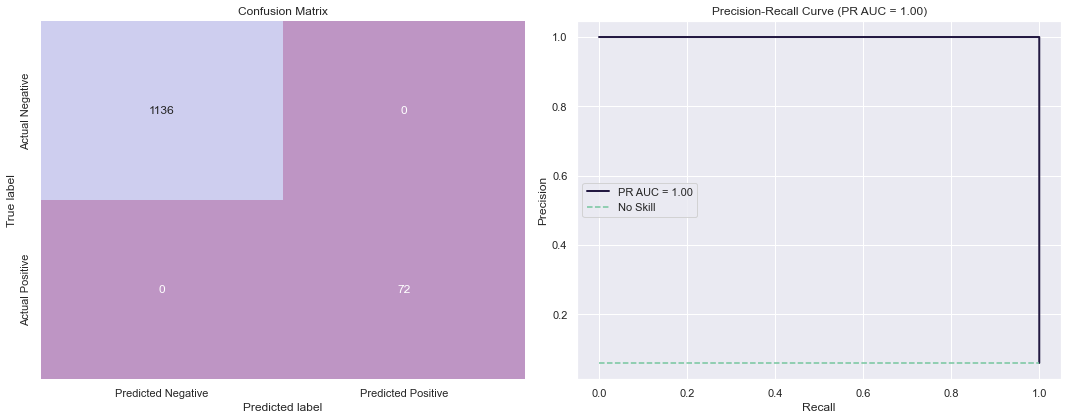

Accuracy: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
Precision: 1.0000
F1 Score: 1.0000
Prevalence: 0.0596


In [86]:
print("Training Set Evaluation")
calc_metrics(best_gbm1, X_train_scaled, y_train, optimal_threshold)


Test Set Evaluation


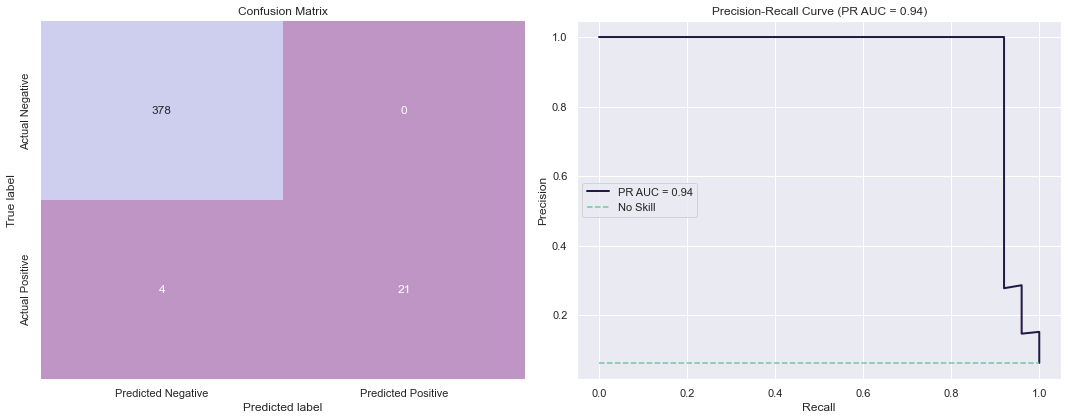

Accuracy: 0.9901
Recall (Sensitivity): 0.8400
Specificity: 1.0000
Precision: 1.0000
F1 Score: 0.9130
Prevalence: 0.0620


In [87]:
print("\nTest Set Evaluation")
calc_metrics(best_gbm1, X_test_scaled, y_test, optimal_threshold)

As we can observe the results in the training data are a little bit better than on the test data as in the test data the
recall goes down to 84%. However, the ability of the selected model at predicting if the quote will convert is very high.

Now that we have in place a very predictive model, we would like to understand the most predictive variables this model is using. The problem with this ensemble models is that they are a little bite black boxes so despite of their great performance, they are very difficult to interprete.

As such we will apply some global XAI (explainable artificial intelligence techniques such as the SHAP or the PFI to better understand the relative importance of the predictors to the model. 

We will start with the PFI (permutation Feature Importance) method. This global method shows a ranking of the importance of the explanatory variables in predicting the response variable.

To do this, it takes each explanatory variable one at a time and permutes its values (keeping the rest constant) while calculating the impact on the model's performance (the deterioration of the model). The underlying idea is that this intervention breaks the relationship between the explanatory variable and the response, so a significant decrease in the model's performance tends to indicate that this variable is very important in the model.

This technique is usually performed on the test set since it is information that the model has not seen during training. As such, it is generally a more realistic estimator of the variables' importance in the model.

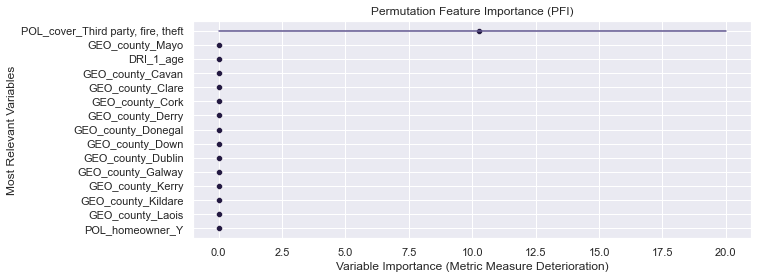

In [88]:
PFI_model = PFI(best_gbm1, X_test_scaled, y_test, repetitions=20, threshold=optimal_threshold, metric=f1_score)

# we plot the results for a top 15
PFI_plot(PFI_model, top_n=15)

Now we will apply SHAP (Hapley Additive exPlanations) method. It is based on Shapley values, a solution concept from Game Theory.

Focusing a bit on the calculation approach of this method to rank variable importance, it decomposes a model's prediction for a specific instance into contributions from each feature. To do this, it considers all possible combinations of features and, for each combination, calculates the contribution of a particular feature. This contribution is the difference in the prediction with and without the feature.

Therefore, the importance of a feature is calculated as the average of these contributions, weighted across all possible combinations of features.

As can be understood, this calculation is computationally very expensive due to the need to consider all combinations.

In [89]:
# Sample a subset for summary plots
X_test_summary = shap.sample(X_test_scaled, 4000)

X_test_summary_np = np.array(X_test_summary)
X_test_np = np.array(X_test_scaled)

# Create SHAP explainer
explainer = shap.Explainer(best_gbm1, X_test_summary_np)
shap_values = explainer(X_test_np)

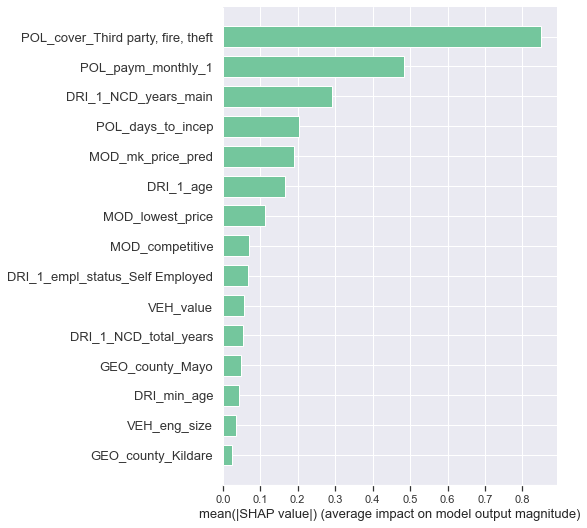

In [90]:
# Define the title
title = 'Most Important Variables by SHAP Method'
display(HTML('<h3 style="text-align: center; color: grey; padding-right: 150px;">{}</h3>'.format(title)))

# Generate SHAP summary plot with specific color
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", color='#74c69d', max_display=15)

As kind of expected, we see that the most predictive variable is the cover because as we showed in the EDA all of the comprehensive cover quotes converted representing almost all of the total converted quotes. This is happening due to the small sample size as we just took the quotations taking place in a weekend.

Very similarly happens with the monthly payment variable in a lower degree.

As such, we cannot accept this kind of model or that this is the almost only and most predictive variable.

**Thus, we will run the model again removing the cover variable as well as the monthly payment variable.**

In [91]:
vars_to_drop_for_comp=[
    'MOD_model',
    'MOD_sale_comp',
    'QUO_1_GWP',
    'QUO_1_NWP',
    'QUO_1_fee',
    'QUO_1_comm',
    'QUO_1_disc',
    'QUO_1_income',
    'QUO_1_price',
    'QUO_2_GWP',
    'QUO_2_NWP',
    'QUO_2_fee',
    'QUO_2_comm',
    'QUO_2_disc',
    'QUO_2_income',
    'QUO_2_price',
    'QUO_3_GWP',
    'QUO_3_NWP',
    'QUO_3_fee',
    'QUO_3_comm',
    'QUO_3_disc',
    'QUO_3_income',
    'QUO_3_price',
    'POL_cover',
    'POL_paym_monthly'
]
data_final_conv=data_final.drop(columns=vars_to_drop_for_comp,  errors='ignore')


X = data_final_conv.drop('MOD_sale', axis=1)
y = data_final_conv['MOD_sale']

# we transform to dummy variables the categorical ones
cat_cols = X.select_dtypes(include=['object']).columns

# we convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# we split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler on the numerical features of the training data and transform the training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# we check the sum of variable means
train_mean_sum = X_train_scaled.mean().abs().sum().round(2)
test_mean_sum = X_test_scaled.mean().abs().sum().round(2)

print(f"Sum of absolute means for X_train_scaled: {train_mean_sum}")
print(f"Sum of absolute means for X_test_scaled: {test_mean_sum}")

Sum of absolute means for X_train_scaled: 0.0
Sum of absolute means for X_test_scaled: 3.62


Let's redo now the GBM model at least to see how different it would look the order:

In [92]:
# number of randomly selected input variables range
m = int(np.floor(np.sqrt(X.shape[1])))
m_range=list(range(m - 3, m + 10))

gbm_param_grid = {
    'gbm__max_features': m_range,
    'gbm__learning_rate': [0.01, 0.1],
    'gbm__max_depth': [3, 5]
}

# Define the pipelines
gbm_pipeline = ImbPipeline(steps=[
    ('scaler', scaler),
    ('smote', SMOTE(random_state=seed)),
    ('gbm', GradientBoostingClassifier(n_estimators=1000, random_state=seed))
])

# Hyperparameter tuning
gbm_search2 = GridSearchCV(
    estimator=gbm_pipeline,
    param_grid=gbm_param_grid,
    scoring=f1_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=1
)

In [93]:
# Specify the path to save/load the model
model_path = 'models_saved/gbm_search2.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the GridSearchCV object
    gbm_search2 = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Fit the model and perform hyperparameter tuning
    gbm_search2.fit(X_train_scaled, y_train)
    # Save the model
    joblib.dump(gbm_search2, model_path)
    print("Model fitted and saved successfully.")

Model loaded successfully.


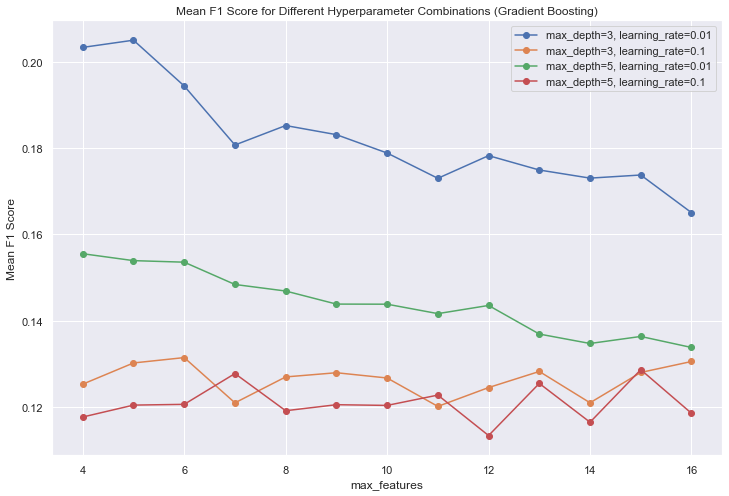

In [94]:
# Extract the results into a DataFrame
gbm_results = pd.DataFrame(gbm_search2.cv_results_)

# Extract unique values for max_depth and learning_rate
max_depth_values = [3, 5]
learning_rate_values = [0.01, 0.1]

plt.figure(figsize=(12, 8))

# Plot lines for each combination of max_depth and learning_rate
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        subset = gbm_results[
            (gbm_results['param_gbm__max_depth'] == max_depth) & 
            (gbm_results['param_gbm__learning_rate'] == learning_rate)
        ]
        if subset.empty:
            continue
        
        subset_sorted = subset.sort_values(by='param_gbm__max_features')
        plt.plot(
            subset_sorted['param_gbm__max_features'], 
            subset_sorted['mean_test_score'], 
            marker='o', 
            label=f'max_depth={max_depth}, learning_rate={learning_rate}'
        )

plt.title('Mean F1 Score for Different Hyperparameter Combinations (Gradient Boosting)')
plt.xlabel('max_features')
plt.ylabel('Mean F1 Score')
plt.legend()
plt.grid(True)
plt.show()

For the GBM, the best model hyperparameters are:

In [95]:
# we filter by the model with the highest F1 score
best_params_gbm=gbm_results.loc[gbm_results['mean_test_score'].idxmax()]["params"]
print("Best Hyperparameters for GBM:", best_params_gbm)

Best Hyperparameters for GBM: {'gbm__learning_rate': 0.01, 'gbm__max_depth': 3, 'gbm__max_features': 5}


In [96]:
# Filter the results DataFrame for GBM and Random Forest
best_gbm_results = gbm_results[gbm_results.params==best_params_gbm]

# Extract the F1 scores for all validation runs with the best hyperparameters for GBM and Random Forest
f1_scores_gbm = best_gbm_results.loc[:, [col for col in gbm_results.columns if 'split' in col and 'test_score' in col]]

# Flatten the F1 scores and add a model column
f1_scores_gbm = f1_scores_gbm.values.flatten()

# Create a DataFrame for plotting
f1_scores_df = pd.DataFrame({
    'F1 Score': f1_scores_gbm,
    'Model': ['GBM'] * len(f1_scores_gbm)
})

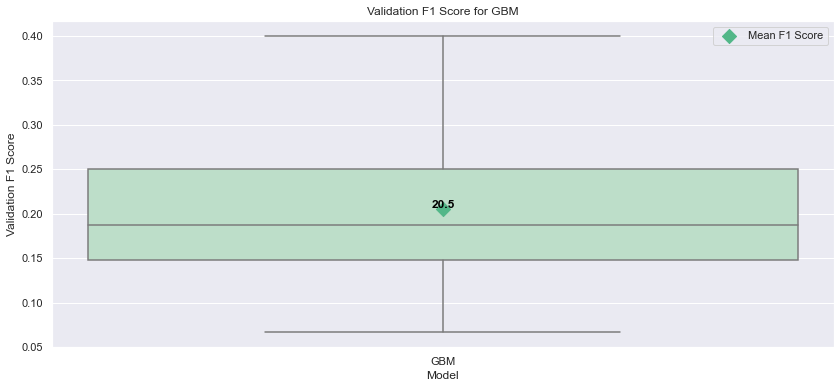

In [97]:
# Create the boxplot
plt.figure(figsize=(14, 6))
ax = sns.boxplot(x='Model', y='F1 Score', data=f1_scores_df, palette=['#b7e4c7'])

# Set alpha for the boxplot elements
for patch in ax.artists:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))  # Set the alpha to 0.6

plt.title('Validation F1 Score for GBM')
plt.xlabel('Model')
plt.ylabel('Validation F1 Score')

# Calculate and plot the means
means = f1_scores_df.groupby('Model').mean().reset_index()
plt.scatter(means['Model'], means['F1 Score'], color="#52b788", marker='D', s=100, label='Mean F1 Score')

# Annotate the means on the plot
for i in range(means.shape[0]):
    plt.text(i, means['F1 Score'][i] + 0.002, round(means['F1 Score'][i]*100, 2), 
             horizontalalignment='center', size='medium', color='black', weight='semibold')

# Show the plot
plt.legend()
plt.show()

As we can observe the GBM model is so much worse without the cover variable

In [98]:
# Retrain the model using the best hyperparameters on the entire training dataset
best_gbm2 = GradientBoostingClassifier(
    n_estimators=1000,
    max_features=best_params_gbm['gbm__max_features'],
    learning_rate=best_params_gbm['gbm__learning_rate'],
    max_depth=best_params_gbm['gbm__max_depth'],
    random_state=seed
)

In [99]:
# Specify the path to save/load the model
model_path = 'models_saved/best_gbm2.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the GridSearchCV object
    best_gbm2 = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Fit the model and perform hyperparameter tuning
    best_gbm2.fit(X_train_scaled, y_train)
    # Save the model
    joblib.dump(best_gbm2, model_path)
    print("Model fitted and saved successfully.")

Model loaded successfully.


Now let's select the optimal threshold based on the F1 score:

Optimal Threshold: 0.2932
Optimal F1 Score: 0.7656


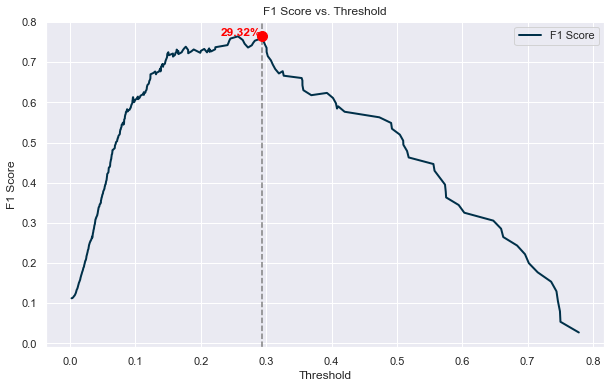

In [100]:
# Predict probabilities for the training data
y_train_prob = best_gbm2.predict_proba(X_train_scaled)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Optimal F1 Score: {optimal_f1_score:.4f}")

# Create the plot with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=f1_scores[:-1], color='#003049', linewidth=2, label='F1 Score')
plt.axvline(x=optimal_threshold, color='gray', linestyle='--')
plt.scatter(optimal_threshold, optimal_f1_score, color='red', s=100, zorder=5)
plt.text(optimal_threshold, optimal_f1_score, f'{optimal_threshold:.2%}', 
         horizontalalignment='right', size='medium', color='red', weight='semibold')

# Add titles and labels
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
# plt.ylim(0.9, 1.02)
plt.legend()
plt.show()

Now we can proceed to evaluate the training set and the test set for seeing the generalization error:

Training Set Evaluation


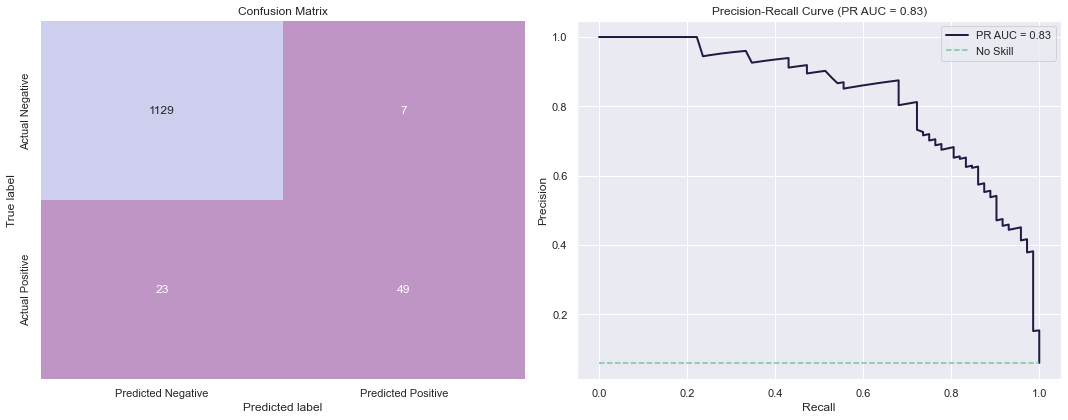

Accuracy: 0.9752
Recall (Sensitivity): 0.6806
Specificity: 0.9938
Precision: 0.8750
F1 Score: 0.7656
Prevalence: 0.0596


In [101]:
print("Training Set Evaluation")
calc_metrics(best_gbm2, X_train_scaled, y_train, optimal_threshold)


Test Set Evaluation


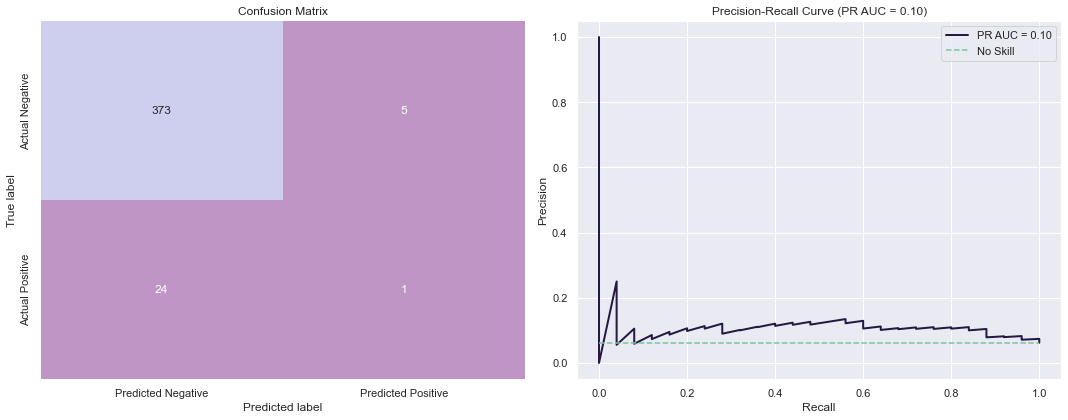

Accuracy: 0.9280
Recall (Sensitivity): 0.0400
Specificity: 0.9868
Precision: 0.1667
F1 Score: 0.0645
Prevalence: 0.0620


In [102]:
print("\nTest Set Evaluation")
calc_metrics(best_gbm2, X_test_scaled, y_test, optimal_threshold)

Now the generalization error is too high, let's see the variable importance.

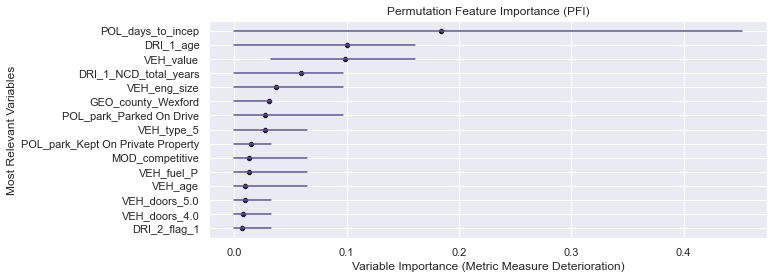

In [103]:
PFI_model = PFI(best_gbm2, X_test_scaled, y_test, repetitions=20, threshold=optimal_threshold, metric=f1_score)

# we plot the results for a top 15
PFI_plot(PFI_model, top_n=15)

In [104]:
 mean_results = PFI_model.mean().sort_values(ascending=False)
mean_results[:15]

POL_days_to_incep                    0.183871
DRI_1_age                            0.100000
VEH_value                            0.098387
DRI_1_NCD_total_years                0.059677
VEH_eng_size                         0.037097
GEO_county_Wexford                   0.030645
POL_park_Parked On Drive             0.027419
VEH_type_5                           0.027419
POL_park_Kept On Private Property    0.014516
MOD_competitive                      0.012903
VEH_fuel_P                           0.012903
VEH_age                              0.009677
VEH_doors_5.0                        0.009677
VEH_doors_4.0                        0.008065
DRI_2_flag_1                         0.006452
dtype: float64

In [105]:
# Sample a subset for summary plots
X_test_summary = shap.sample(X_test_scaled, 4000)

X_test_summary_np = np.array(X_test_summary)
X_test_np = np.array(X_test_scaled)

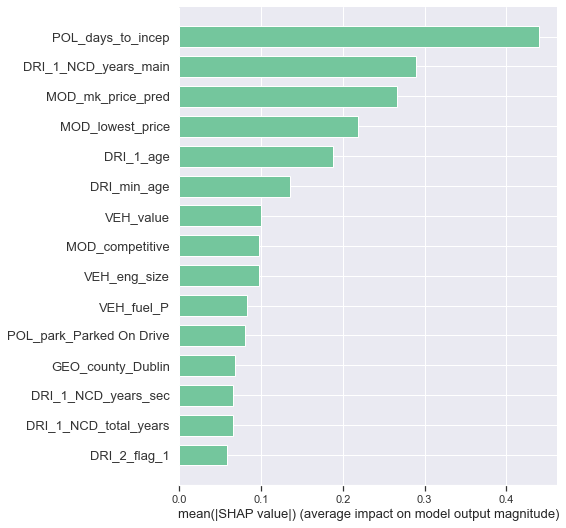

In [106]:
# Create SHAP explainer
explainer = shap.Explainer(best_gbm2, X_test_summary_np)
shap_values = explainer(X_test_np, check_additivity=False)

# Define the title
title = 'Most Important Variables by SHAP Method'
display(HTML('<h3 style="text-align: center; color: grey; padding-right: 150px;">{}</h3>'.format(title)))

# Generate SHAP summary plot with specific color
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", color='#74c69d', max_display=15)

In [107]:
# Create SHAP explainer
explainer = shap.Explainer(best_gbm2, X_test_summary_np)
shap_values = explainer(X_test_np, check_additivity=False)

In [108]:
X_test_scaled_renamed = X_test_scaled.rename(columns={
    'POL_days_to_incep': 'Days to inception',
    'DRI_1_NCD_years_main': 'NCD Claim Years',
    'MOD_mk_price_pred': 'Market Price',
    'MOD_lowest_price': 'Panel Price',
    'MOD_competitive':'Competitiveness',
    'DRI_1_age': 'Main Driver Age',
    'DRI_min_age': 'Min Driver 1 and 2 Age',
    'VEH_value': 'Vehicle Value',
    'VEH_eng_size': 'Vehicle Engine Size',
    'VEH_fuel_P': 'Vehicle Petrol Fuel'
})

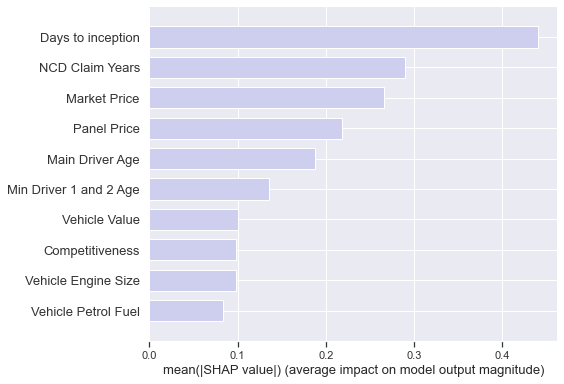

In [109]:
# Define the title

title = 'Most Important Variables by SHAP Method'
display(HTML('<h3 style="text-align: center; color: grey; padding-right: 150px;">{}</h3>'.format(title)))

# Generate SHAP summary plot with specific color
shap.summary_plot(shap_values, X_test_scaled_renamed, plot_type="bar", color='#CECEEF', max_display=10)

Now the variables that appear for the SHAP look to have more sense. To have look from a different perspective let's create a logistic regression model doing forward  stepwise looking at the AIC gain.

In [110]:
vars_to_drop_for_comp=[
    'MOD_model',
    'MOD_sale_comp',
    'QUO_1_GWP',
    'QUO_1_NWP',
    'QUO_1_fee',
    'QUO_1_comm',
    'QUO_1_disc',
    'QUO_1_income',
    'QUO_1_price',
    'QUO_2_GWP',
    'QUO_2_NWP',
    'QUO_2_fee',
    'QUO_2_comm',
    'QUO_2_disc',
    'QUO_2_income',
    'QUO_2_price',
    'QUO_3_GWP',
    'QUO_3_NWP',
    'QUO_3_fee',
    'QUO_3_comm',
    'QUO_3_disc',
    'QUO_3_income',
    'QUO_3_price',
    'POL_cover',
    'POL_paym_monthly',
    'GEO_county'
]
data_final_conv=data_final.drop(columns=vars_to_drop_for_comp,  errors='ignore')


X = data_final_conv.drop('MOD_sale', axis=1)
y = data_final_conv['MOD_sale']

# we transform to dummy variables the categorical ones
cat_cols = X.select_dtypes(include=['object']).columns

# we convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# we split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler on the numerical features of the training data and transform the training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# we check the sum of variable means
train_mean_sum = X_train_scaled.mean().abs().sum().round(2)
test_mean_sum = X_test_scaled.mean().abs().sum().round(2)

print(f"Sum of absolute means for X_train_scaled: {train_mean_sum}")
print(f"Sum of absolute means for X_test_scaled: {test_mean_sum}")

Sum of absolute means for X_train_scaled: 0.0
Sum of absolute means for X_test_scaled: 1.81


In [111]:
# Perform forward stepwise selection
selected_features, final_model, aic_df = forwardAIC(y_train, X_train_scaled)

C:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [112]:
print("Selected features by forward AIC:", selected_features)
print(final_model.summary())

Selected features by forward AIC: ['MOD_mk_price_pred', 'POL_days_to_incep', 'MOD_competitive', 'MOD_lowest_price', 'VEH_type_5', 'DRI_1_age', 'DRI_1_empl_status_Household Duties', 'VEH_fuel_P']
                           Logit Regression Results                           
Dep. Variable:               MOD_sale   No. Observations:                 1208
Model:                          Logit   Df Residuals:                     1199
Method:                           MLE   Df Model:                            8
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.2008
Time:                        18:54:21   Log-Likelihood:                -218.06
converged:                       True   LL-Null:                       -272.85
Covariance Type:            nonrobust   LLR p-value:                 4.619e-20
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

We can observe that the variables *MOD_mk_price_pred*, *POL_days_to_incep*, *MOD_competitive*, *MOD_lowest_price* are the predictive variables which makes sense and is in line                                                              

As such, the best variables to select would be the following:
+ POL_days_to_incep
+ MOD_competitive
+ MOD_lowest_price
+ DRI_1_age


Also other like:
+ POL_homeowner
+ DRI_1_NCD_total_years
+ VEH_age

### <font color="#5e548e">2.4. Model Training & Evaluation</font> <a name="id24"></a>

[Go to Table of Content](#ToC)

Now based on the conclusions from the model selection we will do a logistic model training. However, before defining different models to check evaluating the valuation F1 score we will apply some splines to numeric variables:

We will start with the variable **competitiveness**:

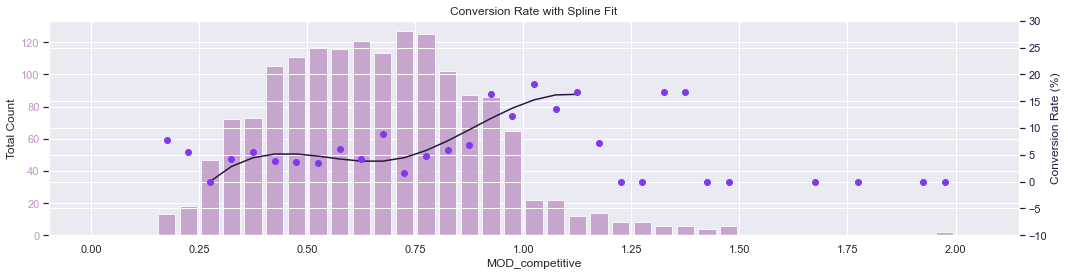

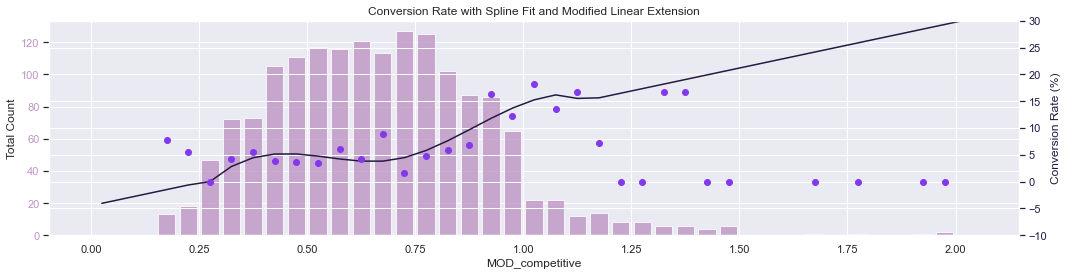

In [113]:
linear_fit_composite, conversion_rates_selected_array = apply_splines(data_final_conv, 'MOD_competitive',
                                                                     low_limit=0.25,
                                                                     upper_limit=1.15,
                                                                     degree=3,df=4, slope_factor=1, 
                                                                     bin_start=0, 
                                                                     bin_end=2.1, 
                                                                     bin_width=0.05,
                                                                     colors=colors3_3)

In [114]:
# Replace the original MOD_competitive with the composite fit values
data_final_conv['MOD_competitive_comp'] = np.interp(
    data_final_conv['MOD_competitive'], # x-coor at which to evaluate the interpolated values
    conversion_rates_selected_array, # x-coor of the data points, must be increasing
    linear_fit_composite # the y-coordinates of the data points
)

Now we will do it for the variable **Driver 1 Age**:

C:\Users\daniq\AppData\Local\Temp\ipykernel_15328\706118220.py:1: RankWarning: Polyfit may be poorly conditioned
  linear_fit_composite, conversion_rates_selected_array  = apply_splines(data_final_conv, 'DRI_1_age',


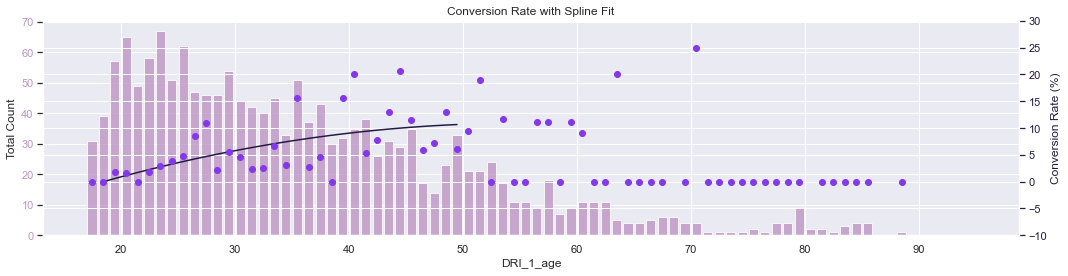

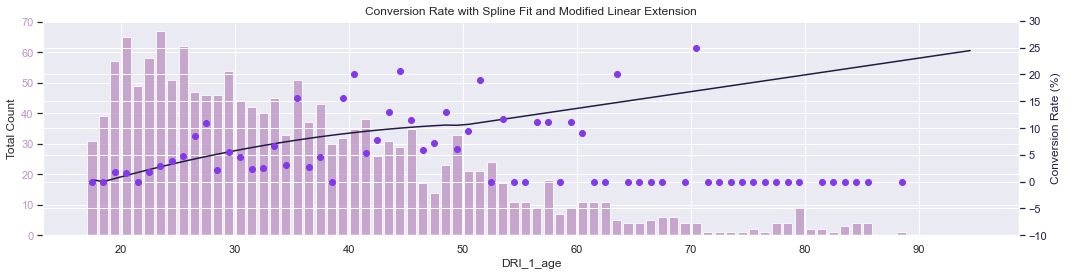

In [115]:
linear_fit_composite, conversion_rates_selected_array  = apply_splines(data_final_conv, 'DRI_1_age', 
                                                                     low_limit=18, 
                                                                     upper_limit=50, 
                                                                     degree=2, df=2, slope_factor=0.91, 
                                                                     bin_start=data_final_conv.DRI_1_age.min(), 
                                                                     bin_end=data_final_conv.DRI_1_age.max() + 1,
                                                                     bin_width=1,
                                                                     colors=colors3_3)

In [116]:
# Replace the original MOD_competitive with the composite fit values
data_final_conv['DRI_1_age_comp'] = np.interp(
    data_final_conv['DRI_1_age'], # x-coor at which to evaluate the interpolated values
    conversion_rates_selected_array, # x-coor of the data points, must be increasing
    linear_fit_composite # the y-coordinates of the data points
)

Now we will do it for the variable **POL_days_to_incep**:

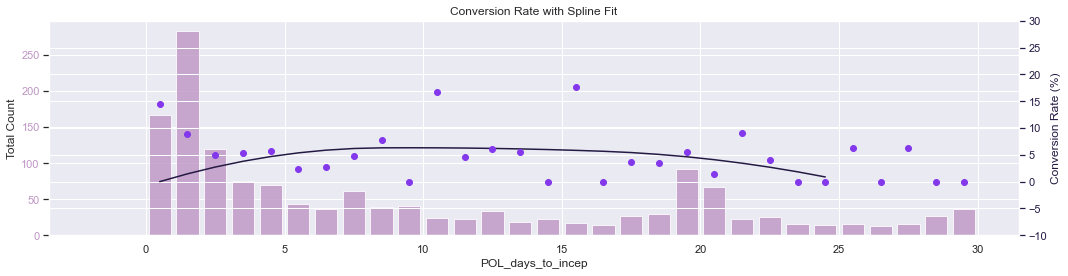

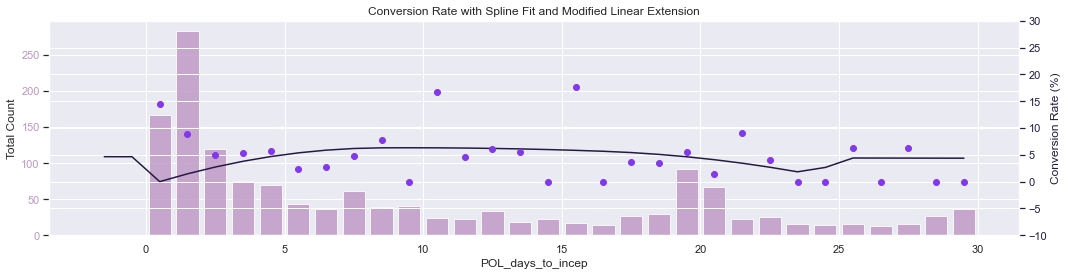

In [117]:
linear_fit_composite, conversion_rates_selected_array  = apply_splines(data_final_conv, 'POL_days_to_incep', 
                                                                     low_limit=0, 
                                                                     upper_limit=25, 
                                                                     degree=2, df=4, slope_factor=1, 
                                                                     bin_start=-2, 
                                                                     bin_end=data_final_conv.POL_days_to_incep.max()+1,
                                                                     bin_width=1,
                                                                     colors=colors3_3)

Here we don't get to create the tendency we see

Now we will do it for the variable **MOD_lowest_price**:

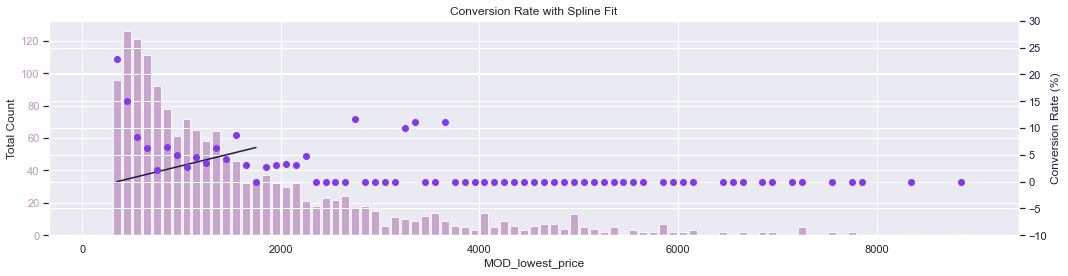

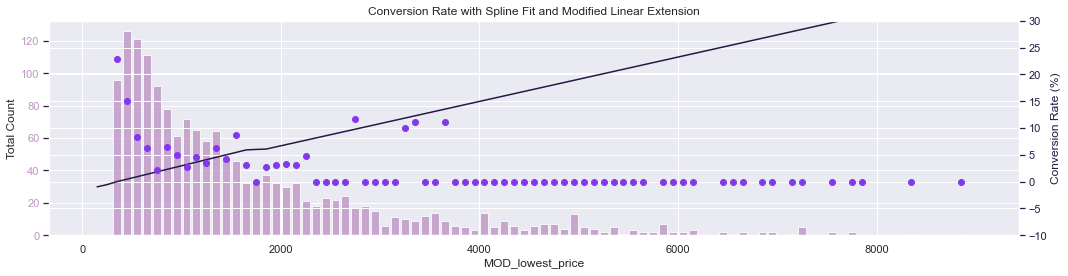

In [118]:
linear_fit_composite, conversion_rates_selected_array  = apply_splines(data_final_conv, 'MOD_lowest_price', 
                                                                     low_limit=300, 
                                                                     upper_limit=1800, 
                                                                     degree=1, df=1, slope_factor=0.91, 
                                                                     bin_start=100, 
                                                                     bin_end=data_final_conv.MOD_lowest_price.max() + 1,
                                                                     bin_width=100,
                                                                     colors=colors3_3)

Here we don't get to create the tendency we see

Now we will do it for the variable **VEH_age**:

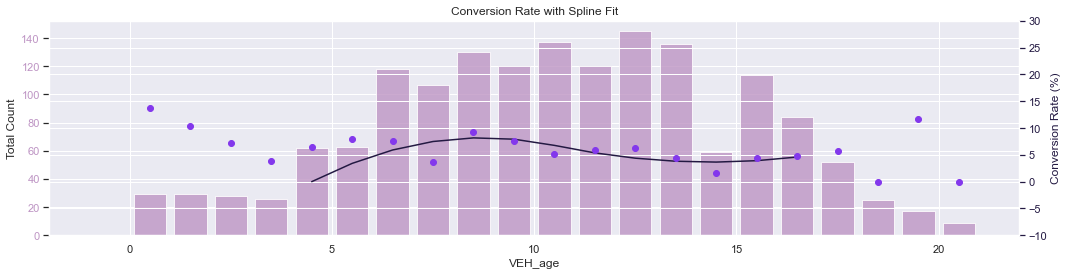

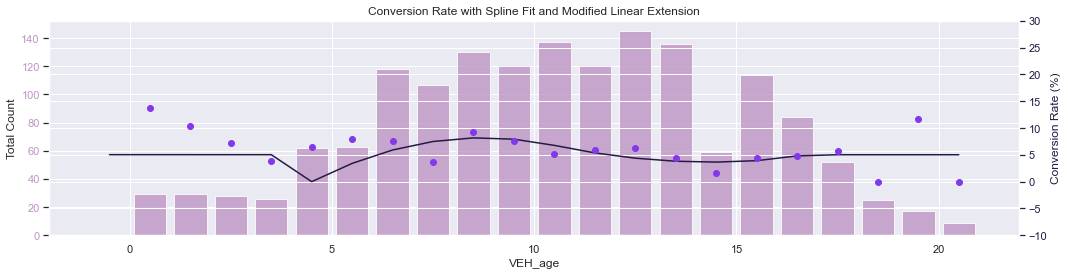

In [119]:
linear_fit_composite, conversion_rates_selected_array  = apply_splines(data_final_conv, 'VEH_age', 
                                                                     low_limit=4, 
                                                                     upper_limit=17, 
                                                                     degree=2, df=3, slope_factor=1, 
                                                                     bin_start=data_final_conv.VEH_age.min()-1, 
                                                                     bin_end=data_final_conv.VEH_age.max()+1,
                                                                     bin_width=1,
                                                                     colors=colors3_3)

We don't see any clear trend to do it.

Now we define the variables to use.

Note that we won't apply the spline variables of competitiveness and drive1 age as the results are a little bite worse.

In [120]:
# we drop the variables we dont need
data_final_conv = data_final_conv.drop(columns=['variable_bin'])

In [121]:
# total variables to use
vars_to_use=['POL_days_to_incep',
             'MOD_competitive',
#              'MOD_competitive_comp',
             'MOD_lowest_price',
#              'DRI_1_age',
#              'DRI_1_age_comp',
             'POL_homeowner', 
             'DRI_1_NCD_total_years',
             'VEH_age'
]

# variables to include
# base_vars = ['POL_days_to_incep', 'MOD_competitive_comp', 'MOD_lowest_price', 'DRI_1_age_comp']
# base_vars = ['POL_days_to_incep', 'MOD_competitive', 'MOD_lowest_price', 'DRI_1_age']
base_vars = ['POL_days_to_incep', 'MOD_competitive', 'MOD_lowest_price']

# additional vars to include in combinations
addit_vars = ['POL_homeowner_Y', 'DRI_1_NCD_total_years','VEH_age']
addit_vars_labels = {'VEH_age': 'veh age', 'POL_homeowner_Y': 'homeowner', 'DRI_1_NCD_total_years': 'NCD'}

In [122]:
# we generate all combinations
all_combinations = []
for r in range(len(addit_vars) + 1):
    comb = list(combinations(addit_vars, r))
    all_combinations.extend(comb)

# Convert tuples to lists
all_combinations = [list(combo) for combo in all_combinations]

all_combinations

[[],
 ['POL_homeowner_Y'],
 ['DRI_1_NCD_total_years'],
 ['VEH_age'],
 ['POL_homeowner_Y', 'DRI_1_NCD_total_years'],
 ['POL_homeowner_Y', 'VEH_age'],
 ['DRI_1_NCD_total_years', 'VEH_age'],
 ['POL_homeowner_Y', 'DRI_1_NCD_total_years', 'VEH_age']]

In [123]:
# Function to prepare the data and perform cross-validation
def eval_model(X, y):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=30, random_state=seed)
    model = LogisticRegression(random_state=seed, max_iter=10000,class_weight='balanced') 
    # adjusts the weights of the classes inversely proportional to their frequencies in the data.
    results = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer)
    return results

In [124]:
X = data_final_conv[vars_to_use]
y = data_final_conv['MOD_sale']

# we transform to dummy variables the categorical ones
cat_cols = X.select_dtypes(include=['object']).columns

# we convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# we split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled  = smote.fit_resample(X_train, y_train)

# Fit the scaler on the numerical features of the training data and transform the training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


# we check the sum of variable means
train_mean_sum = X_train_scaled.mean().abs().sum().round(2)
test_mean_sum = X_test_scaled.mean().abs().sum().round(2)

print(f"Sum of absolute means for X_train_scaled: {train_mean_sum}")
print(f"Sum of absolute means for X_test_scaled: {test_mean_sum}")

Sum of absolute means for X_train_scaled: 0.0
Sum of absolute means for X_test_scaled: 1.55


In [125]:
# Initialize a list to store results
model_results = []

# Reset the index
X_train_scaled.reset_index(drop=True, inplace=True)
X_test_scaled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

for i, combo in enumerate(all_combinations):
    selected_vars = base_vars + combo
    
    X_train_scaled_sel = X_train_scaled[selected_vars]
    X_test_scaled_sel = X_test_scaled[selected_vars]
    
    results = eval_model(X_train_scaled_sel, y_train_resampled)
    
    model_name = f"model {i+1}: base"
    if combo:
        model_name += " + " + " + ".join([addit_vars_labels[var] for var in combo])
    
    model_results.append({
        'model': model_name,
        'results': results,
        'variables': selected_vars
    })

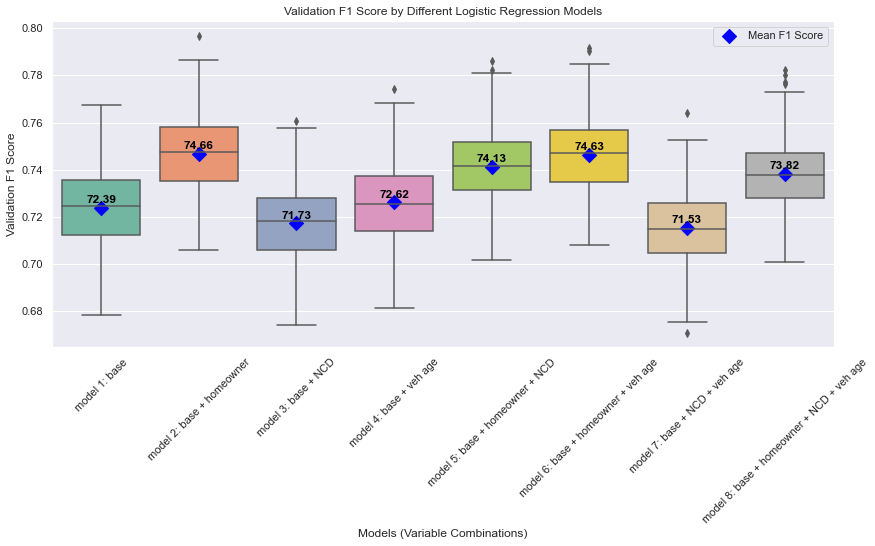

In [126]:
# Create a DataFrame for plotting the F1 scores
f1_scores_df = pd.DataFrame({
    'F1 Score': np.concatenate([result['results'] for result in model_results]),
    'Model': np.concatenate([[result['model']] * len(result['results']) for result in model_results])
})

# Plot the boxplot
plt.figure(figsize=(14, 6))
ax = sns.boxplot(x='Model', y='F1 Score', data=f1_scores_df, palette='Set2')

# Set alpha for the boxplot elements
for patch in ax.artists:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))  # Set the alpha to 0.6

plt.title('Validation F1 Score by Different Logistic Regression Models')
plt.xlabel('Models (Variable Combinations)')
plt.ylabel('Validation F1 Score')
plt.xticks(rotation=45)

# Calculate and plot the means
means = f1_scores_df.groupby('Model').mean().reset_index()
plt.scatter(means['Model'], means['F1 Score'], color='blue', marker='D', s=100, label='Mean F1 Score')

# Annotate the means on the plot
for i in range(means.shape[0]):
    plt.text(i, means['F1 Score'][i] + 0.002, round(means['F1 Score'][i]*100, 2), 
             horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.legend()
plt.show()

In [127]:
# Identify the best model
best_model_idx = np.argmax([np.mean(result['results']) for result in model_results])
best_model = model_results[best_model_idx]

# Print the best model name
print(f"Best model: {best_model['model']}")

Best model: model 2: base + homeowner


In [128]:
# Fit the best model using statsmodels
X_best = X_train_scaled[best_model['variables']]
X_best = sm.add_constant(X_best)  # Add a constant term for the intercept
y_best = y_train_resampled.loc[X_best.index]

logit_model = sm.Logit(y_best, X_best)
result = logit_model.fit()

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.523935
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               MOD_sale   No. Observations:                 2272
Model:                          Logit   Df Residuals:                     2267
Method:                           MLE   Df Model:                            4
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.2441
Time:                        18:54:30   Log-Likelihood:                -1190.4
converged:                       True   LL-Null:                       -1574.8
Covariance Type:            nonrobust   LLR p-value:                4.179e-165
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2556      0.055     -4.623      0.000      -0.364      -0.147
POL_days

In [129]:
best_model_vars = best_model['variables']
X_train_best = X_train_scaled[best_model_vars]
X_test_best = X_test_scaled[best_model_vars]

best_model_logreg = LogisticRegression(random_state=seed, max_iter=10000, class_weight='balanced')

In [130]:
# Specify the path to save/load the model
model_path = 'models_saved/best_model_logreg.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the GridSearchCV object
    best_model_logreg = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Fit the model and perform hyperparameter tuning
    best_model_logreg.fit(X_train_best, y_train_resampled)
    # Save the model
    joblib.dump(best_model_logreg, model_path)
    print("Model fitted and saved successfully.")
    
# best_model_logreg.fit(X_train_best, y_train_resampled)

Model loaded successfully.


Optimal Threshold: 0.3477
Optimal F1 Score: 0.7686


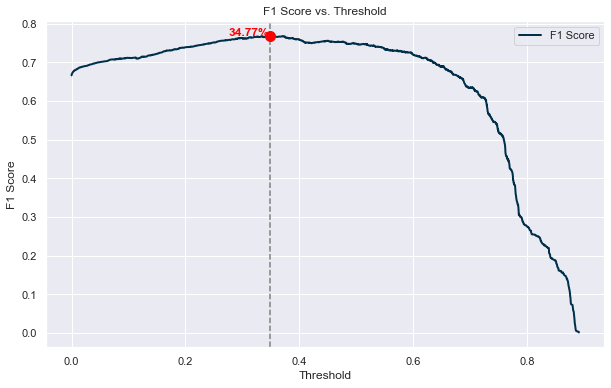

In [131]:
# Predict probabilities for the training data
y_train_prob = best_model_logreg.predict_proba(X_train_best)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_train_resampled, y_train_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Optimal F1 Score: {optimal_f1_score:.4f}")

# Create the plot with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=f1_scores[:-1], color='#003049', linewidth=2, label='F1 Score')
plt.axvline(x=optimal_threshold, color='gray', linestyle='--')
plt.scatter(optimal_threshold, optimal_f1_score, color='red', s=100, zorder=5)
plt.text(optimal_threshold, optimal_f1_score, f'{optimal_threshold:.2%}', 
         horizontalalignment='right', size='medium', color='red', weight='semibold')

# Add titles and labels
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.show()

Training Set Evaluation


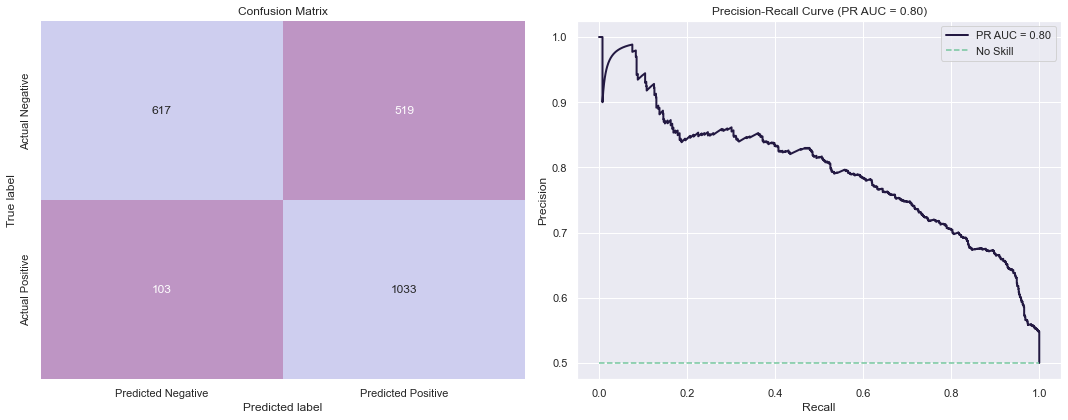

Accuracy: 0.7262
Recall (Sensitivity): 0.9093
Specificity: 0.5431
Precision: 0.6656
F1 Score: 0.7686
Prevalence: 0.5000


In [132]:
# Evaluate on training and test sets
print("Training Set Evaluation")
calc_metrics(best_model_logreg, X_train_best, y_train_resampled, optimal_threshold)

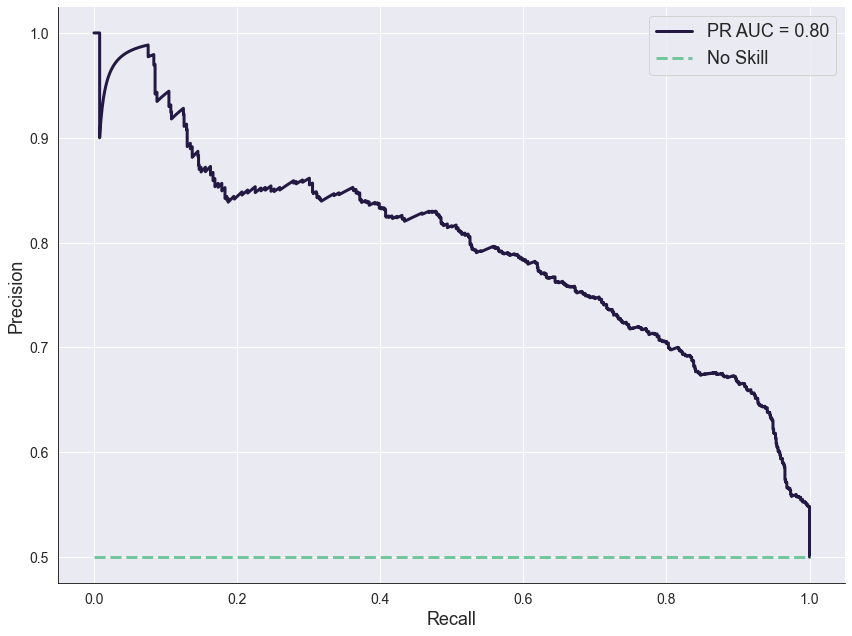

In [133]:
calc_metrics_2(best_model_logreg, X_train_best, y_train_resampled, optimal_threshold,12,9)


Test Set Evaluation


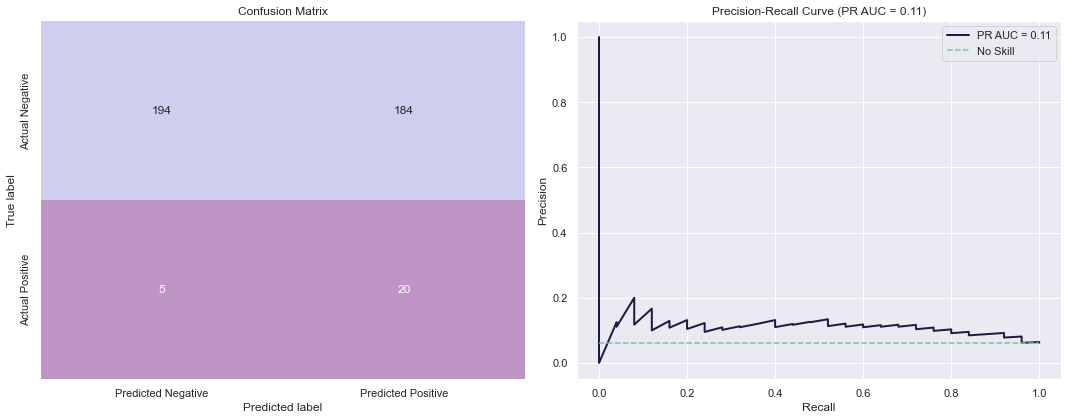

Accuracy: 0.5310
Recall (Sensitivity): 0.8000
Specificity: 0.5132
Precision: 0.0980
F1 Score: 0.1747
Prevalence: 0.0620


In [134]:
print("\nTest Set Evaluation")
calc_metrics(best_model_logreg, X_test_best, y_test, optimal_threshold)

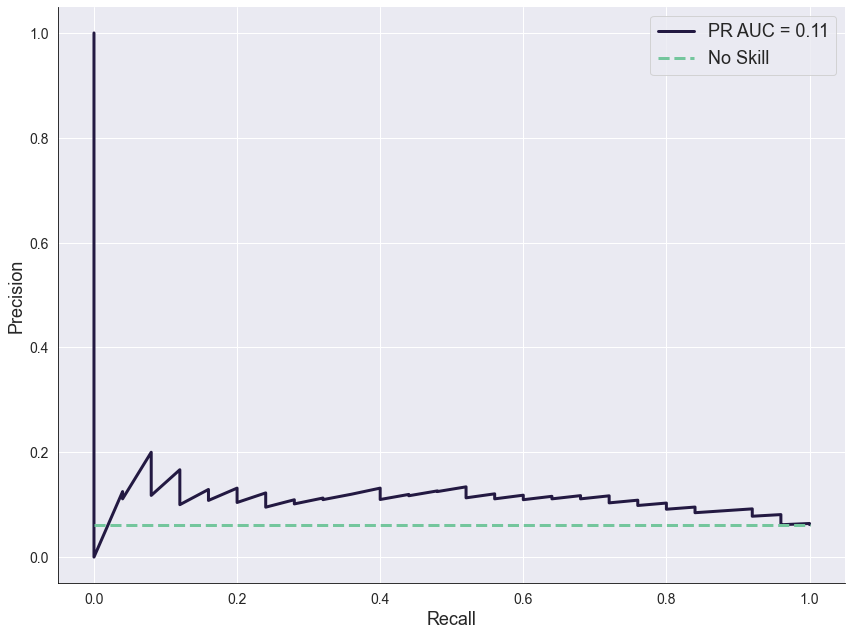

In [135]:
calc_metrics_2(best_model_logreg, X_test_best, y_test, optimal_threshold,12,9)

The model looks ok when evaluated in the validation and training sets, but it still generalizes very bad as we can observe by the metrics for predicting the test set.

**We would need to have more days of quotations to increase the sample size and reduce issues like the complete separation we were getting from the cover and the monthly payment variables.**

## <font color="#5e548e">3. Drivers of Income <a name="id3"></a>

[Go to Table of Content](#ToC)

To understand what are the drivers of Chill Insurance income we will check if the following variables match with the income:

In [136]:
# variables to consider
var_to_consider=['QUO_1_fee', 
                 'QUO_1_comm', 
                 'QUO_1_disc', 
                 'QUO_1_income',
                 'QUO_1_GWP',
                 'QUO_1_price',
                 'QUO_2_fee',
                 'QUO_2_comm',
                 'QUO_2_disc',
                 'QUO_2_income',
                 'QUO_2_GWP',
                 'QUO_2_price',
                 'QUO_3_fee',
                 'QUO_3_comm',
                 'QUO_3_disc',
                 'QUO_3_income',
                 'QUO_3_GWP',
                 'QUO_3_price',
                 'MOD_lowest_price',
                 'MOD_sale'
                ]
# we create a new dataframe
income = data_final[var_to_consider].copy()

# Create the new variables
income['QUO_GWP'] = income.apply(
    lambda row: row['QUO_1_GWP'] if row['MOD_lowest_price'] == row['QUO_1_price'] else
                (row['QUO_2_GWP'] if row['MOD_lowest_price'] == row['QUO_2_price'] else
                 (row['QUO_3_GWP'] if row['MOD_lowest_price'] == row['QUO_3_price'] else None)),
    axis=1
)


income['QUO_income'] = income.apply(
    lambda row: row['QUO_1_income'] if row['MOD_lowest_price'] == row['QUO_1_price'] else
                (row['QUO_2_income'] if row['MOD_lowest_price'] == row['QUO_2_price'] else
                 (row['QUO_3_income'] if row['MOD_lowest_price'] == row['QUO_3_price'] else None)),
    axis=1
)

income['QUO_fee'] = income.apply(
    lambda row: row['QUO_1_fee'] if row['MOD_lowest_price'] == row['QUO_1_price'] else
                (row['QUO_2_fee'] if row['MOD_lowest_price'] == row['QUO_2_price'] else
                 (row['QUO_3_fee'] if row['MOD_lowest_price'] == row['QUO_3_price'] else None)),
    axis=1
)

income['QUO_comm'] = income.apply(
    lambda row: row['QUO_1_comm'] if row['MOD_lowest_price'] == row['QUO_1_price'] else
                (row['QUO_2_comm'] if row['MOD_lowest_price'] == row['QUO_2_price'] else
                 (row['QUO_3_comm'] if row['MOD_lowest_price'] == row['QUO_3_price'] else None)),
    axis=1
)

income['QUO_disc'] = income.apply(
    lambda row: row['QUO_1_disc'] if row['MOD_lowest_price'] == row['QUO_1_price'] else
                (row['QUO_2_disc'] if row['MOD_lowest_price'] == row['QUO_2_price'] else
                 (row['QUO_3_disc'] if row['MOD_lowest_price'] == row['QUO_3_price'] else None)),
    axis=1
)

# we drop the price variables
vars_to_drop=['QUO_1_fee', 
                 'QUO_1_comm', 
                 'QUO_1_disc', 
                 'QUO_1_income',
                 'QUO_1_GWP',
                 'QUO_1_price',
                 'QUO_2_fee',
                 'QUO_2_comm',
                 'QUO_2_disc',
                 'QUO_2_income',
                 'QUO_2_GWP',
                 'QUO_2_price',
                 'QUO_3_fee',
                 'QUO_3_comm',
                 'QUO_3_disc',
                 'QUO_3_income',
                 'QUO_3_GWP',
                 'QUO_3_price',
                 'MOD_lowest_price'
                ]
income=income.drop(columns=vars_to_drop,  errors='ignore')

income.head(5)

MOD_sale  QUO_GWP  QUO_income  QUO_fee  QUO_comm  QUO_disc
QuoteQueryId                                                            
56346939             0  1974.12      209.33      0.0    188.01     21.32
56358210             0   658.90       49.89      0.0     62.75    -12.86
56364057             0  6169.41      242.28      0.0    518.92   -276.64
56387878             0  2431.70      442.56      0.0    231.59    210.97
56340963             0  2502.92      398.56      0.0    238.37    160.19

In [137]:
# check
income['Income_check']=abs(income.QUO_income-(income.QUO_fee+income.QUO_comm+income.QUO_disc))
income['Income_check'].sum()

0.0

As such we can conclude that the drivers of the income are the commissions, the discounts/surcharges and the fees.

Now let's see how they distribute for all this quotations for the potential income and the realised income:

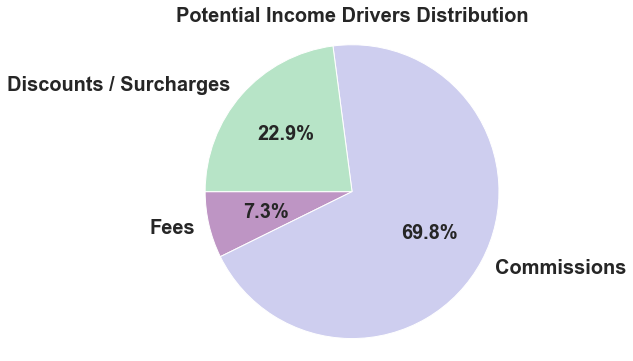

In [138]:
# Sum the values of QUO_fee, QUO_comm, and QUO_disc
total_fee = income['QUO_fee'].sum()
total_comm = income['QUO_comm'].sum()
total_disc = income['QUO_disc'].sum()

# Data for pie chart
# labels = ['', '', '']
labels = ['Fees', 'Commissions', 'Discounts / Surcharges']
sizes = [total_fee, total_comm, total_disc]
colors = ['#be95c4', '#CECEEF', '#b7e4c7']  # Seaborn palette colors

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
       startangle=180, textprops={'fontsize': 20,'fontweight':'bold'})
plt.title('Potential Income Drivers Distribution', fontsize=20, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [139]:
formatted_total_income = f"{income.QUO_income.sum():,.0f}"

print(f'The total potential income from these quotations is {formatted_total_income}')

The total potential income from these quotations is 331,361


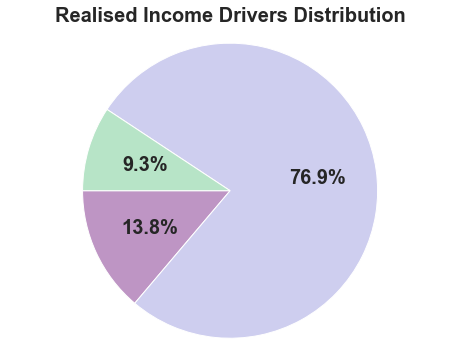

In [140]:
# Sum the values of QUO_fee, QUO_comm, and QUO_disc
total_fee = income[income['MOD_sale']==1].QUO_fee.sum()
total_comm = income[income['MOD_sale']==1].QUO_comm.sum()
total_disc = income[income['MOD_sale']==1].QUO_disc.sum()

# Data for pie chart
labels = ['', '', '']
# labels = ['Fees', 'Commissions', 'Discounts / Surcharges']
sizes = [total_fee, total_comm, total_disc]
colors = ['#be95c4', '#CECEEF', '#b7e4c7']  # Seaborn palette colors

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
       startangle=180, textprops={'fontsize': 20,'fontweight':'bold'})
plt.title('Realised Income Drivers Distribution', fontsize=20, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [141]:
formatted_total_income = f"{income[income['MOD_sale']==1].QUO_income.sum():,.0f}"
print(f'The total potential income from these quotations is {formatted_total_income}')

formatted_percentage_income = f"{income[income['MOD_sale'] == 1]['QUO_income'].sum() / income['QUO_income'].sum():.1%}"
print(f'It is a {formatted_percentage_income} of the total potential income')

The total potential income from these quotations is 10,531
It is a 3.2% of the total potential income


Lastly, we are going to show how much more variability there is in the Income than in the underlying GWP due to the variable effect of the discount / Surcharges.

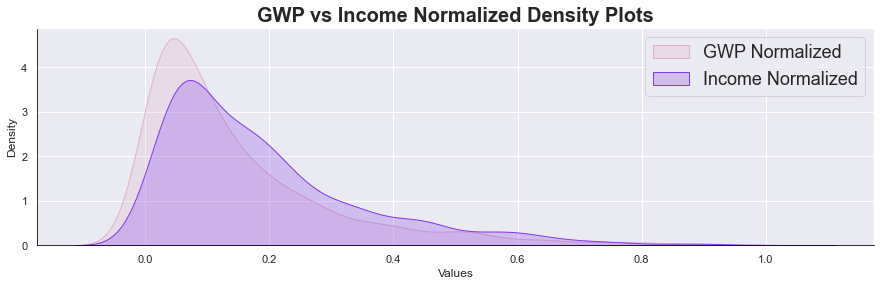

In [142]:
# Normalize the data
scaler = MinMaxScaler()
income[['QUO_GWP', 'QUO_income']] = scaler.fit_transform(income[['QUO_GWP', 'QUO_income']])

sns.set_theme(style='darkgrid')
# sns.set_theme(style='white')
plt.figure(figsize=(15, 4))

# Create the plot and capture the axis
chart = sns.kdeplot(data=income, x='QUO_GWP', fill=True, common_norm=False, color='#e0b1cb', label='QUO_GWP')
sns.kdeplot(data=income, x='QUO_income', fill=True, common_norm=False, color='#8338ec', label='QUO_income', ax=chart)

# Set the title and labels
# plt.title('', fontsize=20, fontweight='bold')
plt.title('GWP vs Income Normalized Density Plots', fontsize=20, fontweight='bold')
plt.xlabel('Values')
# plt.xlabel('')
plt.ylabel('Density')
plt.legend(title='Variable')

chart.legend(title='', labels=['GWP Normalized', 'Income Normalized'],fontsize=18)

# Set the axis lines to black and adjust the linewidth
chart.spines['left'].set_color('black')
chart.spines['left'].set_linewidth(0.8)
chart.spines['bottom'].set_color('black')
chart.spines['bottom'].set_linewidth(0.8)

# Remove the upper and right spines
# chart.spines['top'].set_visible(False)
# chart.spines['right'].set_visible(False)

plt.show()

## <font color="#5e548e">4. A/B Test Evaluation <a name="id4"></a>

[Go to Table of Content](#ToC)

First, we are going to build a dataframe with the necessary variables to do the analysis.

In [143]:
vars_for_analysis = ['MOD_model',
                    'MOD_competitive',
                    'MOD_sale'
                    ]

# we filter by this variables
data_analysis=data_final[vars_for_analysis]
data_analysis.head(5)

MOD_model  MOD_competitive  MOD_sale
QuoteQueryId                                       
56346939             Low         0.424032         0
56358210      Challenger         1.083354         0
56364057             Low         0.359510         0
56387878            High         0.445428         0
56340963        Champion         0.448964         0

Now we will run our final conversion model over all the dataset.

In [144]:
# we define X and Y
X = data_final[vars_to_use]
y = data_final['MOD_sale']

cat_cols = X.select_dtypes(include=['object']).columns

# we convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X=X[best_model['variables']]
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [145]:
# now we predict the model
y_prob = best_model_logreg.predict_proba(X_scaled)[:, 1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# we add them to the dataframe
data_analysis = data_analysis.assign(y_prob=y_prob, y_pred=y_pred)

data_analysis.head(5)

MOD_model  MOD_competitive  MOD_sale    y_prob  y_pred
QuoteQueryId                                                         
56346939             Low         0.424032         0  0.212216       0
56358210      Challenger         1.083354         0  0.855098       1
56364057             Low         0.359510         0  0.005951       0
56387878            High         0.445428         0  0.435959       1
56340963        Champion         0.448964         0  0.451297       1

To check which market price model is the best one we will do the following 4 analysis:
+ Evaluation the conversion model predictions using F1 Score by PricingModel
+ Correlation coefficient between the competitiveness ratio and the conversion predictions comparison by PricingModel
+ Conversion vs competitiveness ratio coefficient of determination ($R^2$) comparison by PricingModel
+ Competitiveness ratio distance between converted and not converted comparison by PricingModel

All of these analysis are based on the following assumption:
+ If a PricingModel provides the real price that there is in the market for that potential customer (the one doing the quote).
+ Then the competitiveness ratio of the lowest price provided in the panel against this market price will be the real one.
+ As current car insurance products don't differentiate much in real terms and the customer decision is mainly driven by price, there should be a strong positive correlation between the competitiveness of that panel price and conversion.

On the other hand we understand that this is and A/B test where *Other* model refers to the current process of adquiring the market price. As such, from the best of the models we will do a hypotesis testing with a confidence level of 95% to state if this proposed model is better than the current procces.

**Evaluation the conversion model predictions using F1 Score by PricingModel**

In [146]:
# we make a function for the metrics
def metrics_summary(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prevalence = (tp + fn) / (tn + fp + fn + tp)
    
    return {
        'Count': len(y_true),
        'Accuracy': accuracy,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1,
        'Prevalence': prevalence
    }

In [147]:
# Group by MOD_model and calculate metrics for each group
metrics_list = []
for mod_model, group in data_analysis.groupby('MOD_model'):
    metrics = metrics_summary(group['MOD_sale'], group['y_pred'])
    metrics['MOD_model'] = mod_model
    metrics_list.append(metrics)

# Create a dataframe from the list of metrics
metrics_df = pd.DataFrame(metrics_list)

# Set the MOD_model as the index
metrics_df.set_index('MOD_model', inplace=True)

In [148]:
metrics_df

Count  Accuracy  Recall (Sensitivity)  Specificity  Precision  \
MOD_model                                                                   
Challenger    242  0.301653              0.882353     0.257778   0.082418   
Champion      595  0.452101              0.833333     0.440208   0.044379   
High           50  0.440000              1.000000     0.428571   0.034483   
Low            72  0.388889              1.000000     0.352941   0.083333   
Other         652  0.342025              0.947368     0.284034   0.112500   

            F1 Score  Prevalence  
MOD_model                         
Challenger  0.150754    0.070248  
Champion    0.084270    0.030252  
High        0.066667    0.020000  
Low         0.153846    0.055556  
Other       0.201117    0.087423

**Correlation coefficient between the competitiveness ratio and the conversion predictions comparison by PricingModel**

In [149]:
# Group by MOD_model and calculate metrics for each group
correlation_list = []
for mod_model, group in data_analysis.groupby('MOD_model'): 
    # Calculate correlation coefficient between MOD_competitive and y_prob
    correlation = group[['MOD_competitive', 'y_prob']].corr().iloc[0, 1]
    correlation_list.append({'MOD_model': mod_model, 'Correlation': correlation})

# Create a dataframe from the list of correlations
correlation_df = pd.DataFrame(correlation_list)

# Set the MOD_model as the index
correlation_df.set_index('MOD_model', inplace=True)

In [150]:
correlation_df

Correlation
MOD_model              
Challenger     0.401521
Champion       0.475839
High           0.655319
Low            0.313884
Other          0.270788

**Conversion vs competitiveness ratio coefficient of determination comparison by PricingModel**

In [151]:
# Initialize a dictionary to store the results
r2_results = {}

for name, group in data_analysis.groupby('MOD_model'):
    # Prepare the data
    X = group['MOD_competitive'].values.reshape(-1, 1)
    y = group['MOD_sale'].values
    
    # Fit regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X)
    
    # Calculate the coefficient of determination (R²)
    r2 = r2_score(y, y_pred)
    
    # Store the result
    r2_results[name] = r2

# Convert the results to a DataFrame
r2_df = pd.DataFrame(list(r2_results.items()), columns=['MOD_model', 'R2'])

In [152]:
r2_df

MOD_model            R2
0  Challenger  1.123462e-02
1    Champion  2.646178e-07
2        High  3.535532e-05
3         Low  4.060131e-03
4       Other  7.881409e-03

**Competitiveness ratio distance between converted and not converted comparison by PricingModel**

In [153]:
# Group by MOD_model and MOD_sale and calculate the mean of MOD_competitive
avg_competitive = data_analysis.groupby(['MOD_model', 'MOD_sale']).agg(
                            avg_competitive=('MOD_competitive', 'mean'),
                            std_competitive=('MOD_competitive', 'std'),
                            count=('MOD_competitive', 'size')
                    ).reset_index()

# Pivot the table to get average MOD_competitive for MOD_sale == 0 and MOD_sale == 1 in separate columns
avg_competitive_pivot = avg_competitive.pivot(index='MOD_model',columns='MOD_sale', 
                                              values=['avg_competitive', 
                                                      'std_competitive',
                                                      'count']).reset_index()

# Rename the columns for clarity
avg_competitive_pivot.columns = ['MOD_model', 
                                 'avg_competitive_0', 'avg_competitive_1', 
                                 'std_competitive_0', 'std_competitive_1',
                                 'count_0', 'count_1']

# Calculate the competitive_distance
avg_competitive_pivot['competitive_dist'] = (avg_competitive_pivot['avg_competitive_1'] 
                                             - avg_competitive_pivot['avg_competitive_0'])

# reorder
avg_competitive_pivot = avg_competitive_pivot[['MOD_model', 'count_0', 'count_1', 
                                               'avg_competitive_0', 'avg_competitive_1', 
                                               'std_competitive_0', 'std_competitive_1', 
                                               'competitive_dist']]

In [154]:
avg_competitive_pivot

MOD_model  count_0  count_1  avg_competitive_0  avg_competitive_1  \
0  Challenger    225.0     17.0           0.663925           0.770127   
1    Champion    577.0     18.0           0.602409           0.603157   
2        High     49.0      1.0           0.565473           0.574638   
3         Low     68.0      4.0           0.621271           0.694250   
4       Other    595.0     57.0           0.733492           0.803944   

   std_competitive_0  std_competitive_1  competitive_dist  
0           0.255302           0.260974          0.106202  
1           0.246313           0.339907          0.000748  
2           0.220245                NaN          0.009165  
3           0.271044           0.066641          0.072979  
4           0.226381           0.191742          0.070452

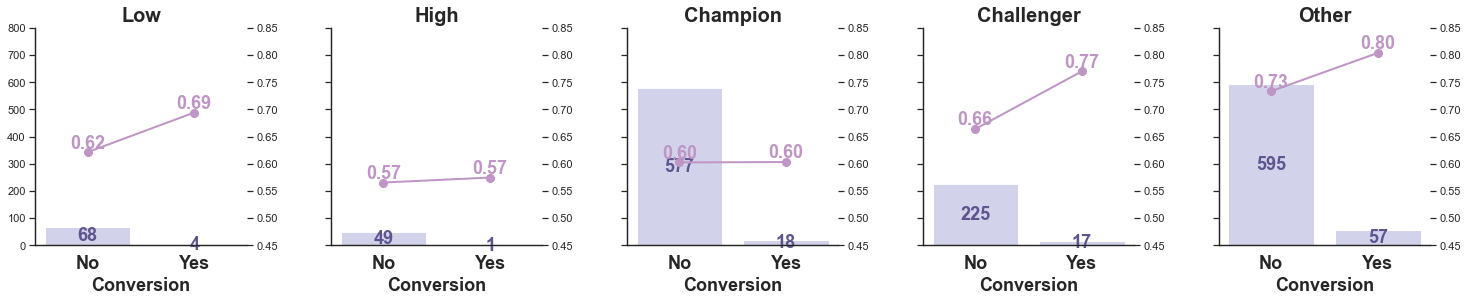

In [158]:
order = ['Low',  'High',  'Champion', 'Challenger', 'Other']

# Reorder the dataframe based on the specified order
avg_competitive_pivot['MOD_model'] = pd.Categorical(avg_competitive_pivot['MOD_model'], categories=order, ordered=True)
avg_competitive_pivot = avg_competitive_pivot.sort_values('MOD_model')

# Set the theme
sns.set_theme(style='white')

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25,4), sharey=True)
plt.subplots_adjust(wspace=0.4)

# Iterate over each model and create the corresponding plot
for i, model in enumerate(avg_competitive_pivot['MOD_model']):
    data = avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == model]
    
    # Bar plot
    sns.barplot(
        ax=axes[i],
        x=['No', 'Yes'],
        y=[data['count_0'].values[0], data['count_1'].values[0]],
        palette=['#CECEEF','#CECEEF']
    )
    
    # Set the primary y-axis limit
    axes[i].set_ylim(0, 800)
    
    # Adding bar labels
    axes[i].text(0, data['count_0'].values[0] / 2, str(int(data['count_0'].values[0])),
                 ha='center', va='center', color='#5e548e', fontsize=18, fontweight='bold')
    axes[i].text(1, data['count_1'].values[0] / 2, str(int(data['count_1'].values[0])),
                 ha='center', va='center', color='#5e548e', fontsize=18, fontweight='bold')

    # Secondary axis for avg_competitive values
    ax2 = axes[i].twinx()
    avg_competitive_0 = data['avg_competitive_0'].values[0]
    avg_competitive_1 = data['avg_competitive_1'].values[0]
    ax2.plot(
        ['No', 'Yes'],
        [avg_competitive_0, avg_competitive_1],
        color='#be95c4', marker='o', linestyle='-', linewidth=2, markersize=8
    )
    
    # Adding labels to the secondary axis
    ax2.text(0, avg_competitive_0, f"{avg_competitive_0:.2f}", ha='center', va='bottom', 
             color='#be95c4', fontsize=18, fontweight='bold')
    ax2.text(1, avg_competitive_1, f"{avg_competitive_1:.2f}", ha='center', va='bottom',
             color='#be95c4', fontsize=18, fontweight='bold')

    # Set the secondary y-axis limit
    ax2.set_ylim(0.45, 0.85)

    # Setting titles and labels
#     axes[i].set_title('', fontsize=20, fontweight='bold')
    axes[i].set_title(model, fontsize=20, fontweight='bold')
    axes[i].set_xlabel('Conversion',fontsize=18, fontweight='bold')
#     axes[i].set_xlabel('',fontsize=18, fontweight='bold')
    axes[i].set_xticklabels(['No', 'Yes'], fontsize=18, fontweight='bold')
    if i == 0:
        axes[i].set_ylabel('', fontsize=12)
    ax2.set_ylabel('', fontsize=18, color='#161645')

    # Remove the upper and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

# Show the plot
plt.show()

**Conclusion**

Now we will do a hypotesis testing assuming:

+ Null Hypothesis ($H_0$): The best model is not better than the current market price process.
+ Alternative Hypothesis ($H_1$): The best model is better than the current market price process

In this sense better will mean that it has more distance in competitiveness between not converting and converting.

In [156]:
# Extract competitive_dist values for Challenger and Other
challenger_dist = avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Challenger']['competitive_dist'].values
other_dist = avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Other']['competitive_dist'].values

# Get the sample sizes
challenger_count = (avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Challenger']['count_0'].values[0] +
                    avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Challenger']['count_1'].values[0])
other_count = (avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Other']['count_0'].values[0] +
               avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Other']['count_1'].values[0])

# Calculate the mean and standard error for competitive_dist
mean_challenger = challenger_dist.mean()
mean_other = other_dist.mean()
std_challenger = avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Challenger']['std_competitive_1'].values[0]
std_other = avg_competitive_pivot[avg_competitive_pivot['MOD_model'] == 'Other']['std_competitive_1'].values[0]

# Calculate the standard error of the difference in means
standard_error = np.sqrt((std_challenger ** 2 / challenger_count) + (std_other ** 2 / other_count))

# Calculate the z-score
z_score = (mean_challenger - mean_other) / standard_error

# Calculate the p-value (one-tailed test)
p_value = 1 - stats.norm.cdf(z_score)

print(f"Challenger competitive_dist mean: {round(mean_challenger,2)}")
print(f"Other competitive_dist mean: {round(mean_other,2)}")
print(f"Z-Score: {round(z_score,2)}")
print(f"P-Value: {round(p_value,2)}")

if p_value < 0.05:
    print("We reject the null hypothesis: The `competitive_dist` for Challenger"
          "is significantly higher than for Other.")
else:
    print("We fail to reject the null hypothesis: The `competitive_dist` for Challenger"
          "is not significantly higher than for Other.")

Challenger competitive_dist mean: 0.11
Other competitive_dist mean: 0.07
Z-Score: 1.95
P-Value: 0.03
We reject the null hypothesis: The `competitive_dist` for Challengeris significantly higher than for Other.


Looking at these results we can conclude that **the best model is the Challenger model** and that **it is significantly better than the current process** although it would be advisable to reperform this analysis with more quotations.